In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm

from train_net import Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer

from analysis.max_logits import MaxLogitsAnalyzer, OODEvaluator

import vis_utils as vis

In [4]:
plt.rcParams['axes.grid'] = False
plt.rcParams['image.cmap'] = 'viridis'

# PATHS

In [5]:
config_path_swin_b_in21k = './configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_base_IN21k_384_bs16_90k.yaml'
config_path_swin_l_in21k = './configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_90k.yaml'
config_path_swin_s = 'configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_small_bs16_90k.yaml'
config_path_swin_t = 'configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_tiny_bs16_90k.yaml'
config_path_r101 = './configs/cityscapes/semantic-segmentation/maskformer2_R101_bs16_90k.yaml'


ckpt_path_swin_b_in21k = './pretrained/swin_b_in21k_model_final_1c6b65.pkl'
ckpt_path_swin_l_in21k = './pretrained/swin_l_in21k_model_final_17c1ee.pkl'
ckpt_path_swin_s = './pretrained/swin_s_model_final_fa26ae.pkl'
ckpt_path_swin_t = './pretrained/swin_t_model_final_2d58d4.pkl'
ckpt_path_r101 = './pretrained/r101_model_final_257ce8.pkl'

config_paths = {
    'r101': config_path_r101,
    'swin_t': config_path_swin_t,
    'swin_s': config_path_swin_s,
    'swin_b': config_path_swin_b_in21k,
    'swin_l': config_path_swin_l_in21k,
}

ckpt_paths = {
    'r101': ckpt_path_r101,
    'swin_t': ckpt_path_swin_t,
    'swin_s': ckpt_path_swin_s,
    'swin_b': ckpt_path_swin_b_in21k,
    'swin_l': ckpt_path_swin_l_in21k
}

In [6]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

def get_model(name):
    
    args = edict({'config_file': config_paths[name], 'eval-only':True, 'opts':[]})
    config = setup(args)

    ckpt = load_model_state_dict(ckpt_paths[name])
    model = Trainer.build_model(config)
    DetectionCheckpointer(model, save_dir=config.OUTPUT_DIR).resume_or_load(
        ckpt_paths[name], resume=False
    )
    model.cuda()
    _ = model.eval()
    
    return model

# Params

In [7]:
image_mean = [123.675, 116.280, 103.530]
image_std = [58.395, 57.120, 57.375]

# Dataset Configs

In [8]:
bdd100k_config = edict({
    'seg_downsample_rate': 1,
    'train_file': 'train_paths.txt',
    'val_file': 'val_paths.txt',
    'val_image_strategy': 'no_change',
    'ignore_train_class': True,
    'dataset_root': '/media/nazirnayal/DATA/datasets/bdd100k/seg'
})

cityscapes_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/cityscapes',
})

road_anomaly_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/RoadAnomaly/RoadAnomaly_jpg',
    'test_image_strategy': 'no_change'
})

fishyscapes_laf_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/Fishyscapes/',
})

fishyscapes_static_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/Fishyscapes/',
})

road_anomaly_21_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/SegmentMeIfYouCan/dataset_AnomalyTrack',
    'dataset_mode': 'all'
})

road_obstacle_21_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/SegmentMeIfYouCan/dataset_ObstacleTrack',
    'dataset_mode': 'all'
})



# Create Datasets

In [9]:
# Cityscapes
transform = A.Compose([
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

# BDD100K
transform_bdd100k = A.Compose([
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    ToTensorV2()
])
fs_static_dataset = FishyscapesStatic(hparams=fishyscapes_static_config, transforms=transform_fs_static)
loader_fs_static = DataLoader(fs_static_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)


# Util Functions

In [10]:
def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda()}], **kwargs)
    
    if kwargs['return_separately']:
        return out[0][0]['sem_seg'].unsqueeze(0), out[1], out[2]
    
    return out[0]['sem_seg'].unsqueeze(0)

In [11]:
model_swin_b = get_model('swin_b')

Loading config ./configs/cityscapes/semantic-segmentation/swin/../Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[08/11 14:18:00 detectron2]: Rank of current process: 0. World size: 1
[08/11 14:18:01 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
numpy                   1.19.0
detectron2              0.6 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.3
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0+cu113 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch=8.6)
Driver version          510.85.02
CUDA_HOME               /usr/local/cuda
Pillow                  9.1.1
torchvision 

[08/11 14:18:01 detectron2]: Full config saved to ./output/config.yaml
[08/11 14:18:01 d2.utils.env]: Using a generated random seed 1778802


/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/11 14:18:05 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (

[08/11 14:18:05 fvcore.common.checkpoint]: [Checkpointer] Loading from ./pretrained/swin_b_in21k_model_final_1c6b65.pkl ...
[08/11 14:18:05 fvcore.common.checkpoint]: Reading a file from 'MaskFormer Model Zoo'
WARNING [08/11 14:18:05 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


# Masking Query Objects

In [202]:
def get_seg_colormap(preds, colors):
    """
    Assuming preds.shape = (H,W)
    """
    H, W = preds.shape
    color_map = torch.zeros((H, W, 3)).long()
    
    for i in range(len(colors)):
        mask = (preds == i)
        if mask.sum() == 0:
            continue
        color_map[mask, :] = torch.tensor(colors[i])
    
    return color_map
        
def plot_pair(img_1, img_2, title_1, title_2, main_title, figsize=(16, 5)):
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    fig.suptitle(main_title, fontsize=16)

    ax = fig.subplot_mosaic(
        [[title_1, title_2]]
    )

    ax[title_1].imshow(img_1)
    ax[title_1].set_title(title_1)

    ax[title_2].imshow(img_2)
    ax[title_2].set_title(title_2)

    plt.show()
    plt.close(fig)
    
def plot_row(imgs, titles, main_title, figsize=(16, 5)):
    
    assert len(imgs) == len(titles), "Len of imgs must be same as titles"
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    fig.suptitle(main_title, fontsize=18)

    ax = fig.subplot_mosaic(
        [titles]
    )
    
    for i, t in enumerate(titles):
        ax[t].imshow(imgs[i])
        ax[t].set_title(t)

    plt.show()
    plt.close(fig)
    

def show_anomaly_maps_by_masking_1_qo(model, img):
    
    query_objects = model.sem_seg_head.predictor.query_feat.weight.cpu().detach().clone()
    zero_mask = nn.parameter.Parameter(torch.zeros_like(query_objects[0]).to(query_objects.device))
    
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.show()
    
    plt.imshow(lbl)
    plt.title("Ground Truth")
    plt.show()
    for i in range(query_objects.shape[0]):
        
        with torch.no_grad():
            model.sem_seg_head.predictor.query_feat.weight[i] = zero_mask
        
        logits, prob_logits, mask_logits = get_logits(model, img.unsqueeze(0), include_void=True, 
                                              return_separately=True)

        plt.imshow(-logits.cpu().squeeze()[:19].max(dim=0).values)
        plt.title(f"Anomaly Score after removing query object {i}")
        plt.show()
        
        with torch.no_grad():
            model.sem_seg_head.predictor.query_feat.weight[i] = query_objects[i]
            
def show_anomaly_maps_by_masking_all_except_1_qo(model, img):
    
    query_objects = model.sem_seg_head.predictor.query_feat.weight.cpu().detach().clone()
    query_pe = model.sem_seg_head.predictor.query_embed.weight.cpu().detach().clone()
    
    zero_masks = nn.parameter.Parameter(torch.zeros_like(query_objects).to(model.device))
    zero_masks_pe = nn.parameter.Parameter(torch.zeros_like(query_objects).to(model.device))
    
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.show()
    
    logits, prob_logits, mask_logits = get_logits(model, img.unsqueeze(0), include_void=True, 
                                              return_separately=True)
        
    max_logits, preds = logits.cpu().squeeze()[:19].max(dim=0)
    color_map = get_seg_colormap(preds, bdd100k_dataset.colors)
       
    plot_pair(
        img_1=color_map,
        img_2=-max_logits,
        main_title='Before Masking any query objects',
        title_1='ID Prediction',
        title_2='Anomaly Score'
    )
    
    plt.imshow(lbl)
    plt.title("Ground Truth")
    plt.show()
    
    with torch.no_grad():
        model.sem_seg_head.predictor.query_feat.weight = zero_masks
        model.sem_seg_head.predictor.query_embed.weight = zero_masks_pe
        
    for i in range(query_objects.shape[0]):
        
        with torch.no_grad():
            model.sem_seg_head.predictor.query_feat.weight[i] = query_objects[i].to(model.device)
            model.sem_seg_head.predictor.query_embed.weight[i] = query_pe[i].to(model.device)
        
        logits, prob_logits, mask_logits = get_logits(model, img.unsqueeze(0), include_void=True, 
                                              return_separately=True)
        
        max_logits, preds = logits.cpu().squeeze()[:19].max(dim=0)
        color_map = get_seg_colormap(preds, bdd100k_dataset.colors)
        
        probs = F.softmax(prob_logits[i, :19])
        cls = torch.argmax(probs)
        
#         plot_pair(
#             img_1=color_map,
#             img_2=-max_logits,
#             main_title=f'Masking QO # {i}, max prob = {np.round(probs[cls].item()*100, 3)}, cls: {bdd100k_dataset.class_names[cls]}',
#             title_1='ID Prediction',
#             title_2='Anomaly Score'
#         )
        
        mask_normalized = torch.sigmoid(mask_logits[i].cpu())
        print("Road Prob", probs[0])
        plot_row(
            imgs=[color_map, -max_logits, mask_normalized],
            titles=['ID Prediction', 'Anomaly Score', 'Region Mask'],
            main_title=f'Masking QO # {i}, max prob = {np.round(probs[cls].item()*100, 3)}, cls: {bdd100k_dataset.class_names[cls]}'
        )
        
        with torch.no_grad():
            model.sem_seg_head.predictor.query_feat.weight[i] = nn.parameter.Parameter(
                torch.zeros_like(query_objects[i]).to(model.device)
            )
            model.sem_seg_head.predictor.query_embed.weight[i] = nn.parameter.Parameter(
                torch.zeros_like(query_pe[i]).to(model.device)
            )
    
    with torch.no_grad():
        model.sem_seg_head.predictor.query_feat.weight = nn.Parameter(query_objects.to(model.device))
        model.sem_seg_head.predictor.query_embed.weight = nn.Parameter(query_pe.to(model.device))
        
def show_colormap_key():
    left = np.array(range(20))
    height = np.ones(20)
    plt.figure(figsize=(4, 4))
    plt.barh(left, height, tick_label=bdd100k_dataset.class_names, align="center",
             color=np.array(bdd100k_dataset.colors)/255.0)
    plt.show()

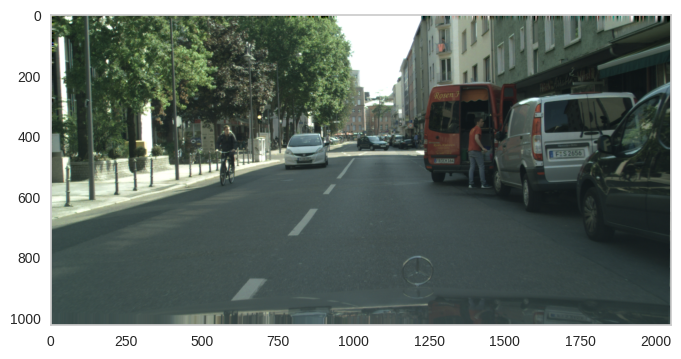

In [204]:
img, lbl = cityscapes_dataset[43]# road_anomaly_dataset[58]
plt.imshow(img.permute(1, 2, 0))
plt.show()

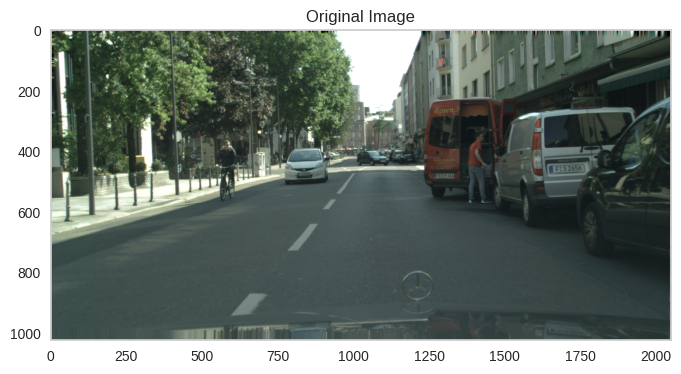

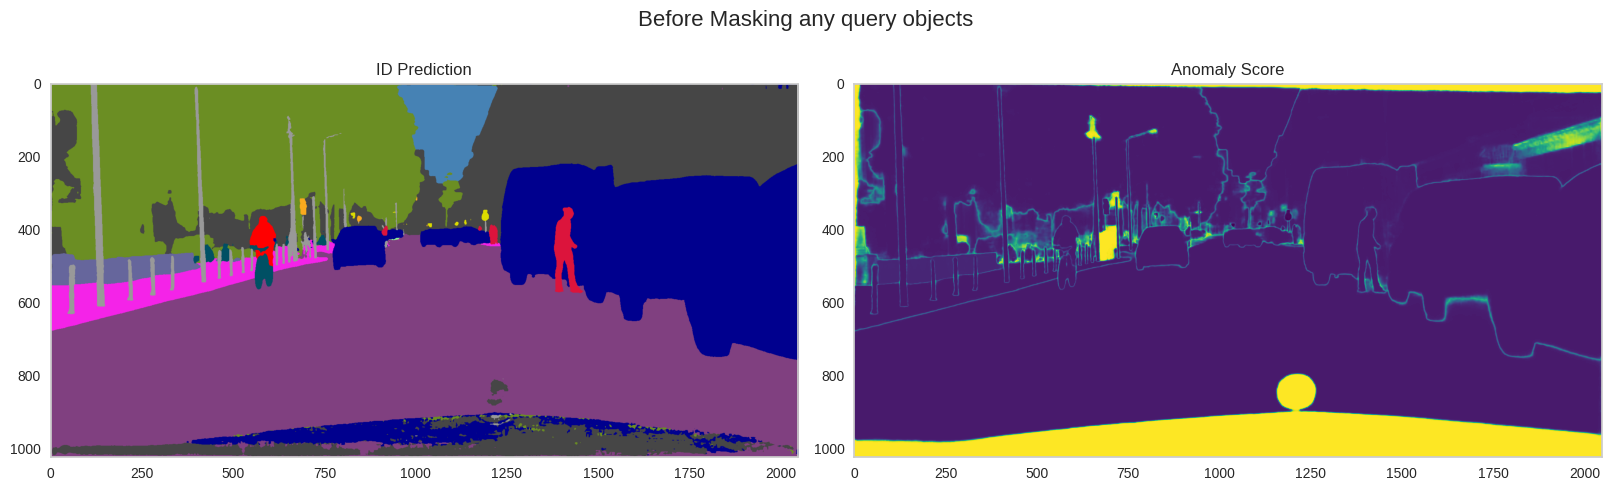

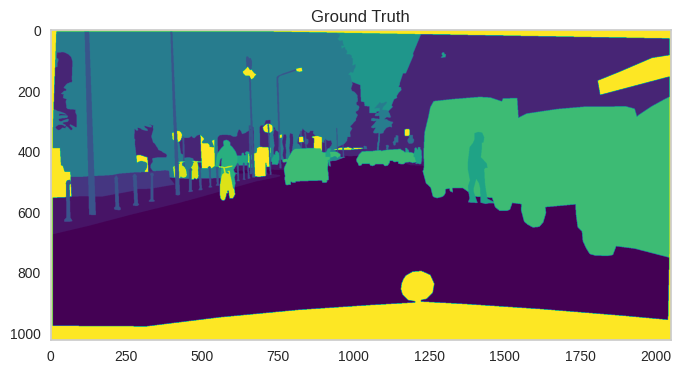

<ipython-input-202-cca416154613>:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(prob_logits[i, :19])


Road Prob tensor(0.0005, device='cuda:0')


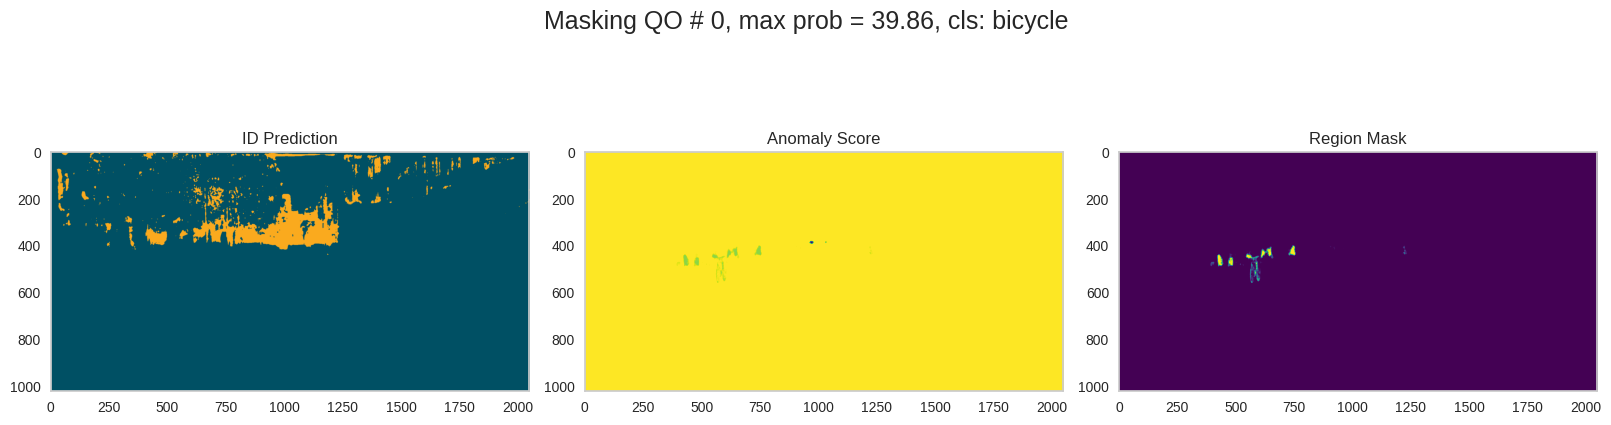

Road Prob tensor(0.0003, device='cuda:0')


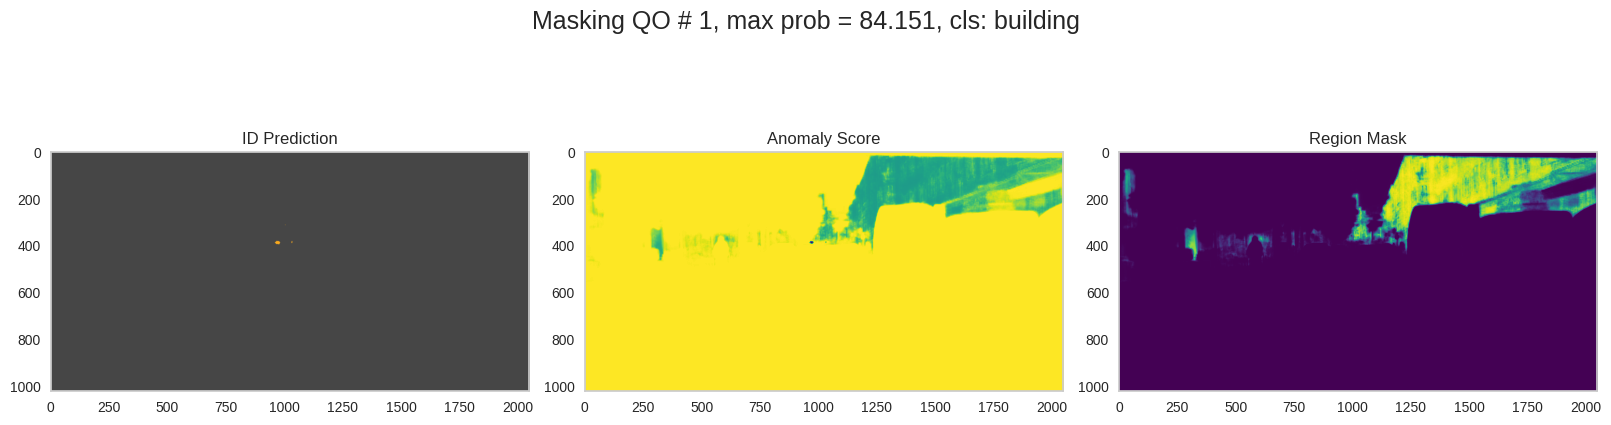

Road Prob tensor(0.0070, device='cuda:0')


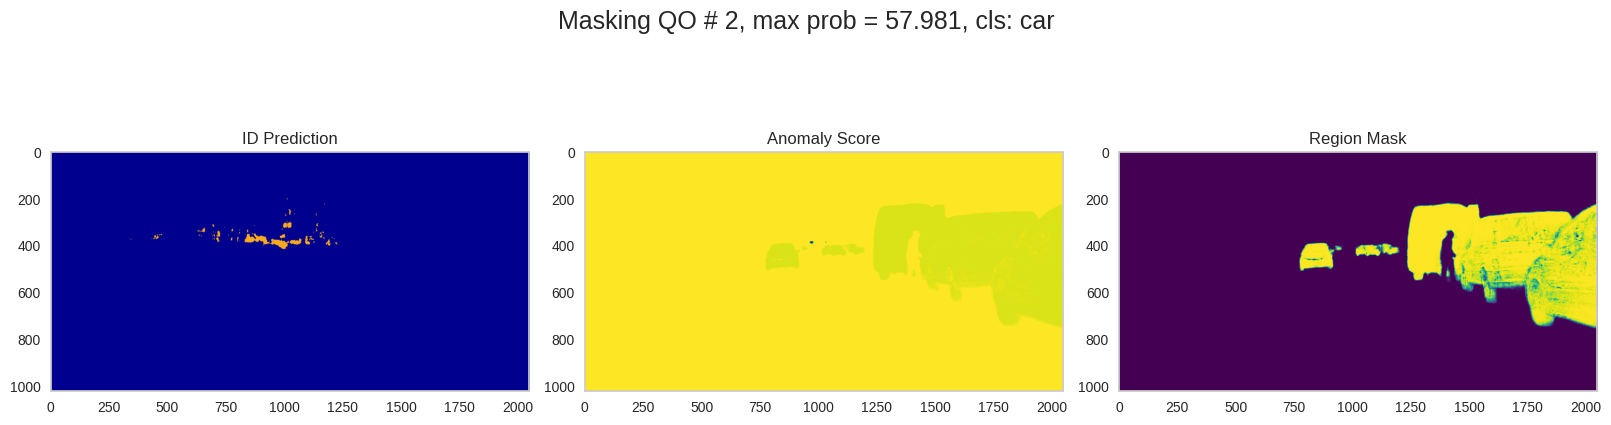

Road Prob tensor(0.0007, device='cuda:0')


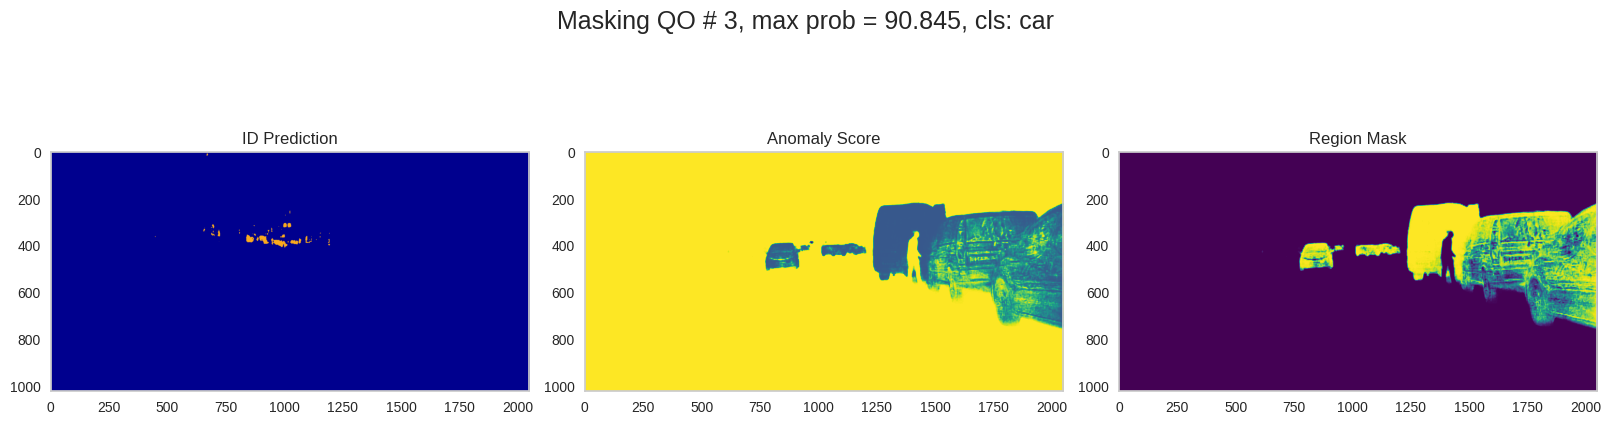

Road Prob tensor(0.0007, device='cuda:0')


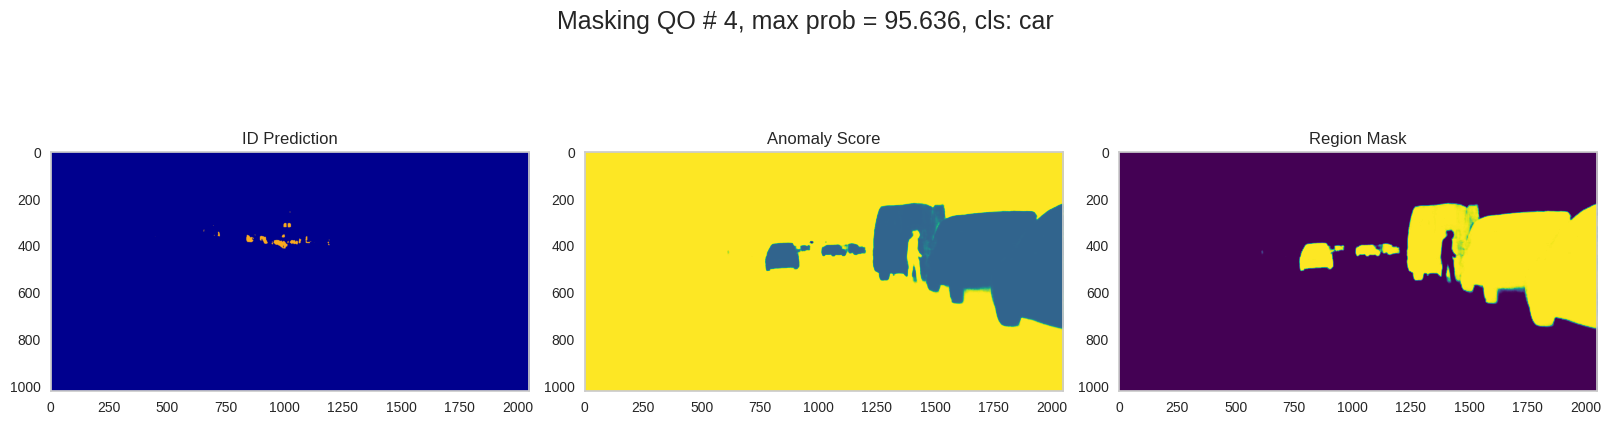

Road Prob tensor(0.0203, device='cuda:0')


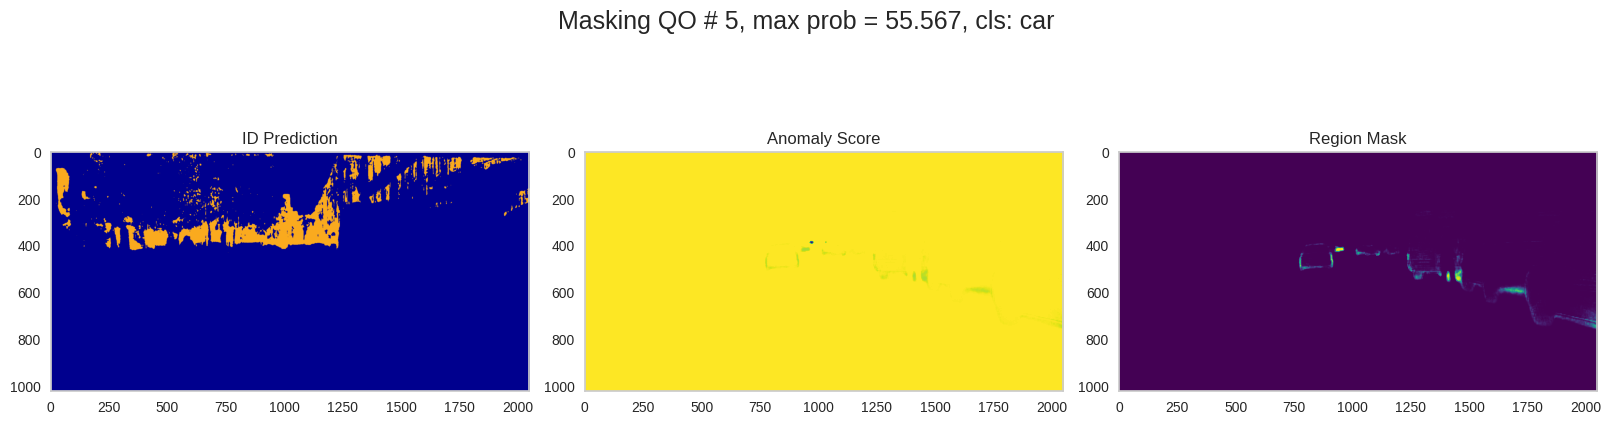

Road Prob tensor(0.0002, device='cuda:0')


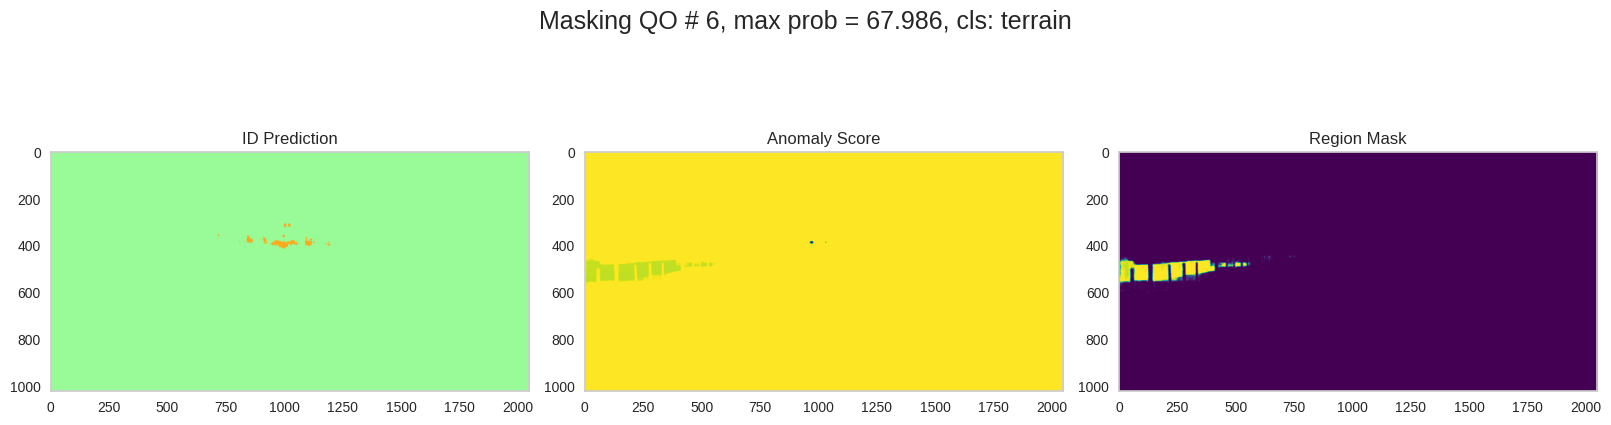

Road Prob tensor(0.0018, device='cuda:0')


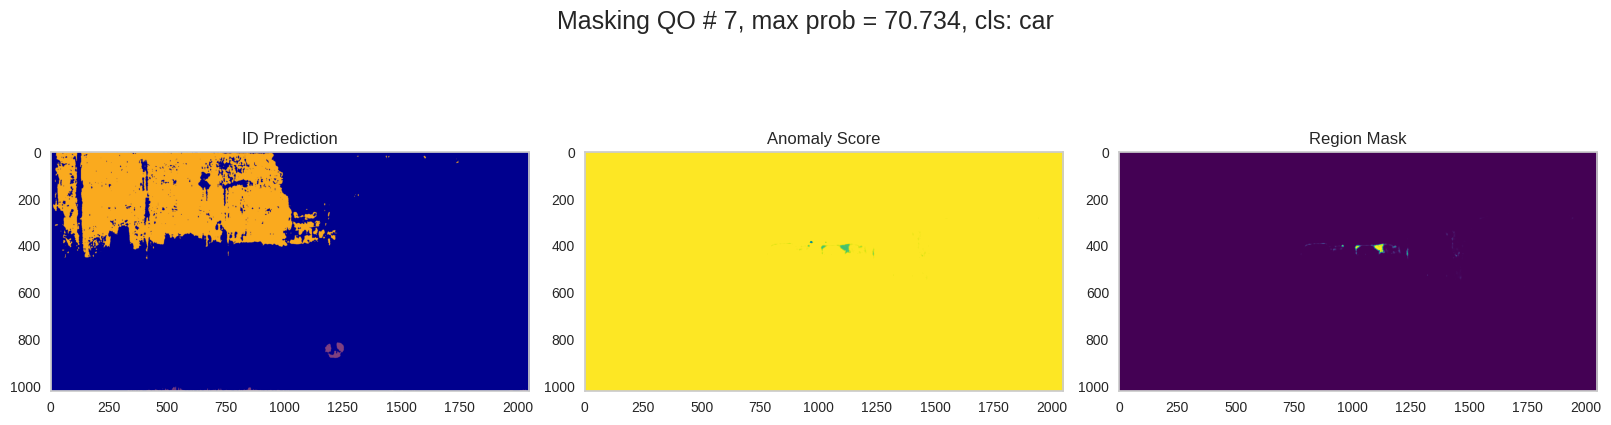

Road Prob tensor(0.0016, device='cuda:0')


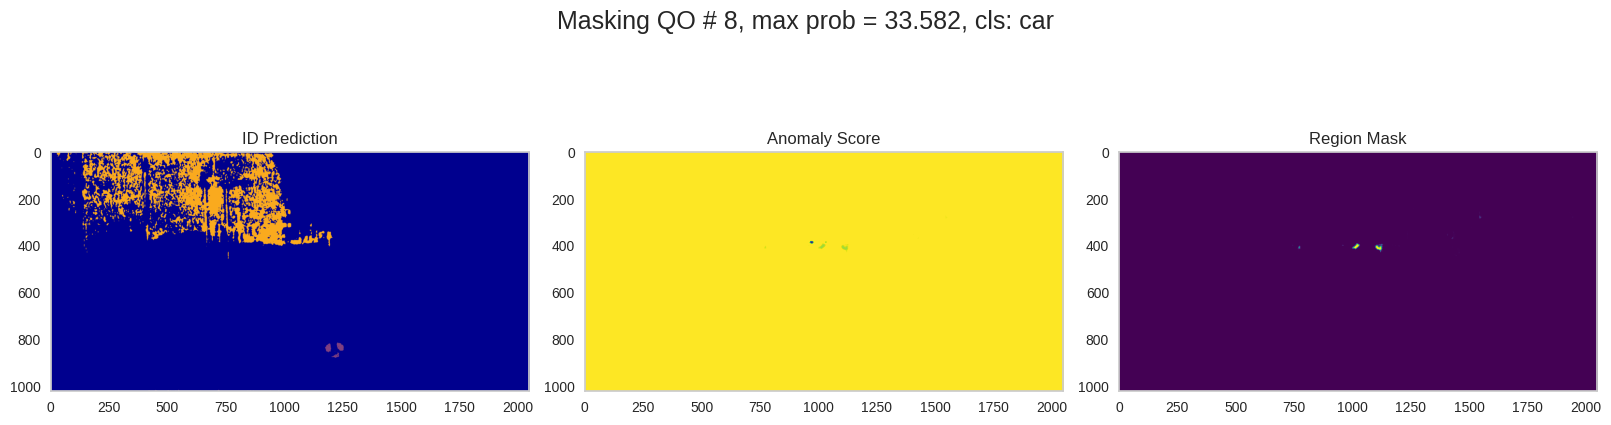

Road Prob tensor(2.6109e-05, device='cuda:0')


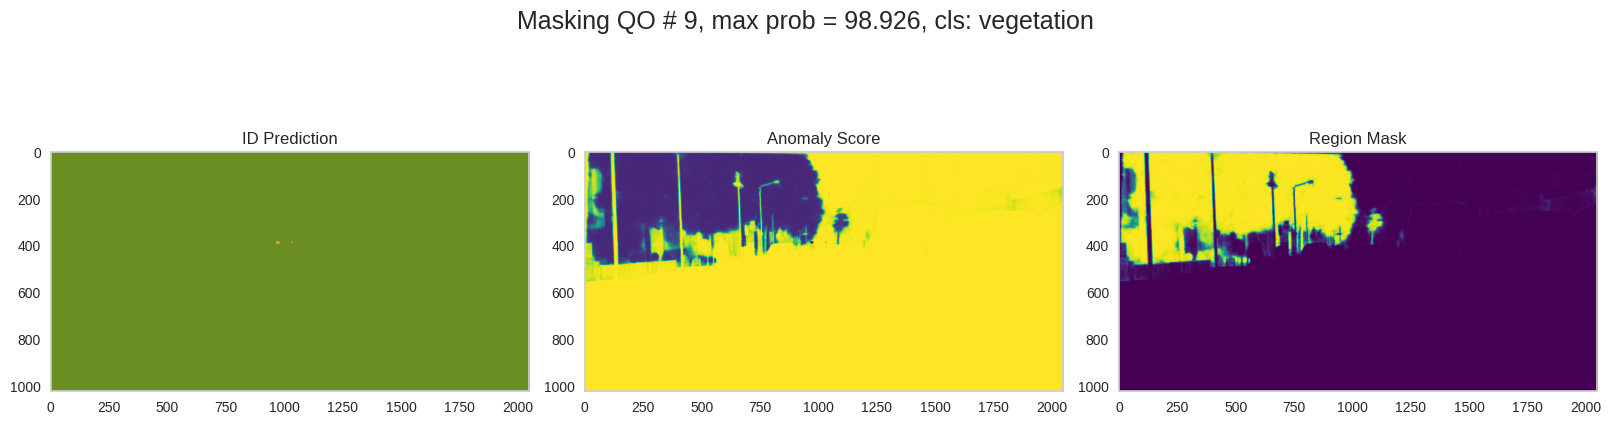

Road Prob tensor(6.2543e-06, device='cuda:0')


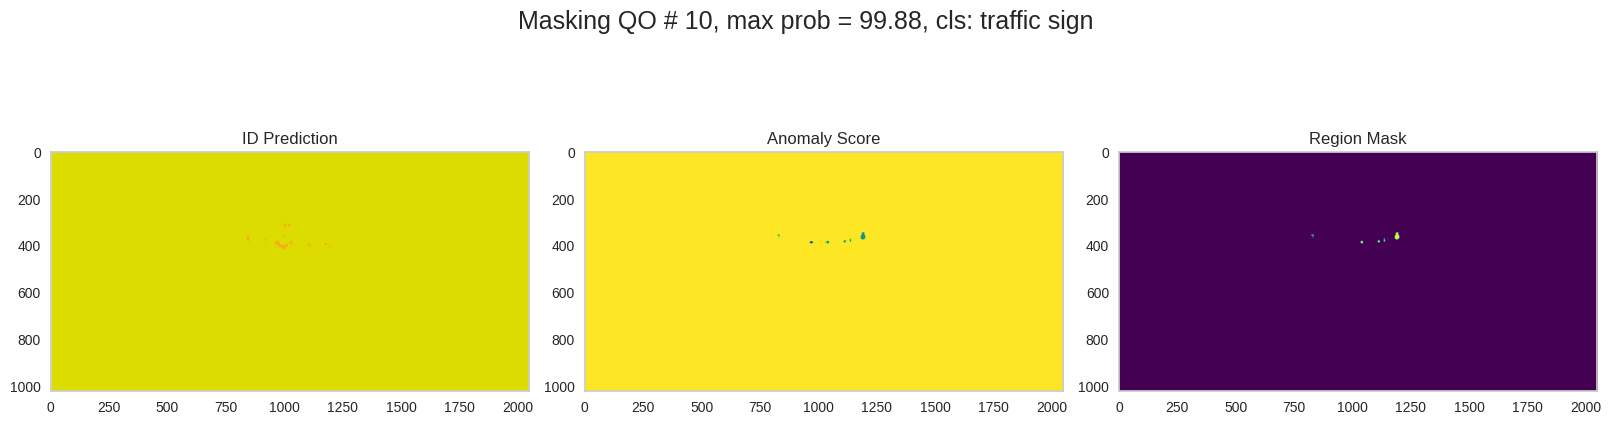

Road Prob tensor(0.0148, device='cuda:0')


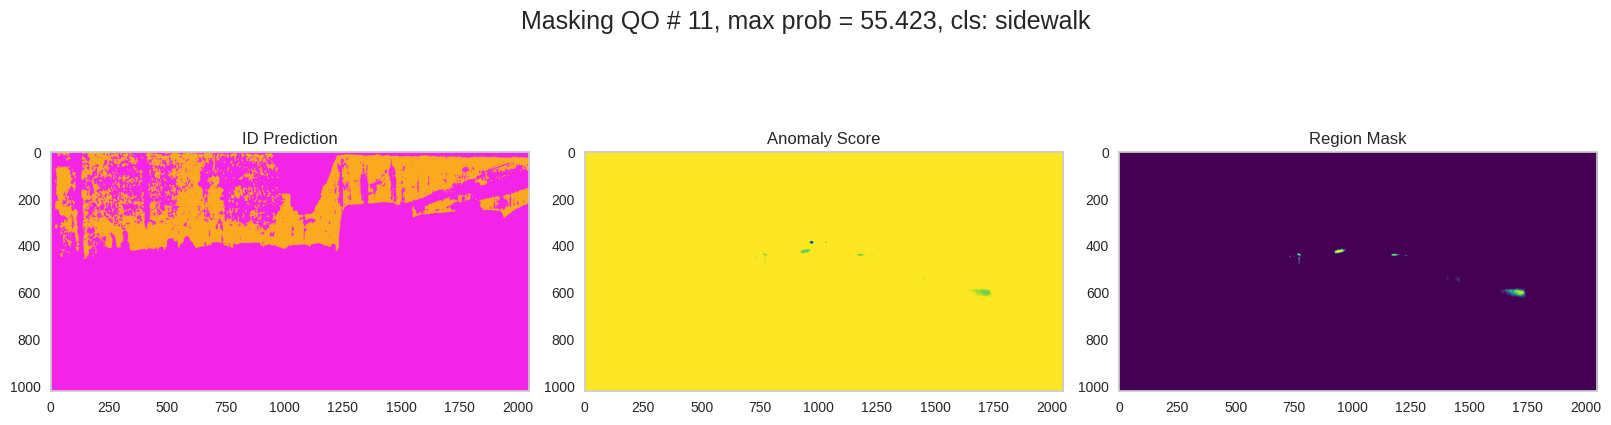

Road Prob tensor(0.0013, device='cuda:0')


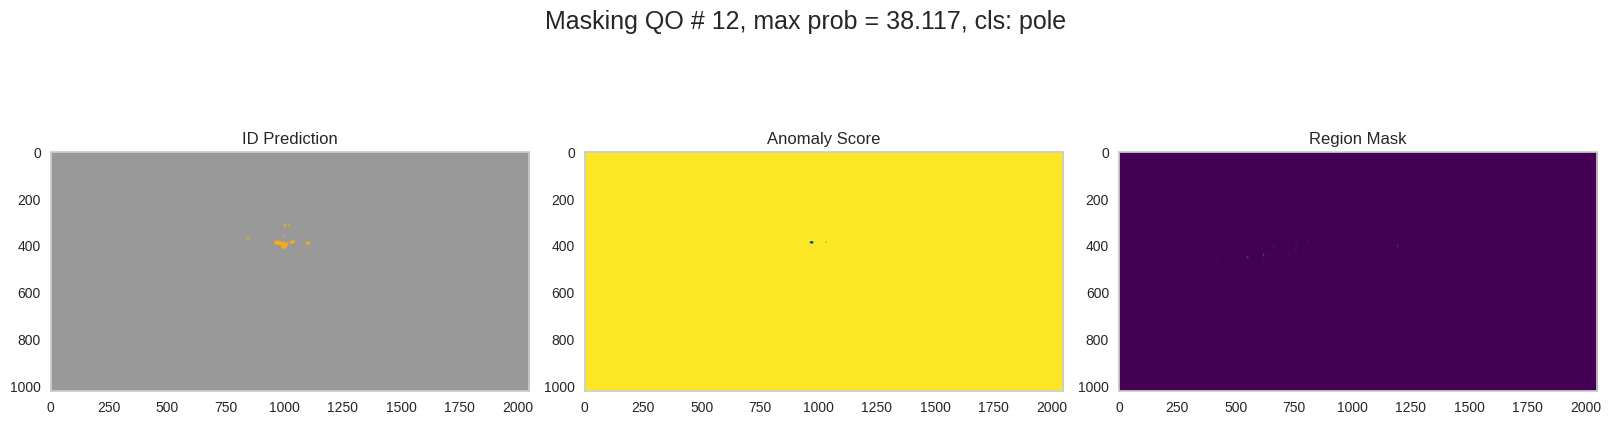

Road Prob tensor(0.0002, device='cuda:0')


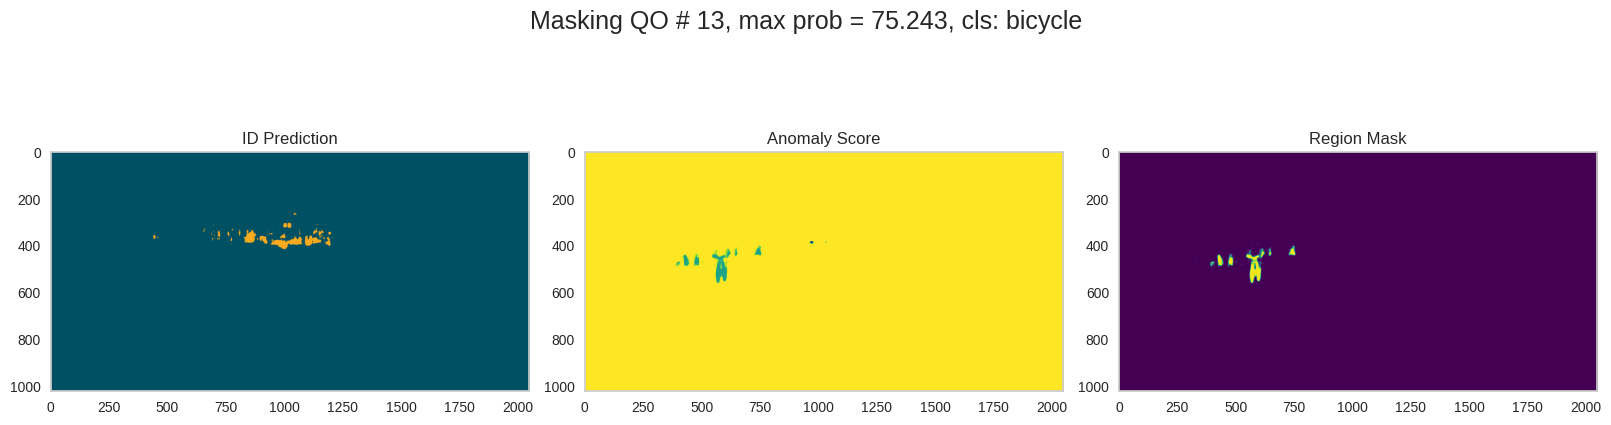

Road Prob tensor(0.0039, device='cuda:0')


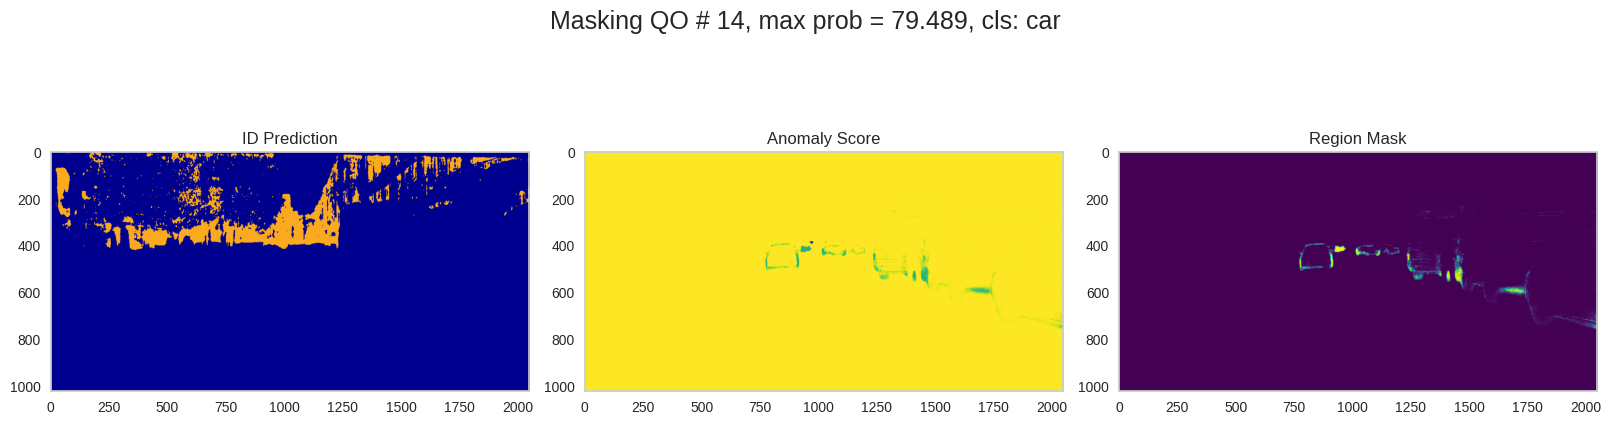

Road Prob tensor(0.0002, device='cuda:0')


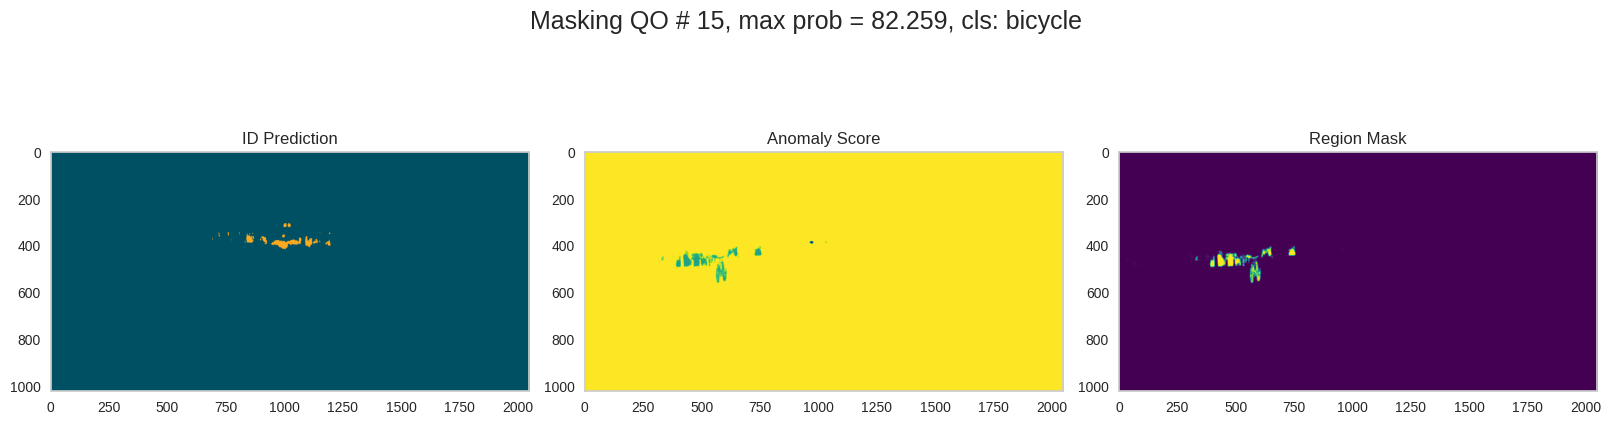

Road Prob tensor(0.3845, device='cuda:0')


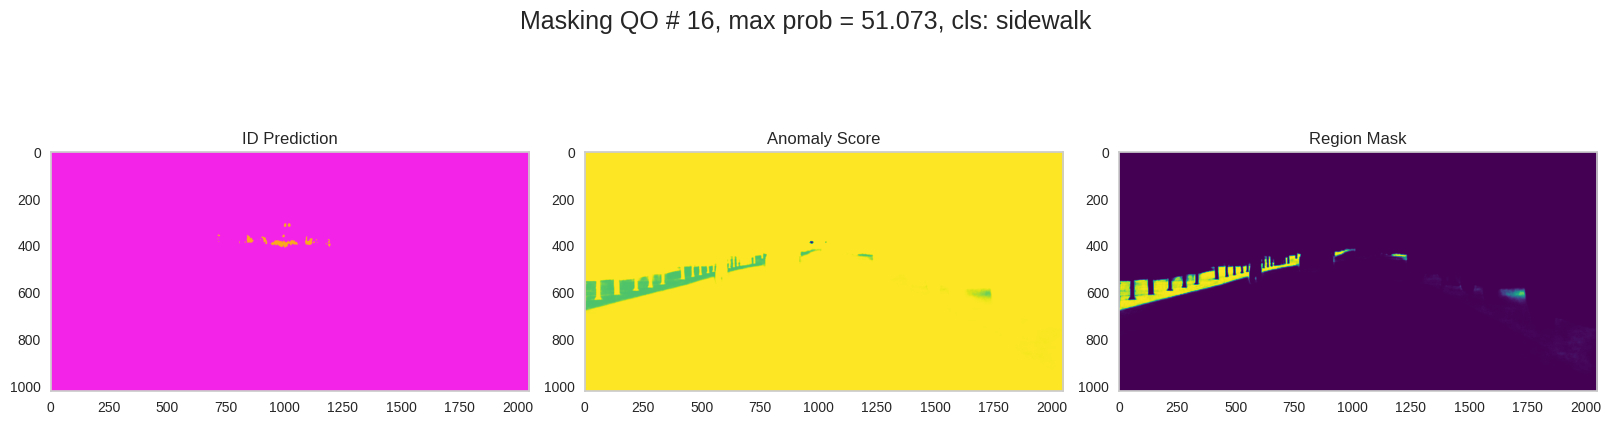

Road Prob tensor(0.0004, device='cuda:0')


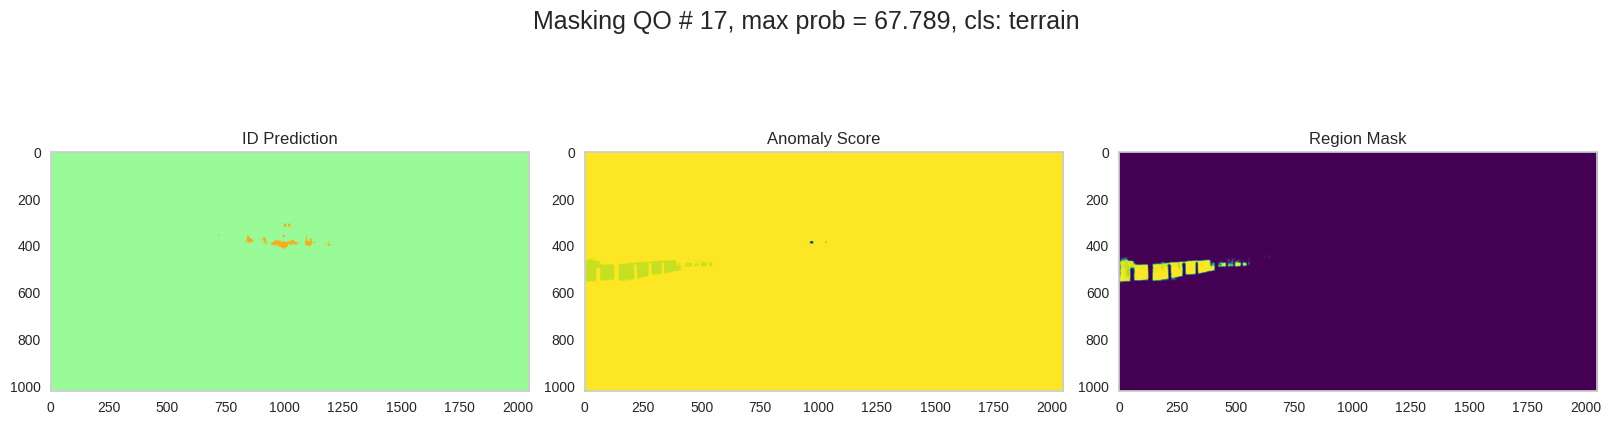

Road Prob tensor(0.0214, device='cuda:0')


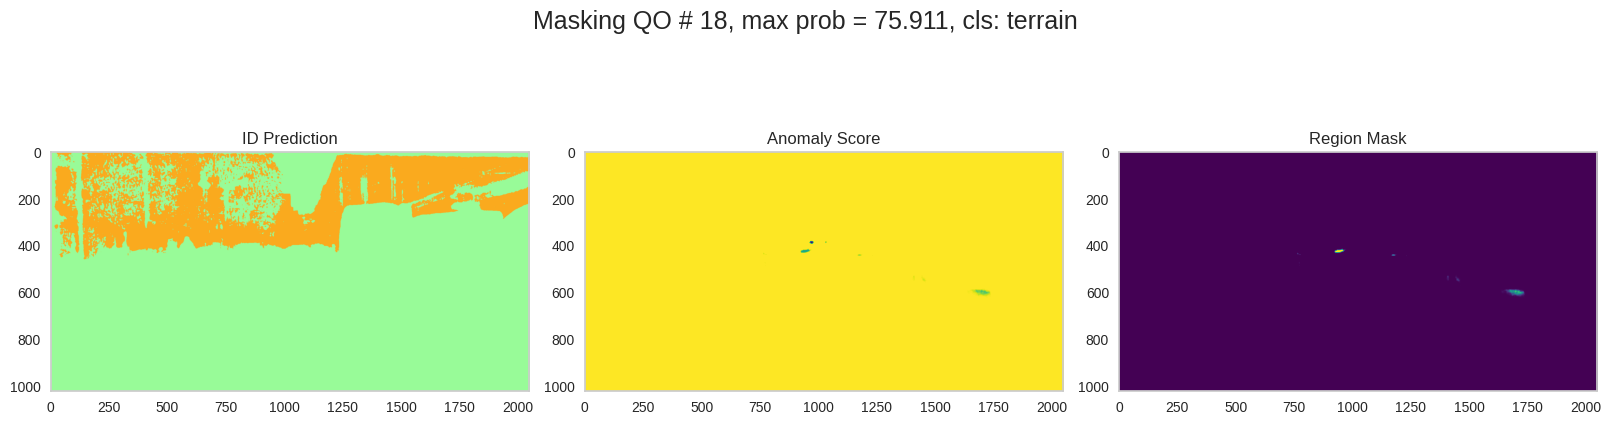

Road Prob tensor(0.0015, device='cuda:0')


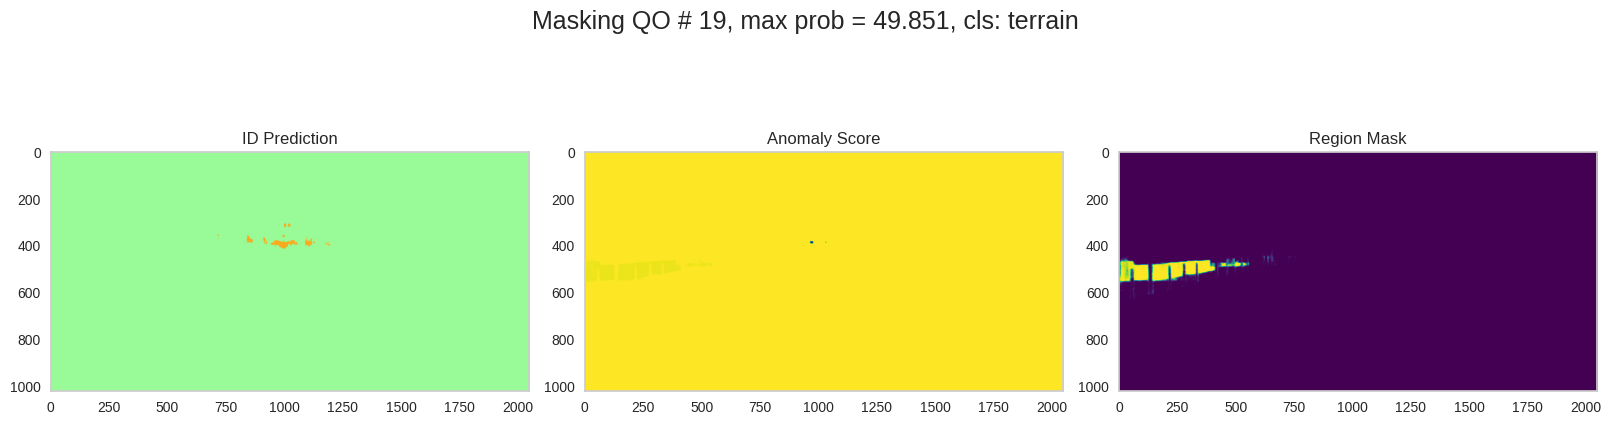

Road Prob tensor(0.0002, device='cuda:0')


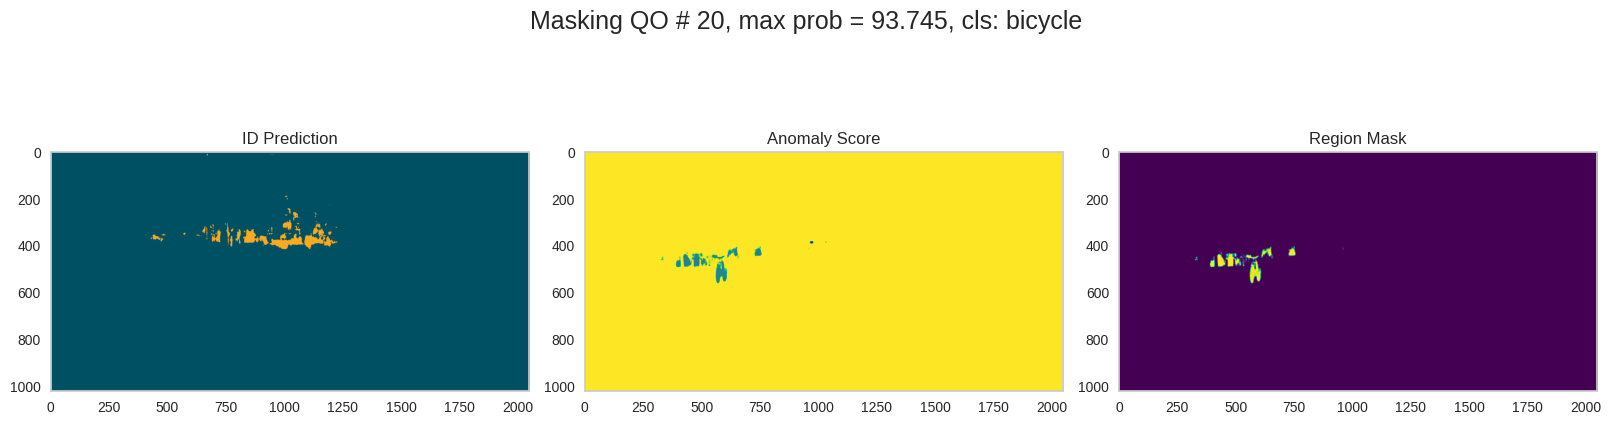

Road Prob tensor(0.0105, device='cuda:0')


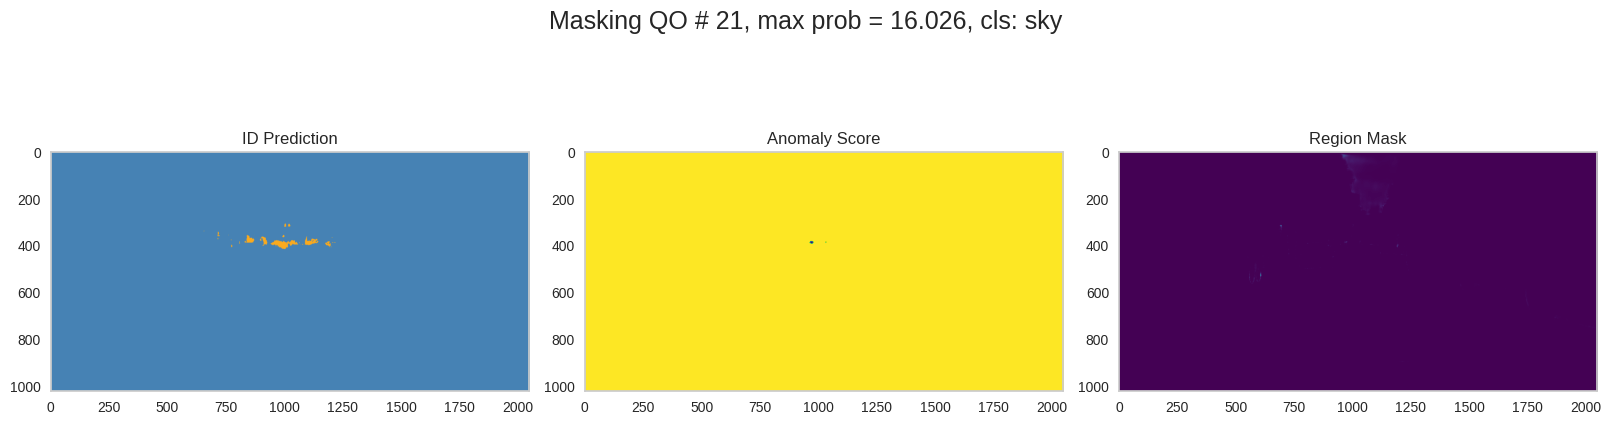

Road Prob tensor(0.0002, device='cuda:0')


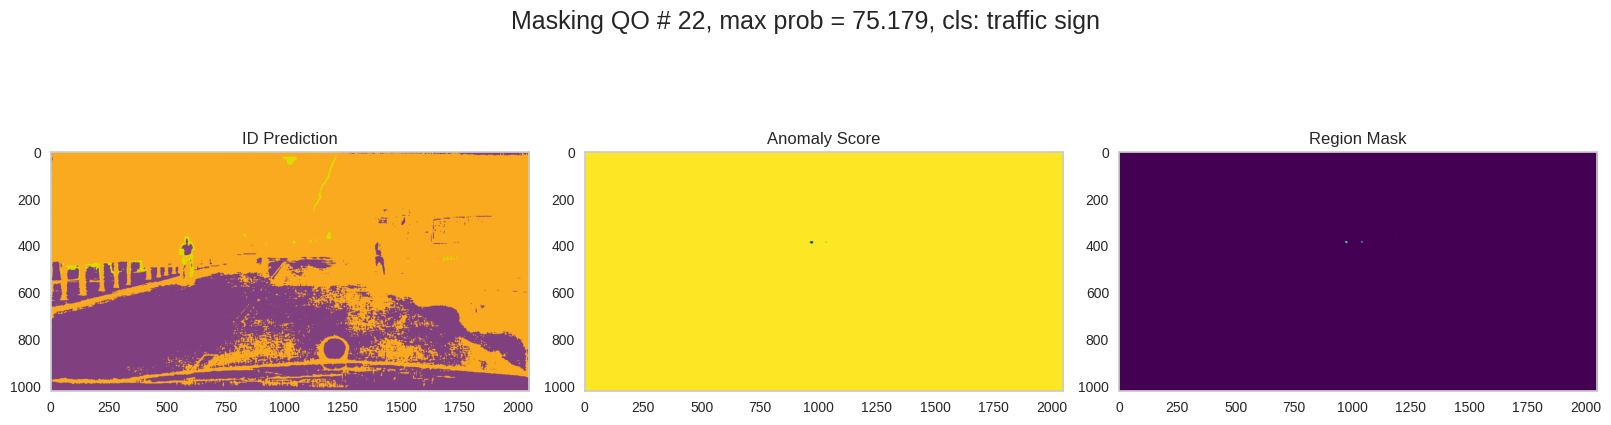

Road Prob tensor(2.2814e-05, device='cuda:0')


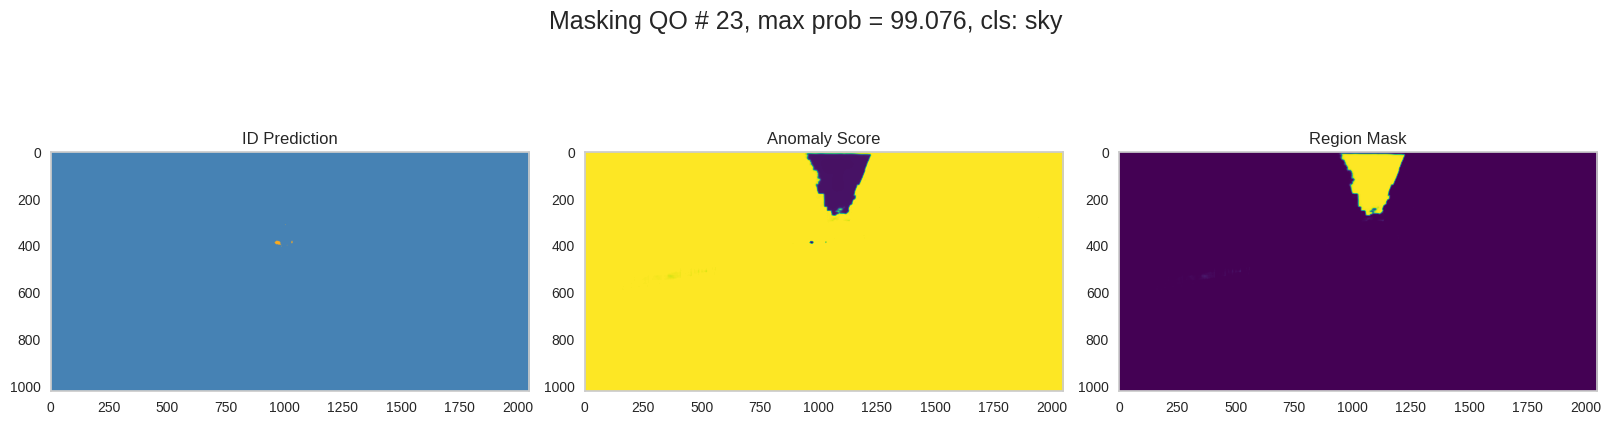

Road Prob tensor(0.0013, device='cuda:0')


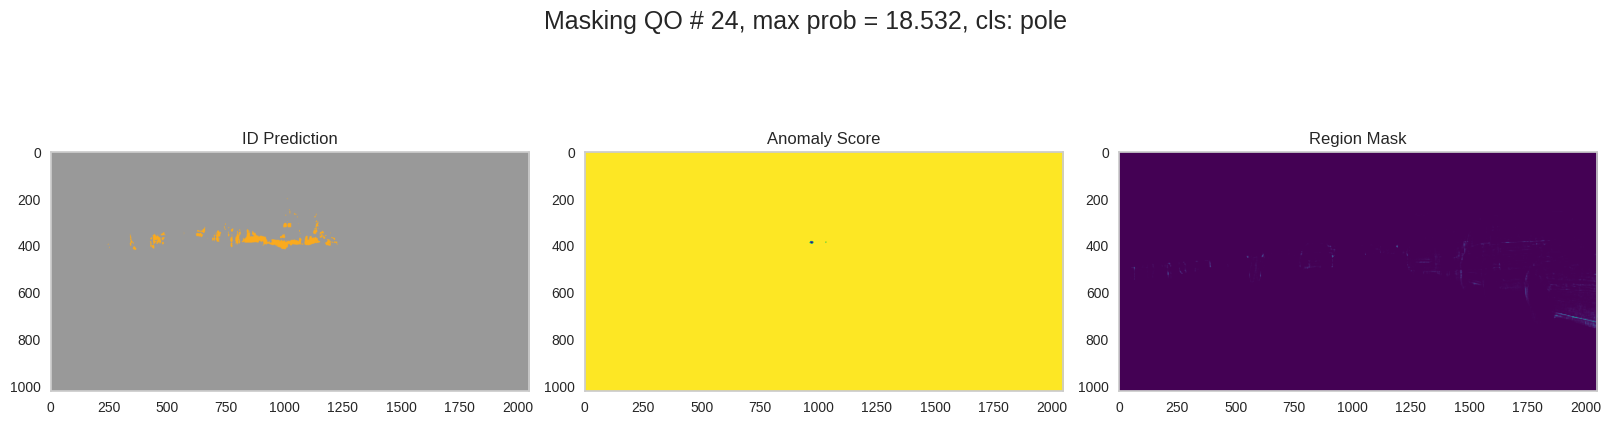

Road Prob tensor(1.5696e-06, device='cuda:0')


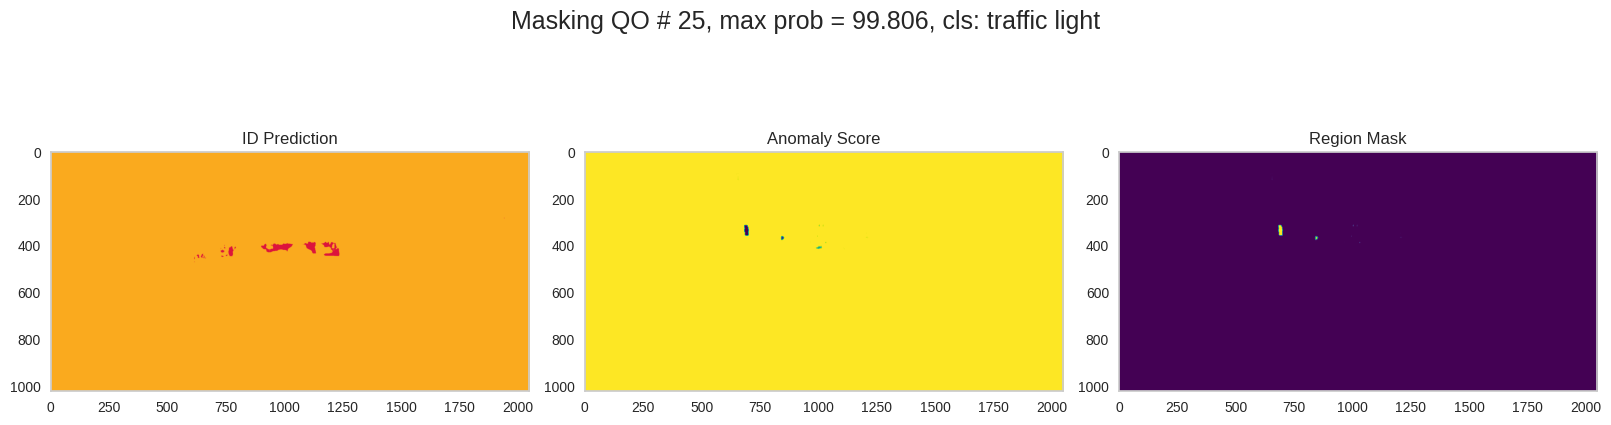

Road Prob tensor(0.0028, device='cuda:0')


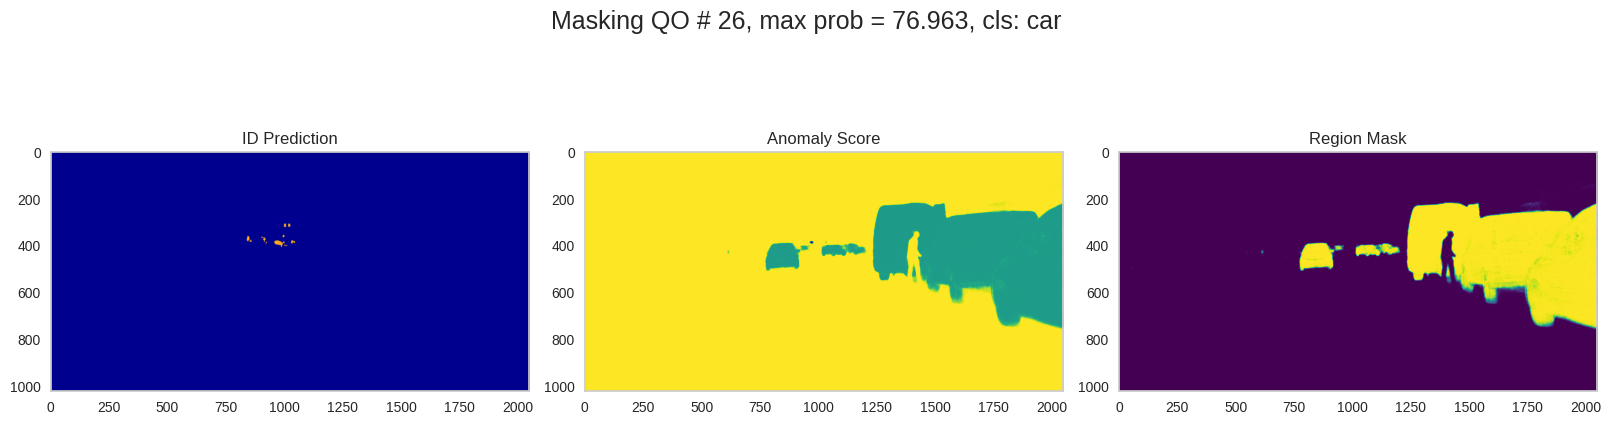

Road Prob tensor(0.0007, device='cuda:0')


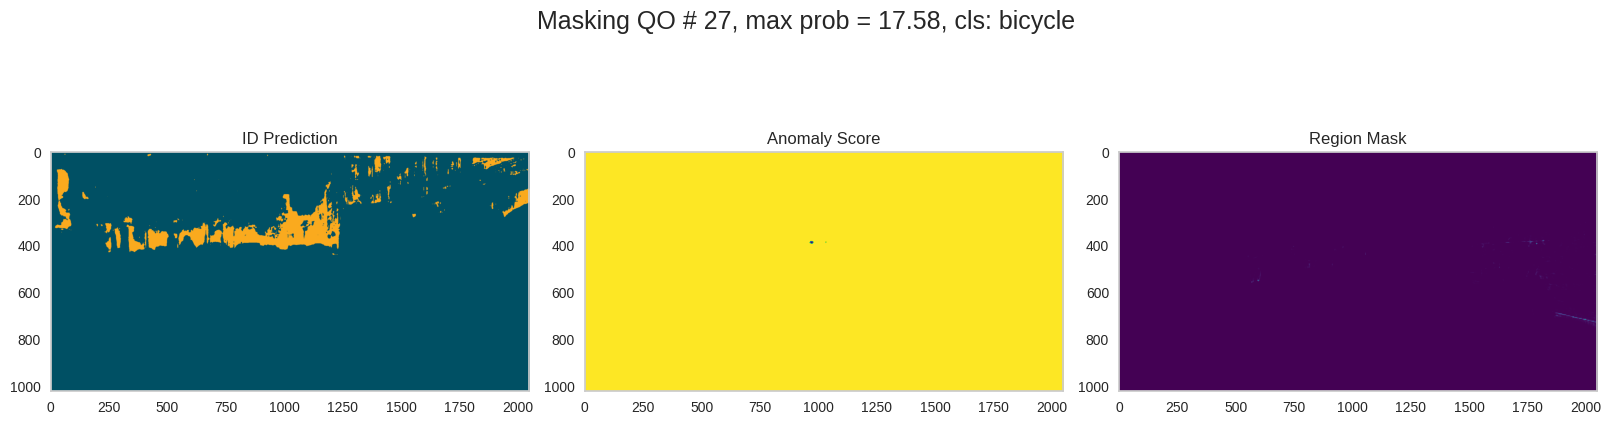

Road Prob tensor(0.0043, device='cuda:0')


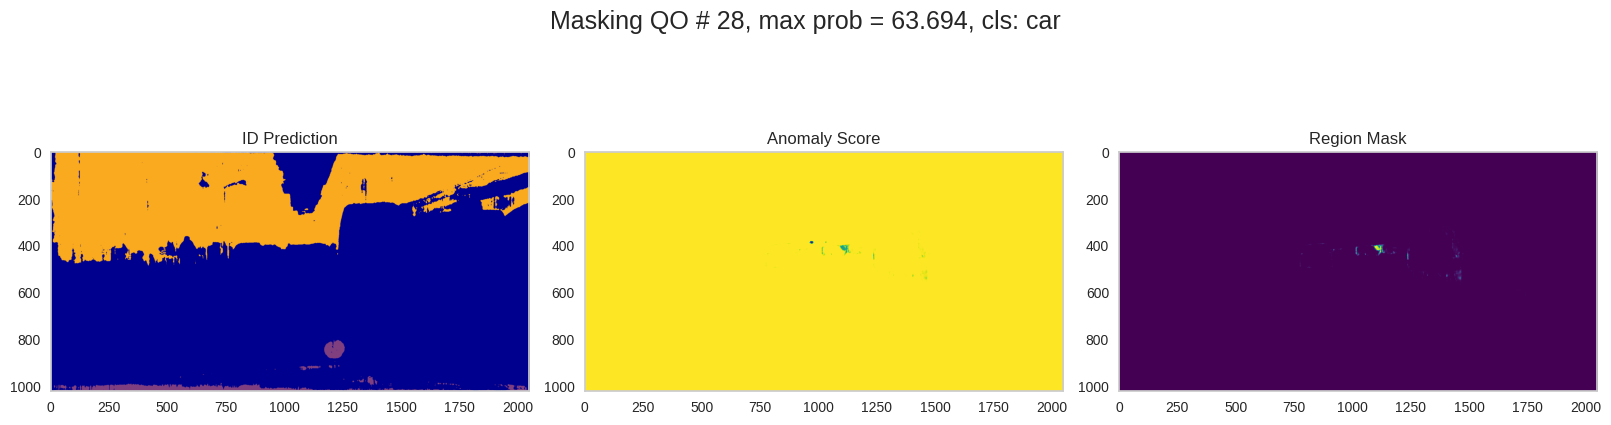

Road Prob tensor(0.0014, device='cuda:0')


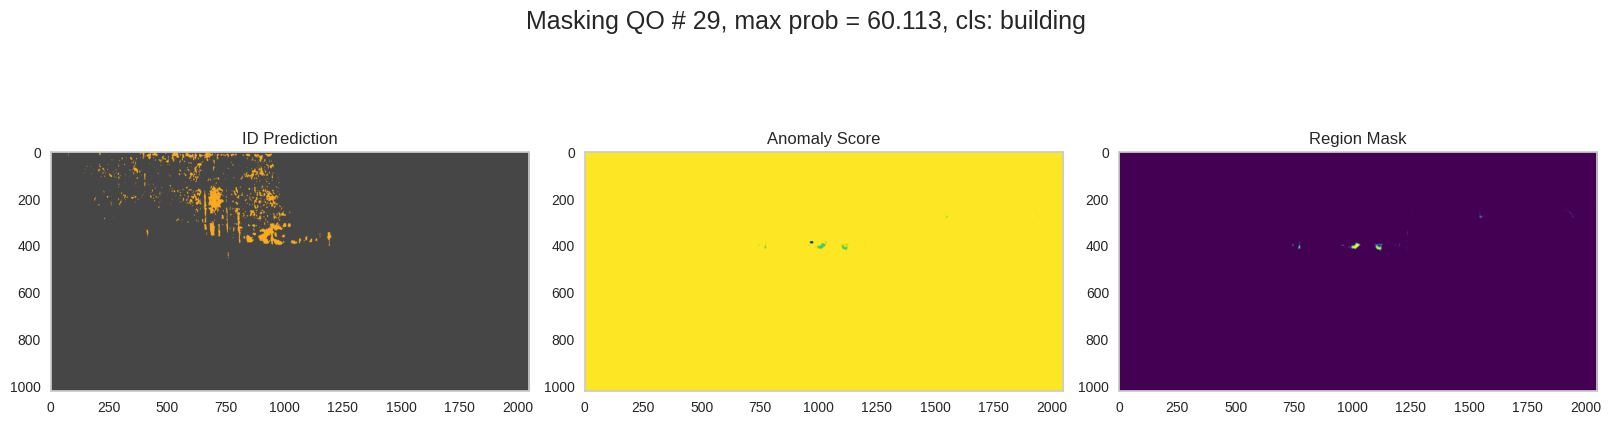

Road Prob tensor(0.0009, device='cuda:0')


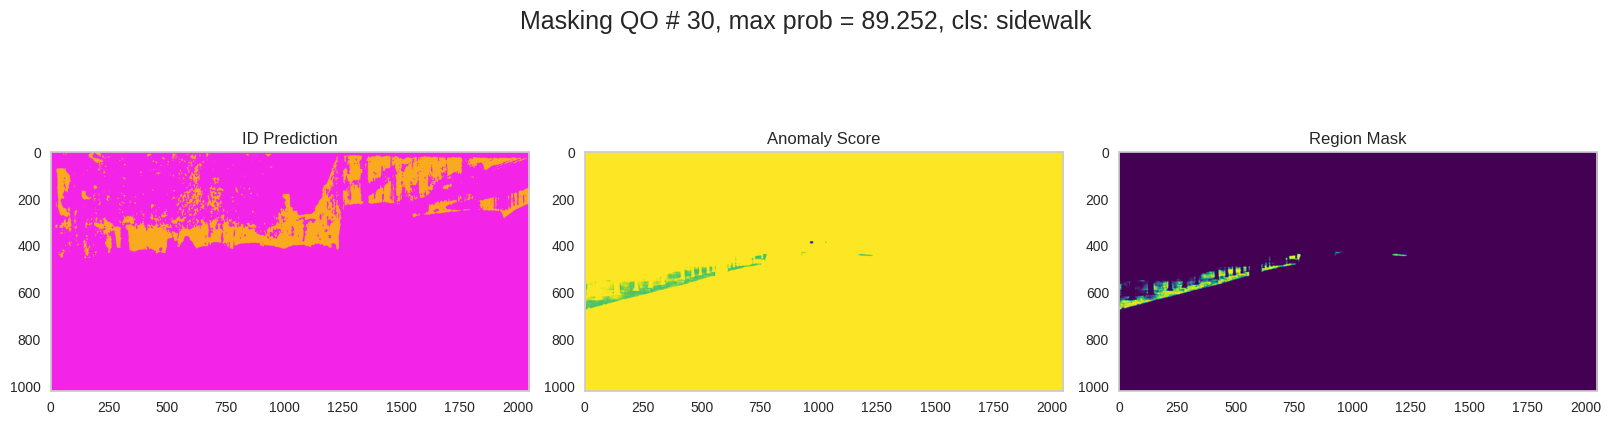

Road Prob tensor(1.4232e-05, device='cuda:0')


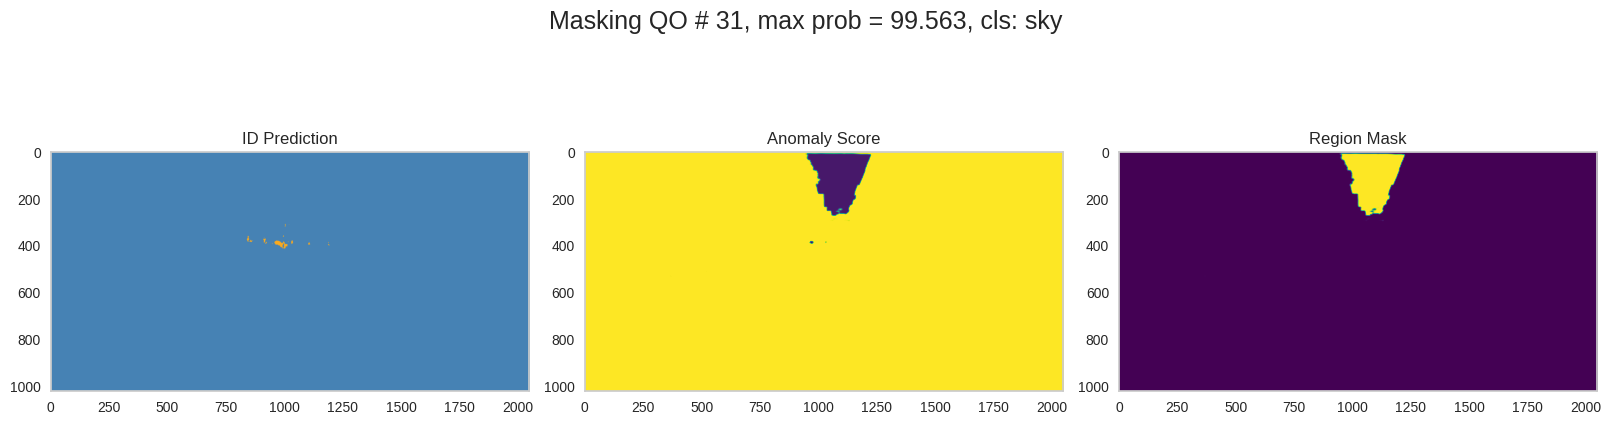

Road Prob tensor(0.0016, device='cuda:0')


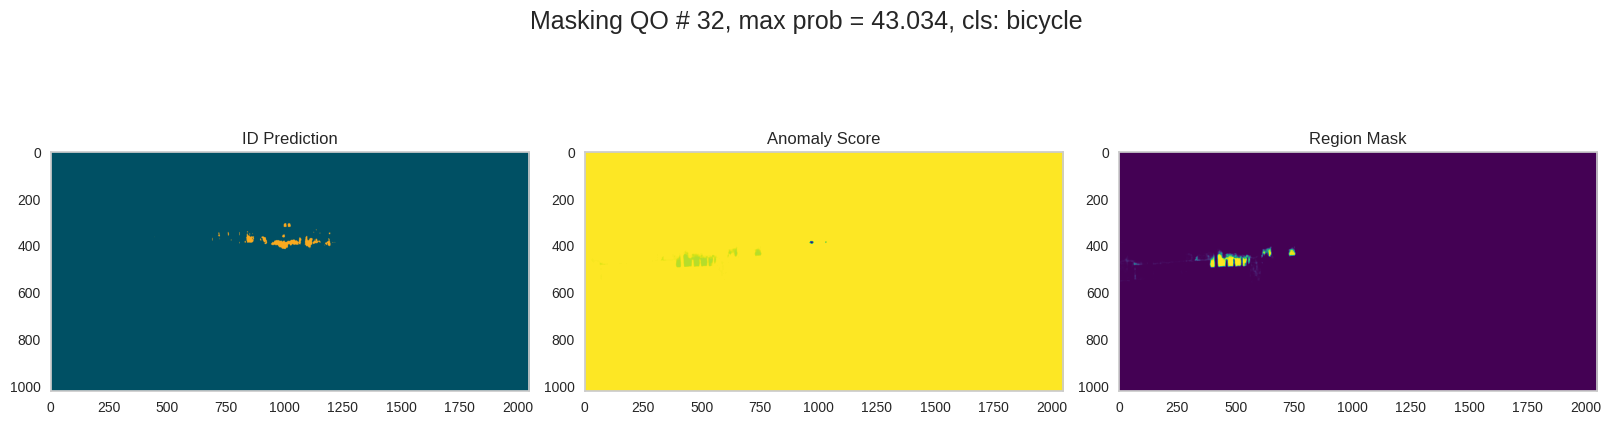

Road Prob tensor(0.0003, device='cuda:0')


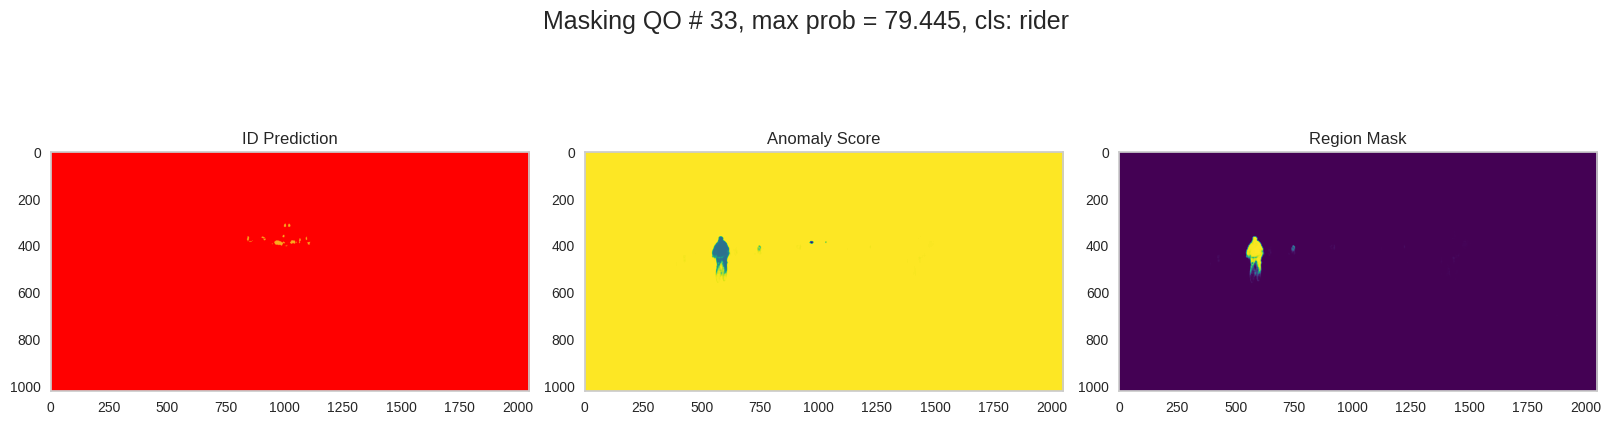

Road Prob tensor(0.0013, device='cuda:0')


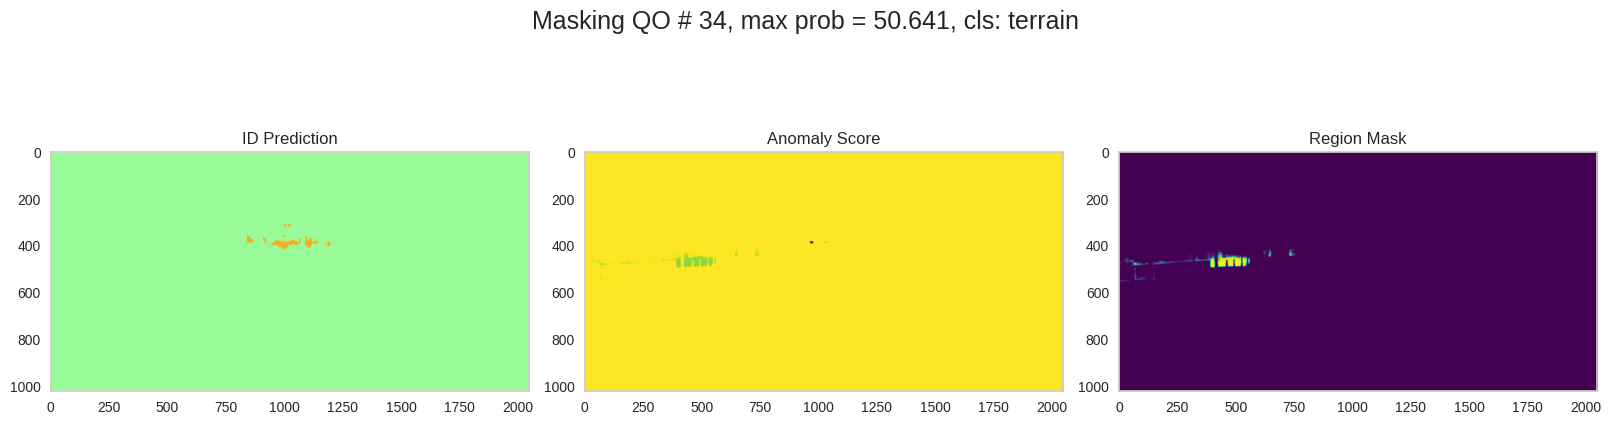

Road Prob tensor(0.0003, device='cuda:0')


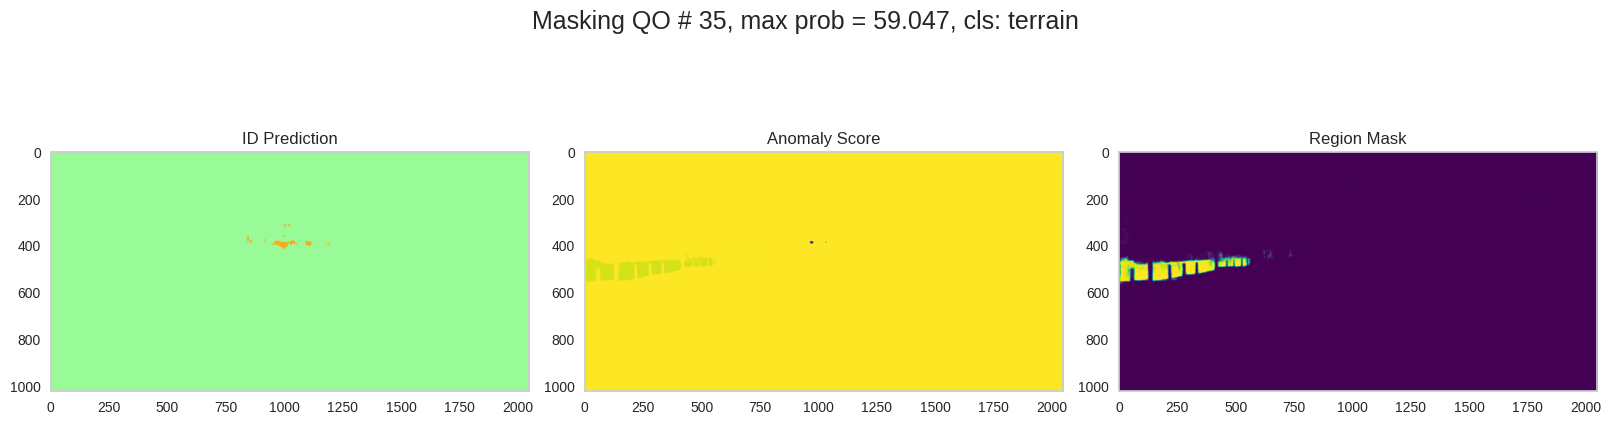

Road Prob tensor(0.0016, device='cuda:0')


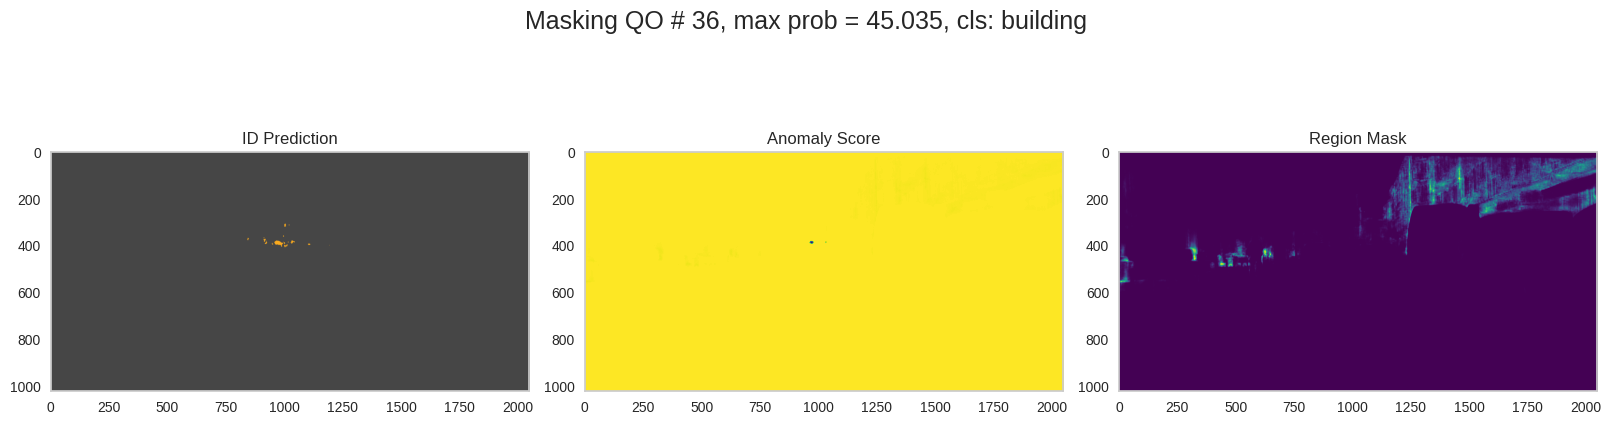

Road Prob tensor(0.0017, device='cuda:0')


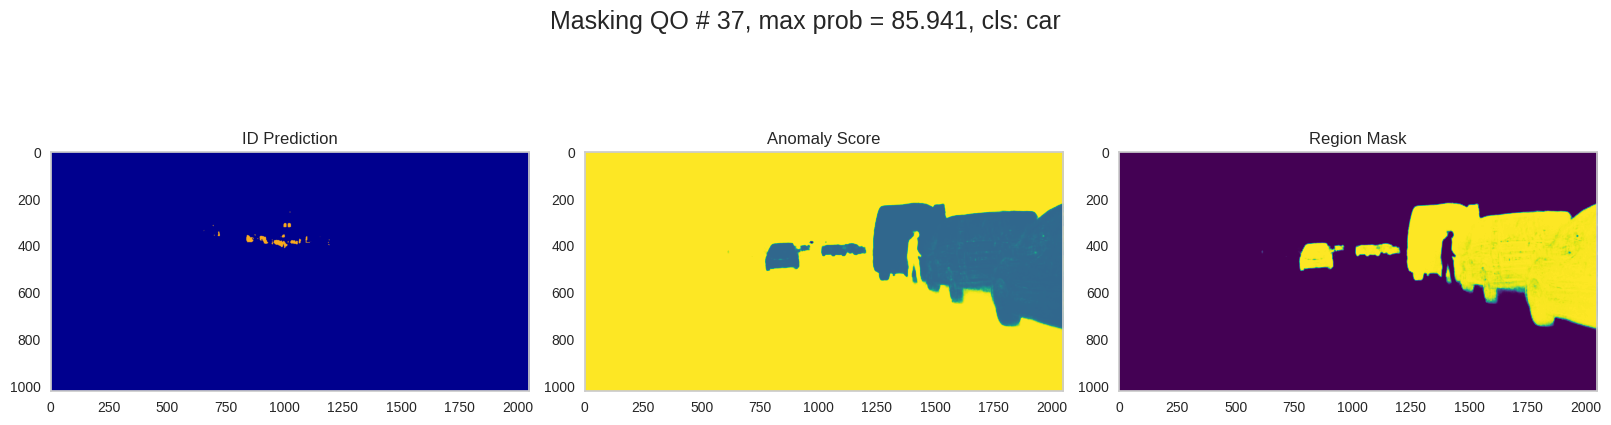

Road Prob tensor(0.0015, device='cuda:0')


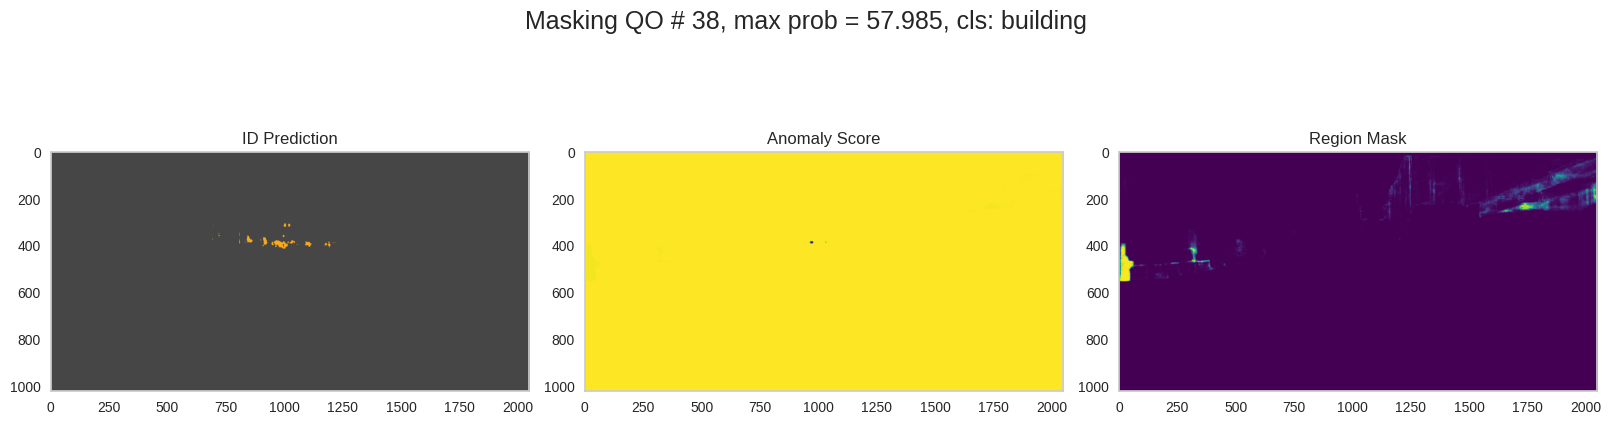

Road Prob tensor(0.0001, device='cuda:0')


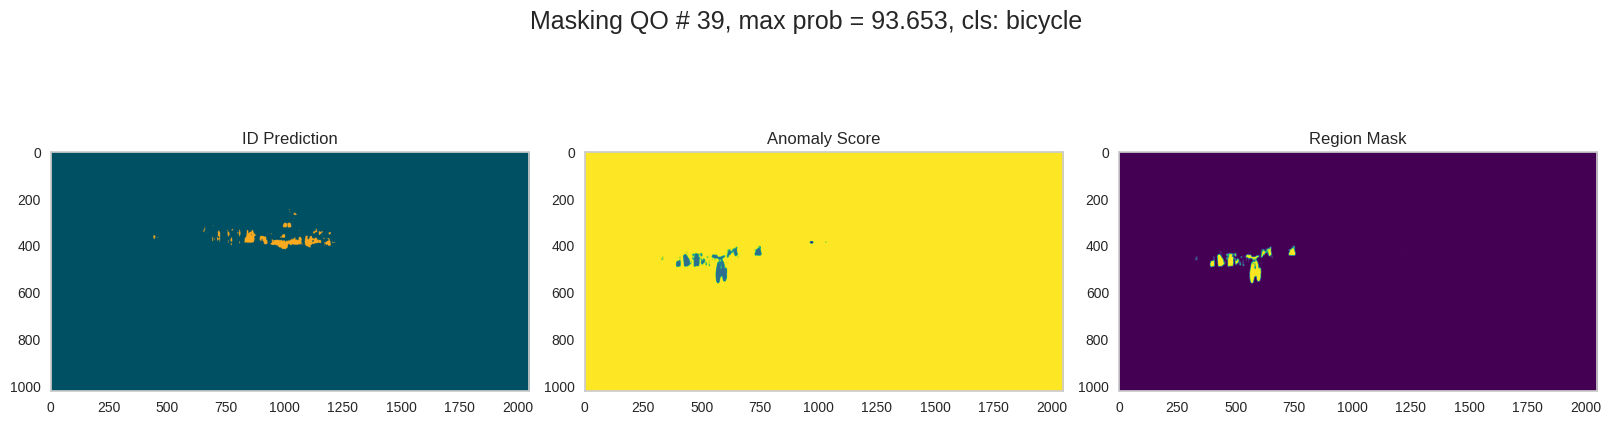

Road Prob tensor(0.0007, device='cuda:0')


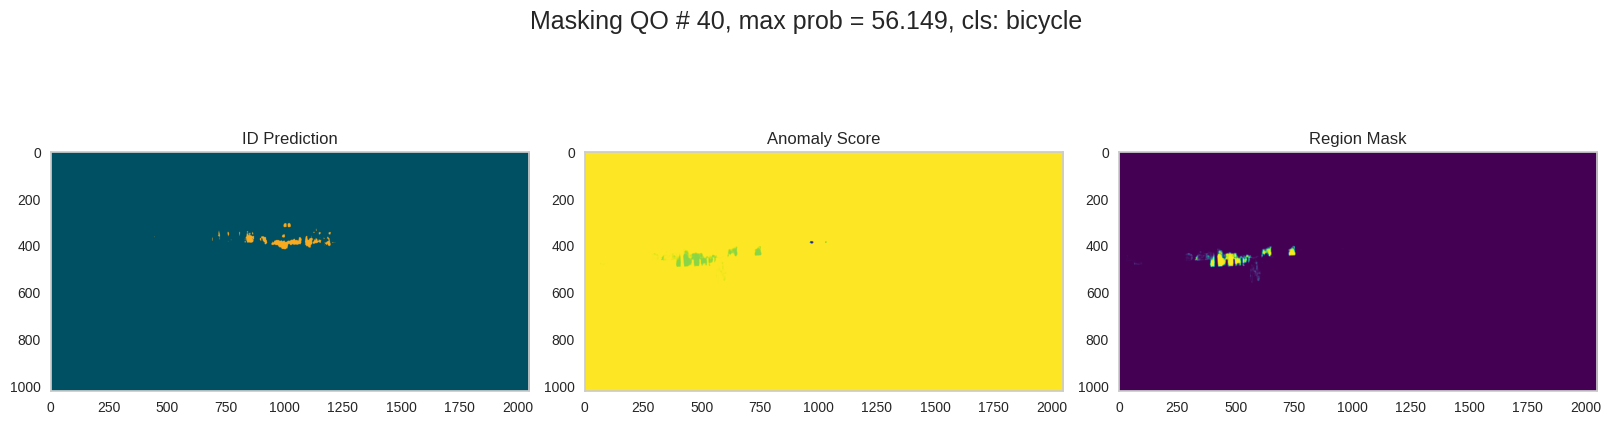

Road Prob tensor(0.0007, device='cuda:0')


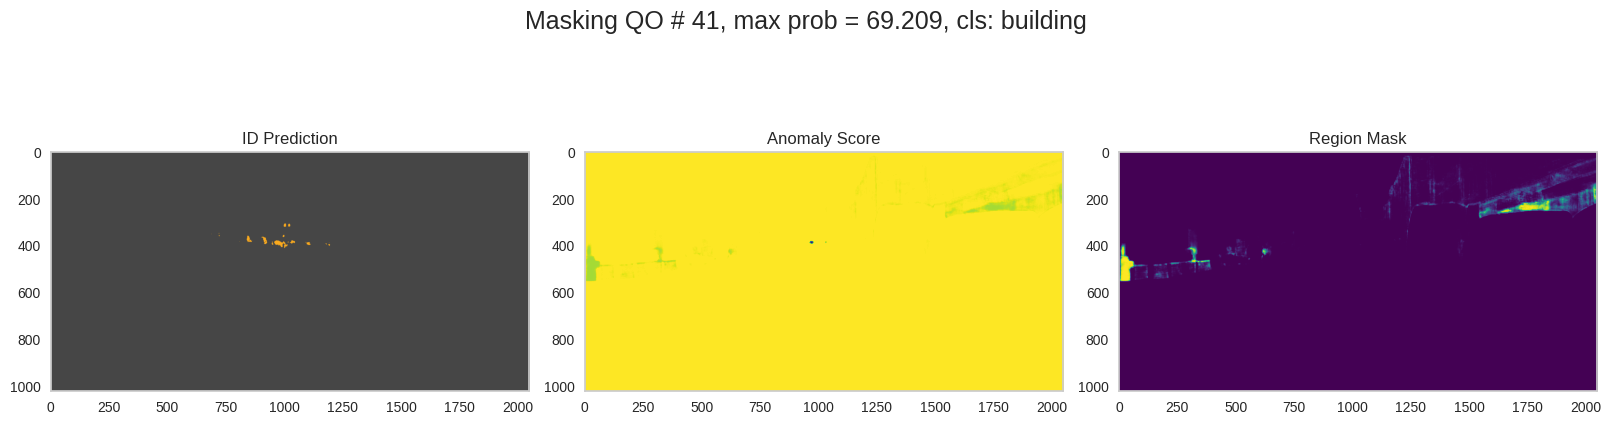

Road Prob tensor(4.2202e-05, device='cuda:0')


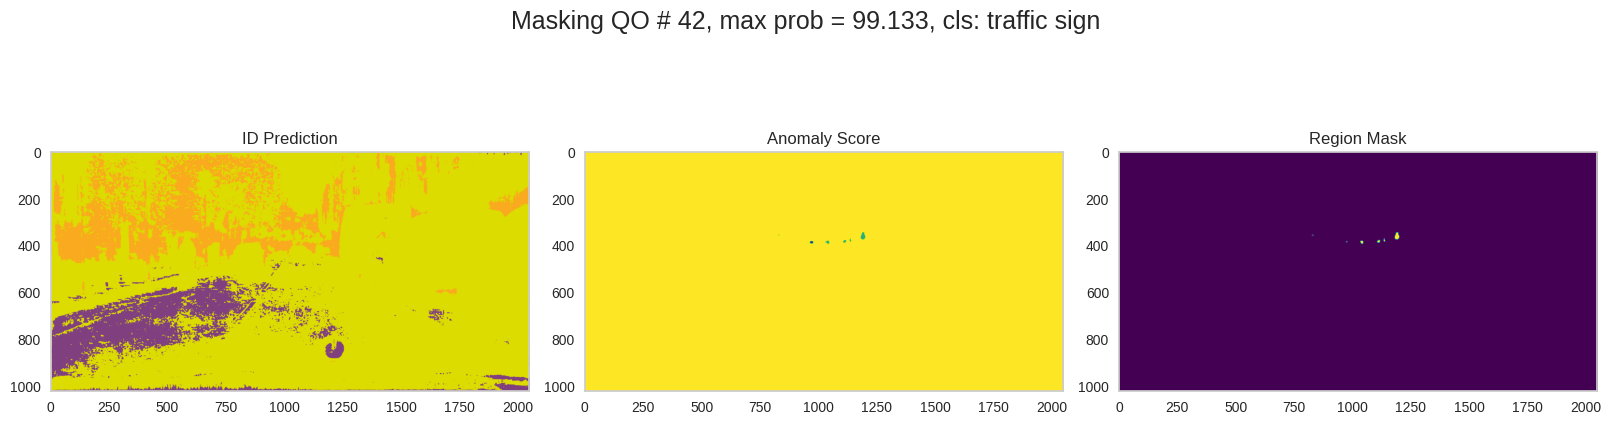

Road Prob tensor(0.0014, device='cuda:0')


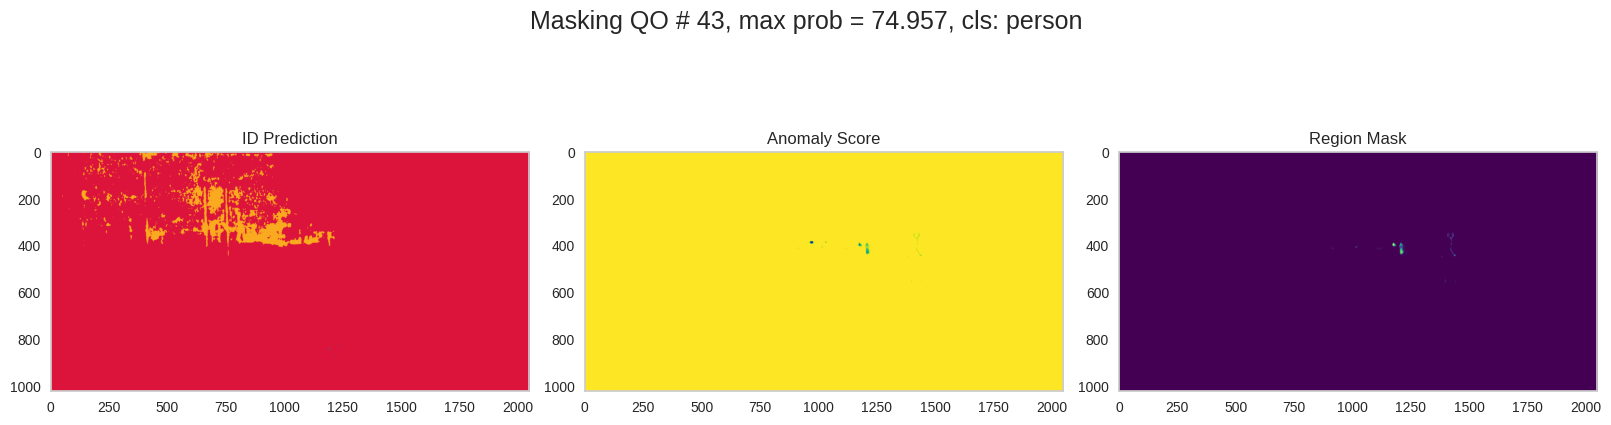

Road Prob tensor(1.0806e-05, device='cuda:0')


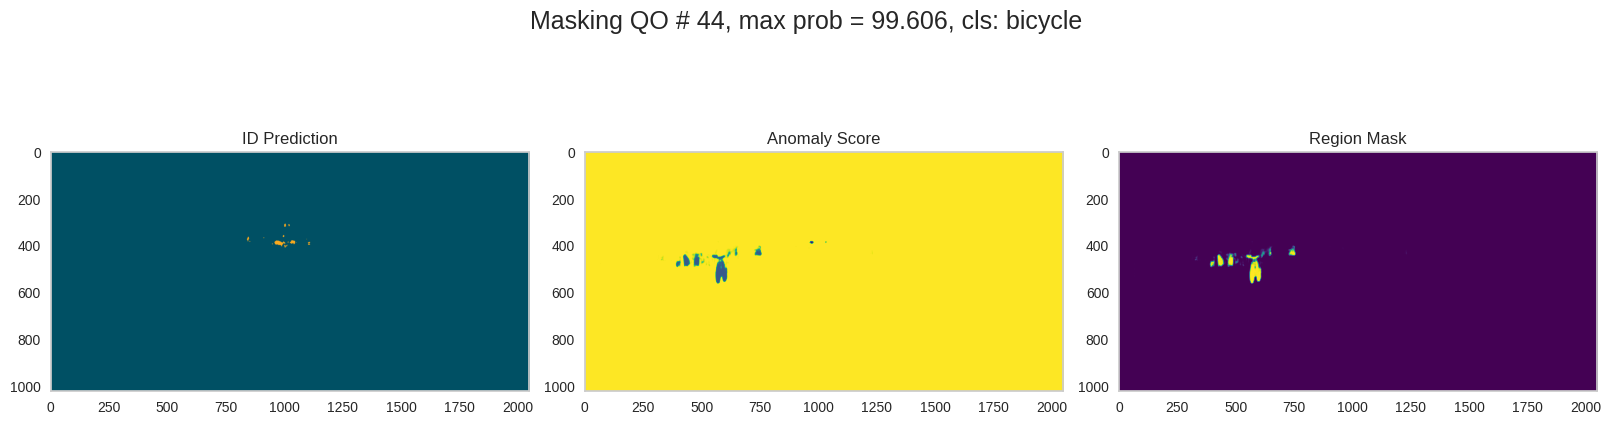

Road Prob tensor(0.0118, device='cuda:0')


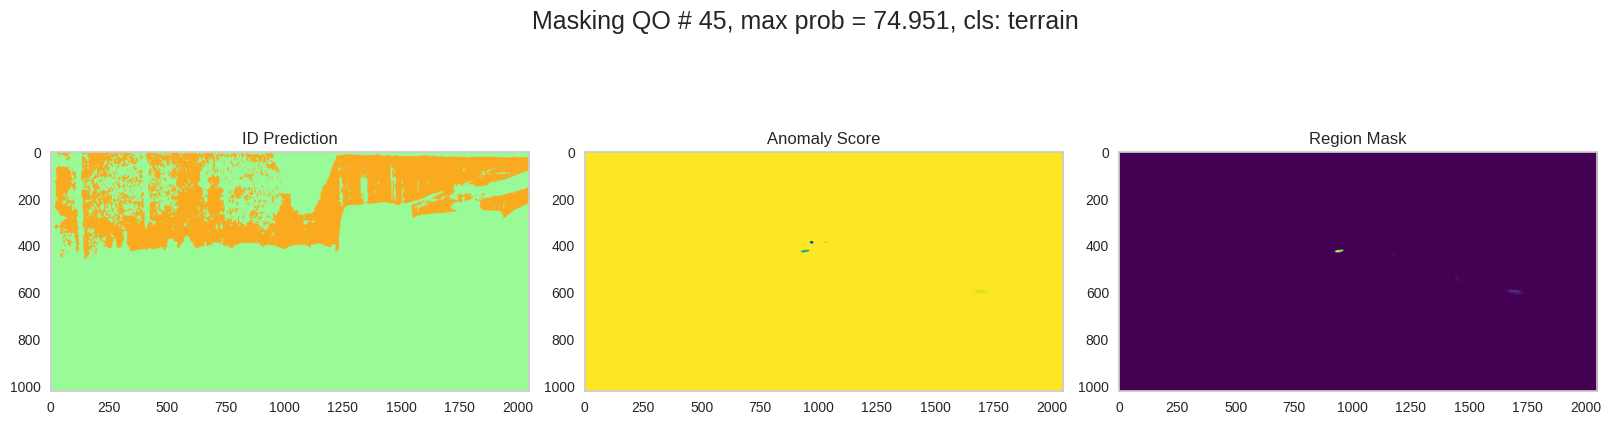

Road Prob tensor(0.0009, device='cuda:0')


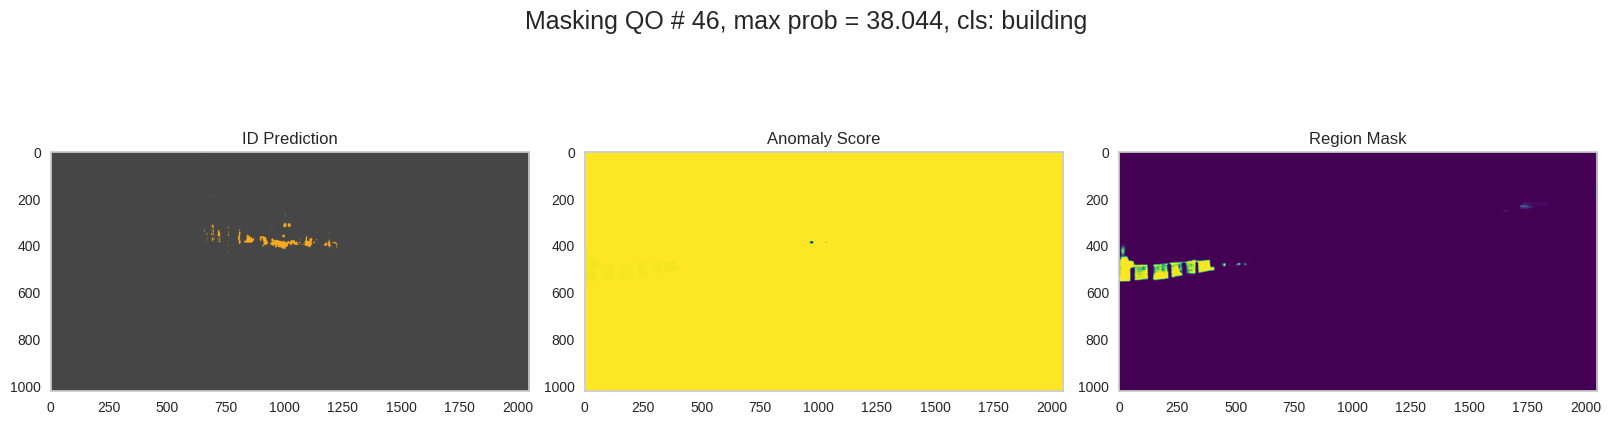

Road Prob tensor(0.0006, device='cuda:0')


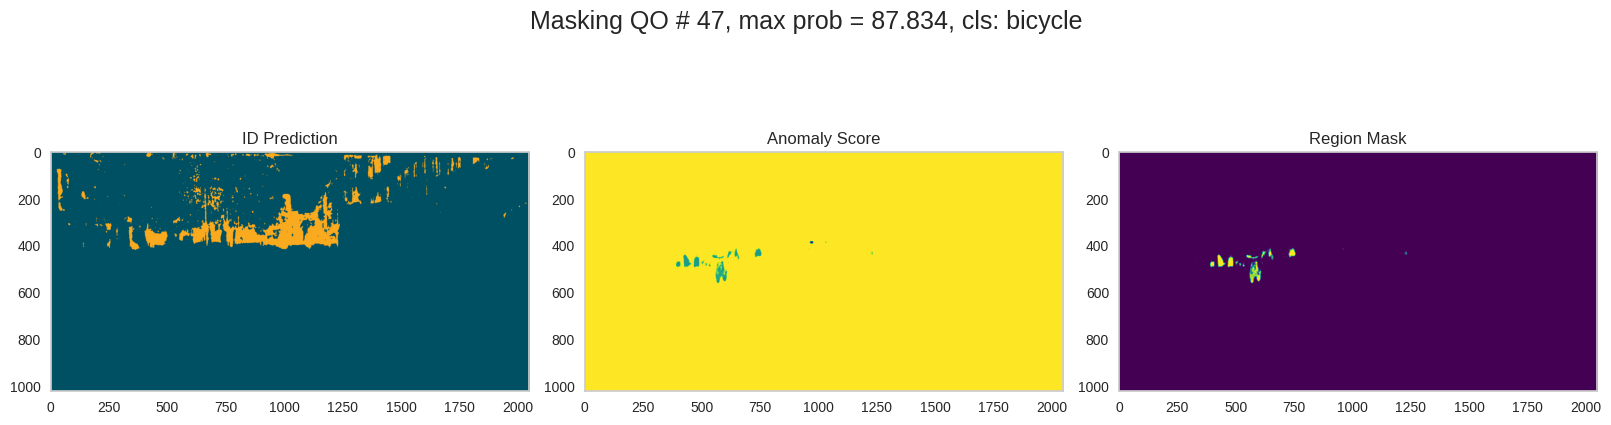

Road Prob tensor(0.0091, device='cuda:0')


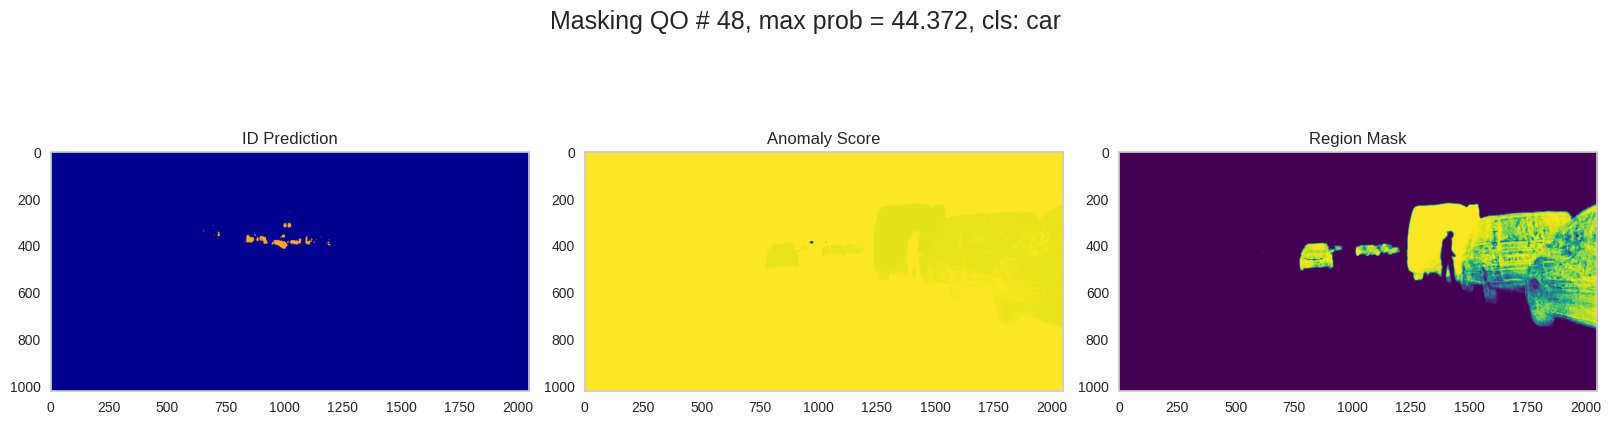

Road Prob tensor(0.0027, device='cuda:0')


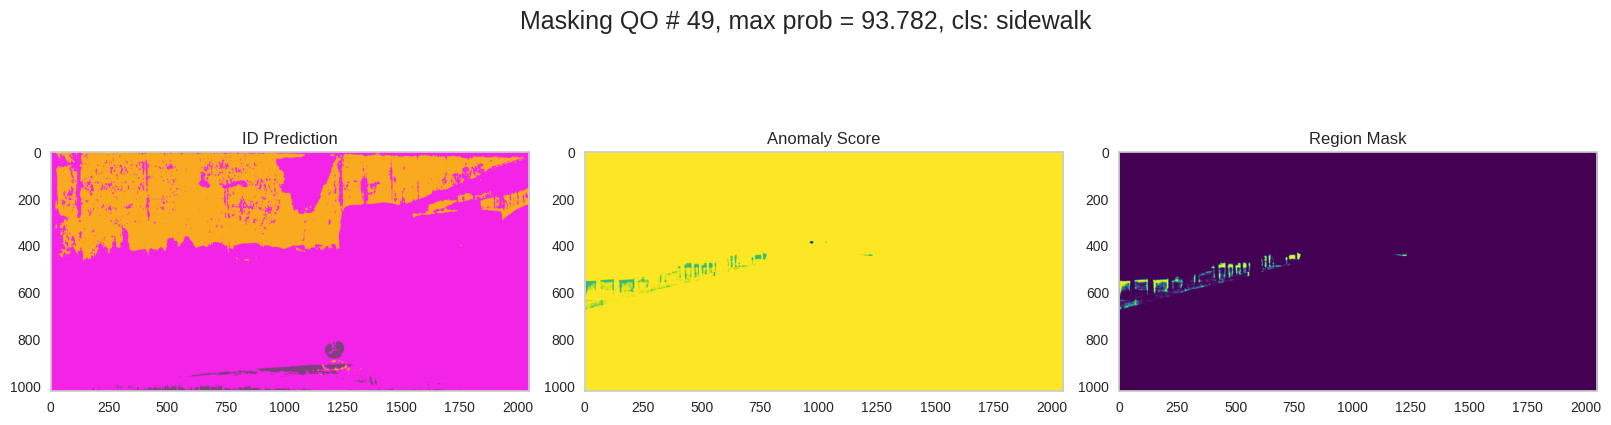

Road Prob tensor(0.0067, device='cuda:0')


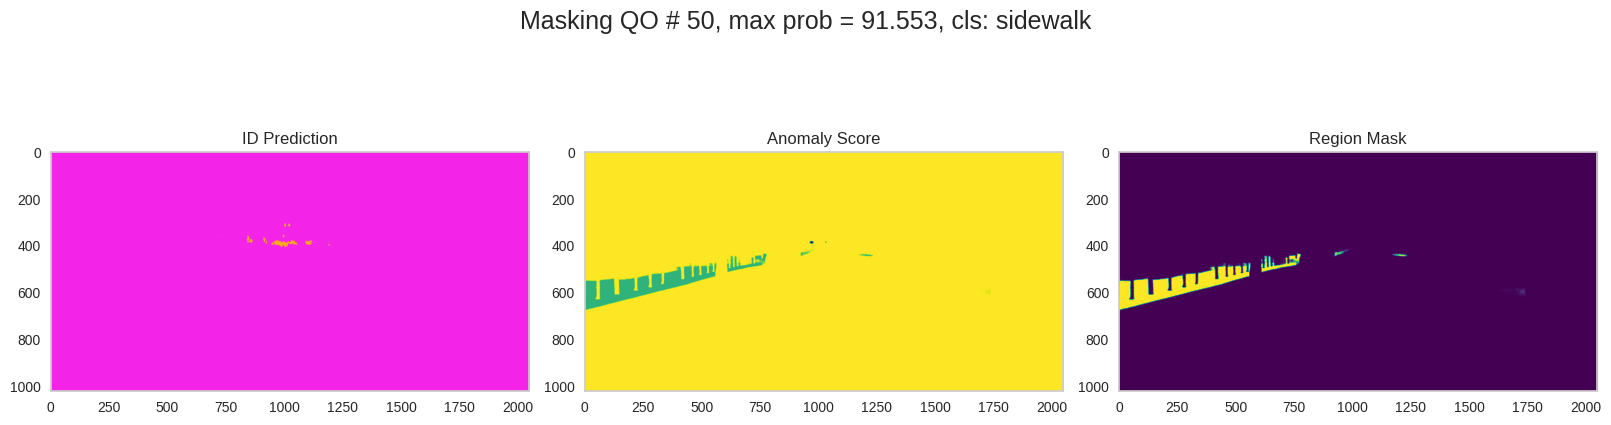

Road Prob tensor(5.9832e-05, device='cuda:0')


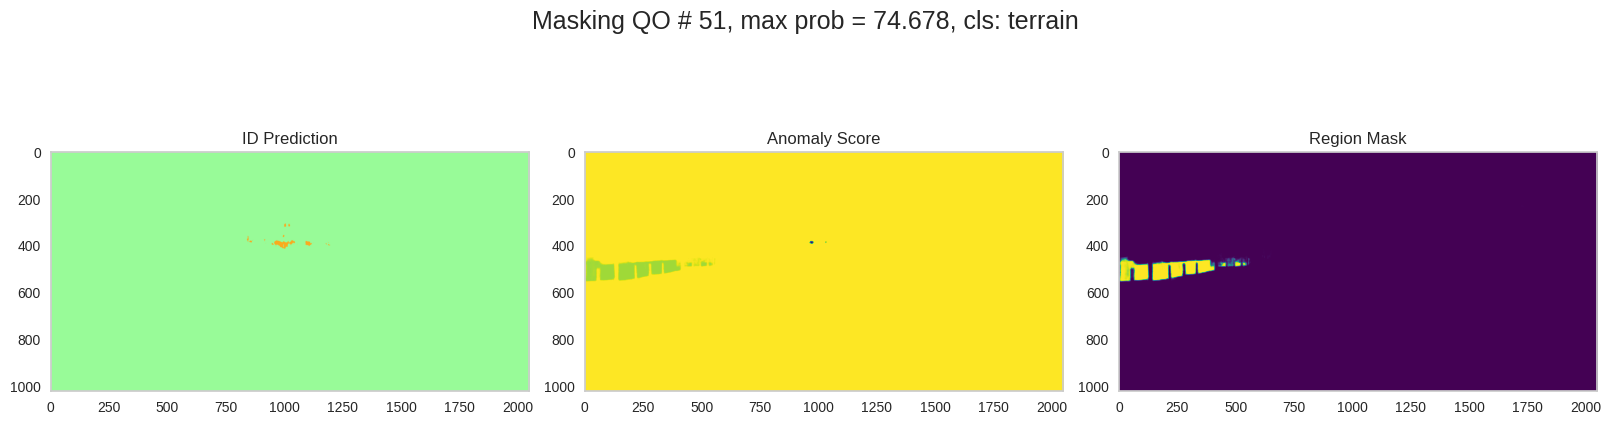

Road Prob tensor(0.0005, device='cuda:0')


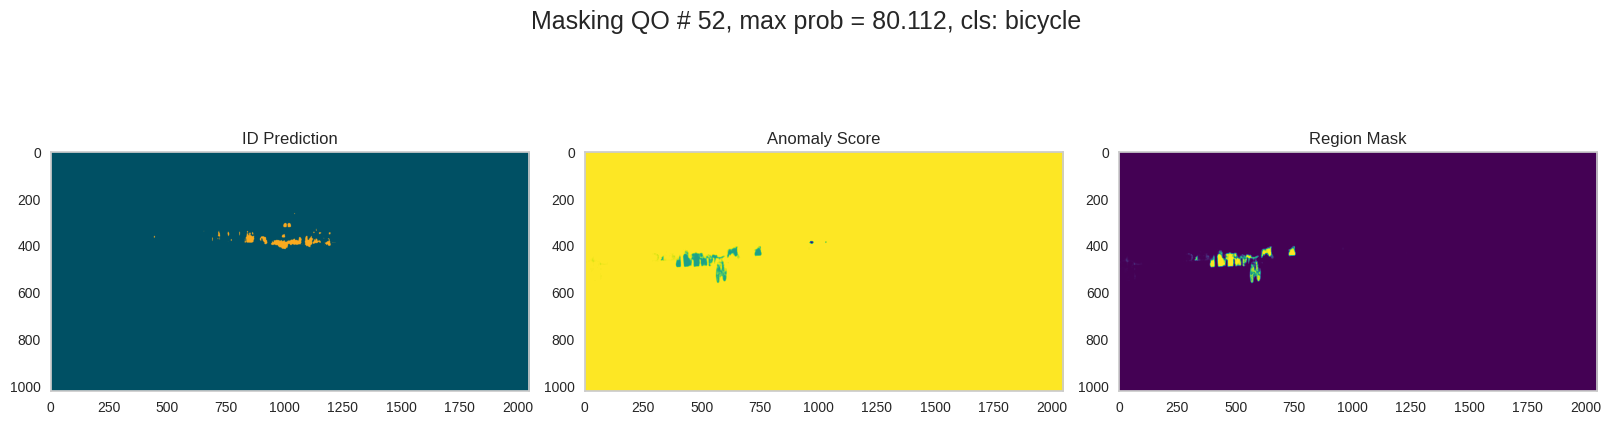

Road Prob tensor(0.0008, device='cuda:0')


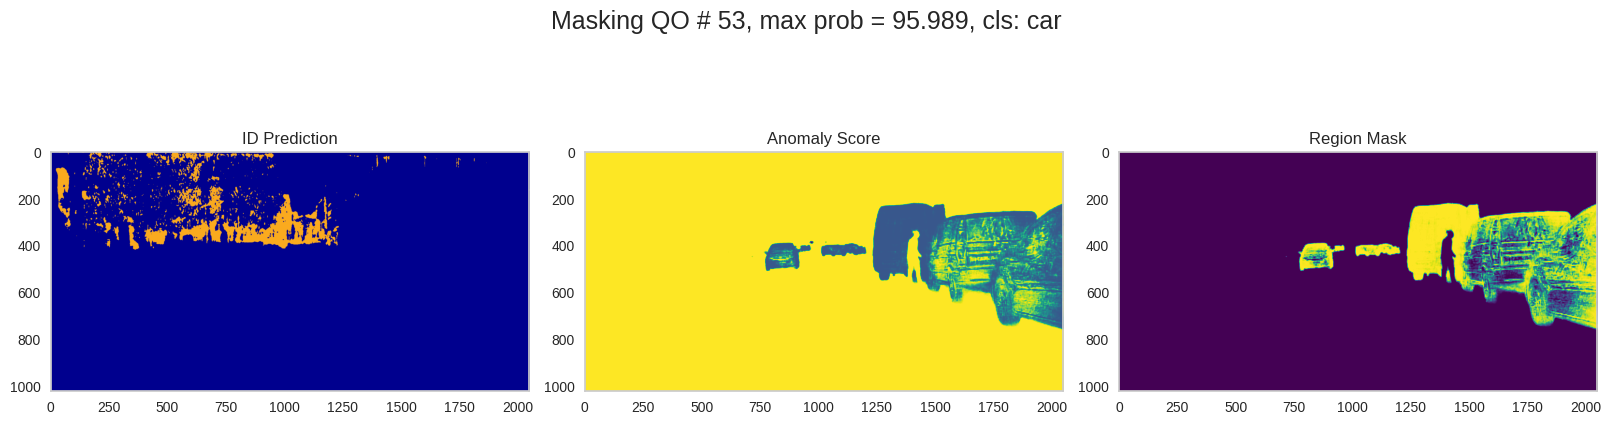

Road Prob tensor(0.0001, device='cuda:0')


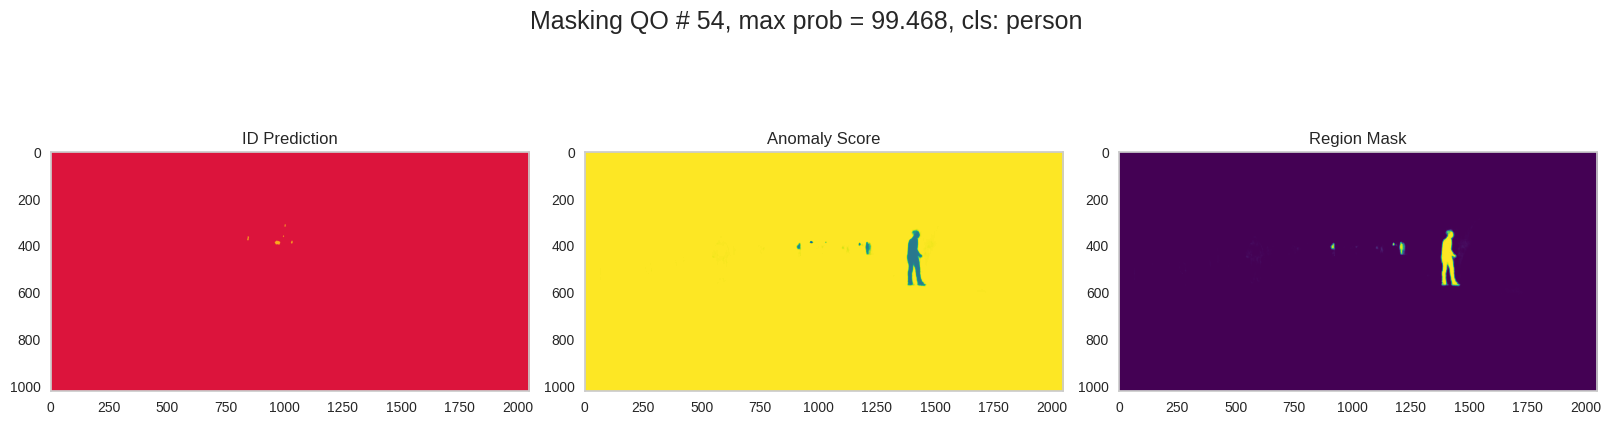

Road Prob tensor(0.0238, device='cuda:0')


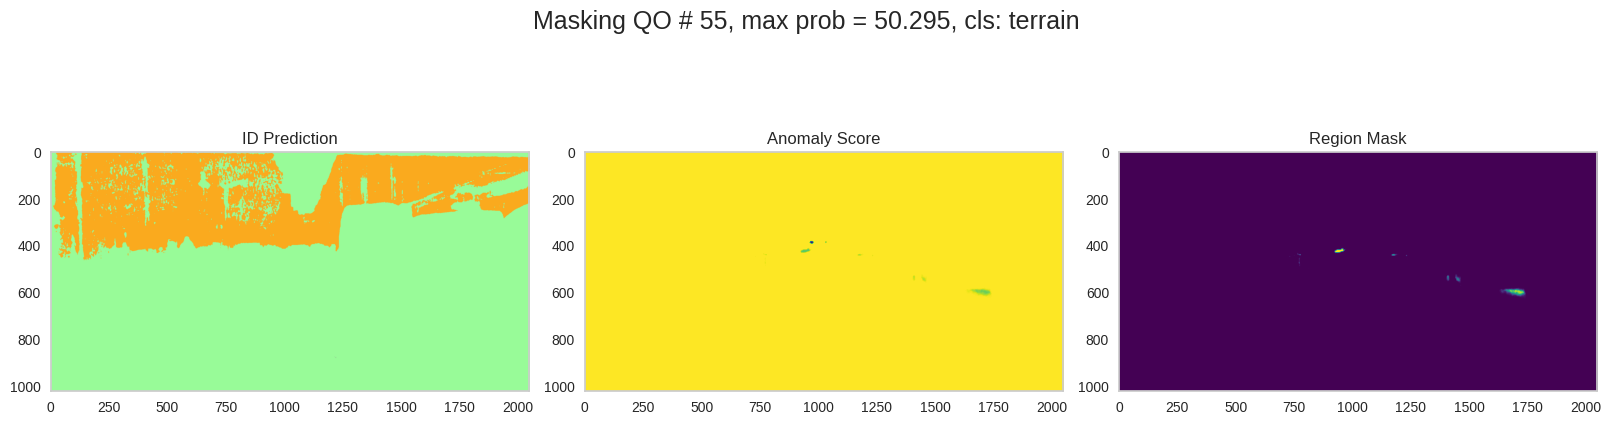

Road Prob tensor(5.4415e-05, device='cuda:0')


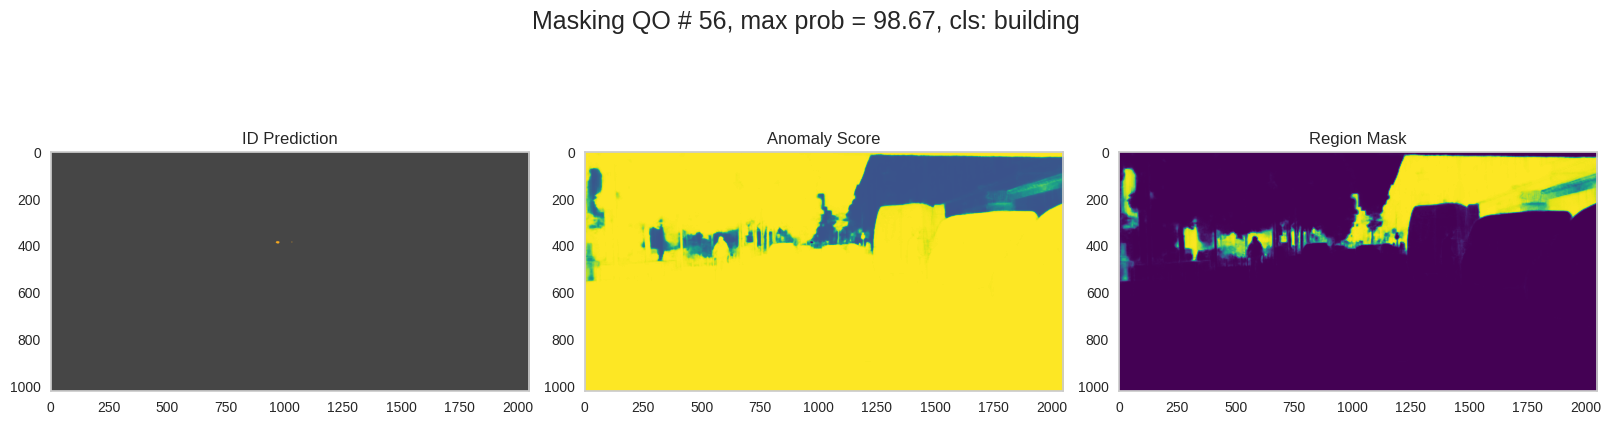

Road Prob tensor(0.0045, device='cuda:0')


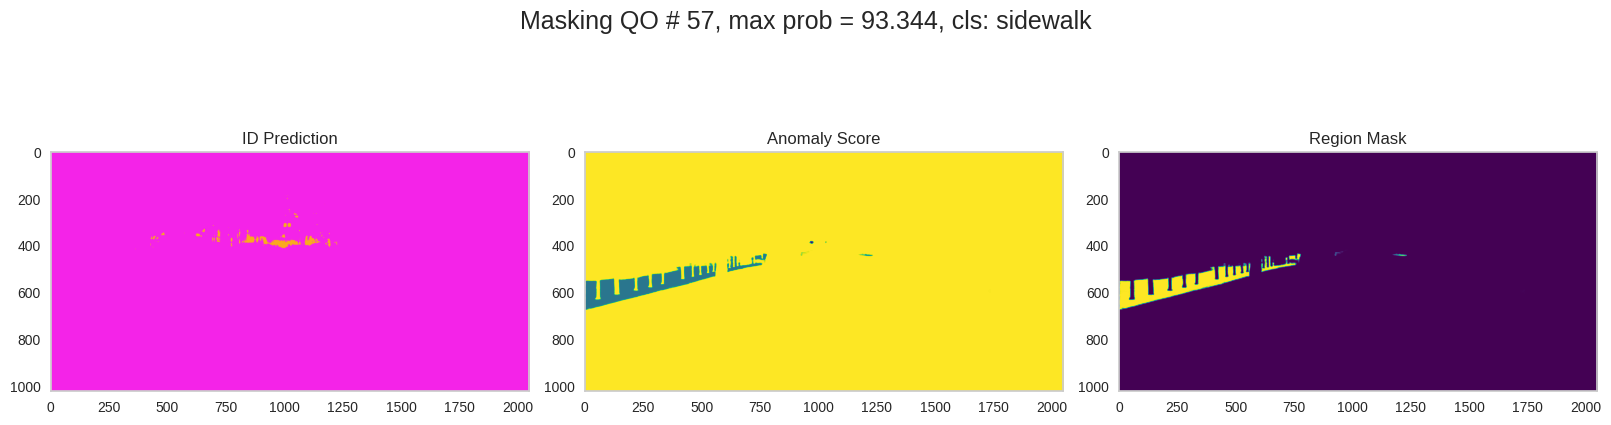

Road Prob tensor(0.0002, device='cuda:0')


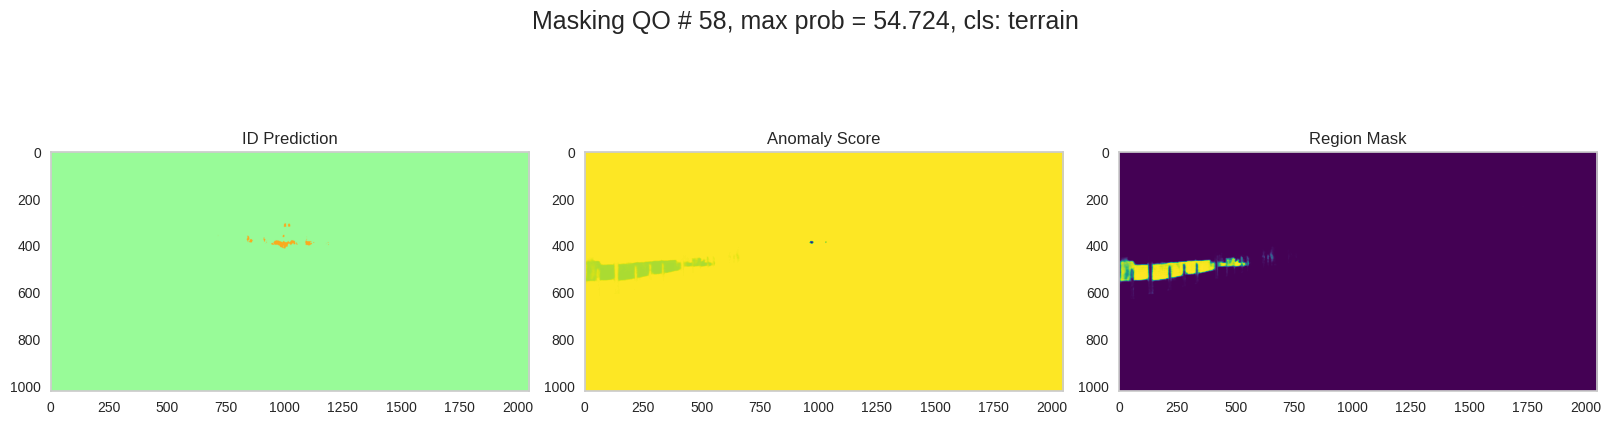

Road Prob tensor(0.0044, device='cuda:0')


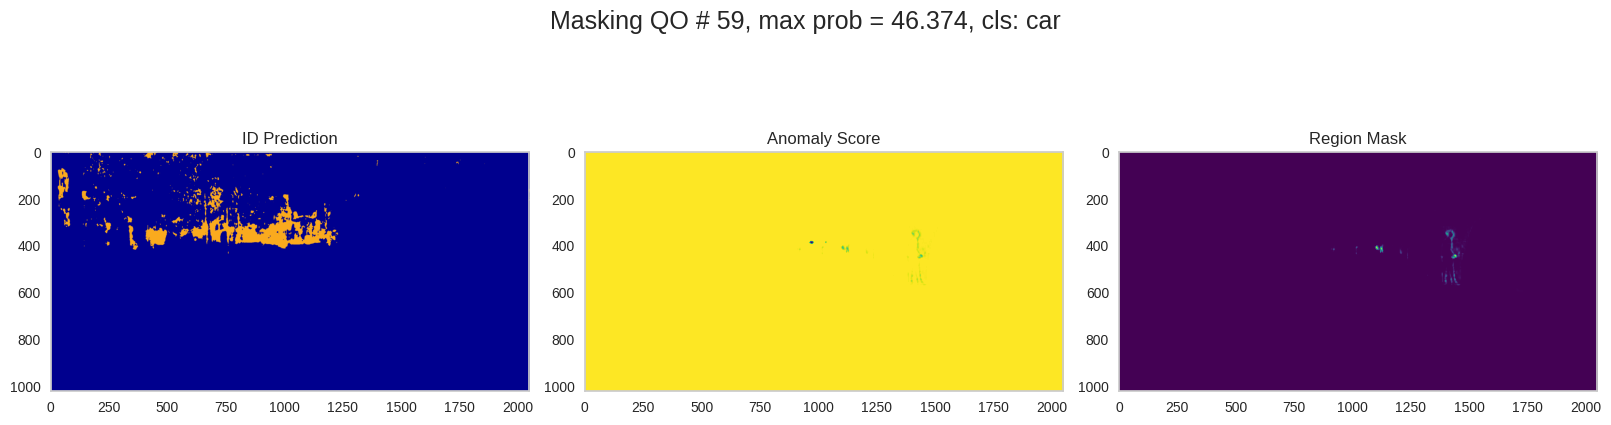

Road Prob tensor(4.2675e-05, device='cuda:0')


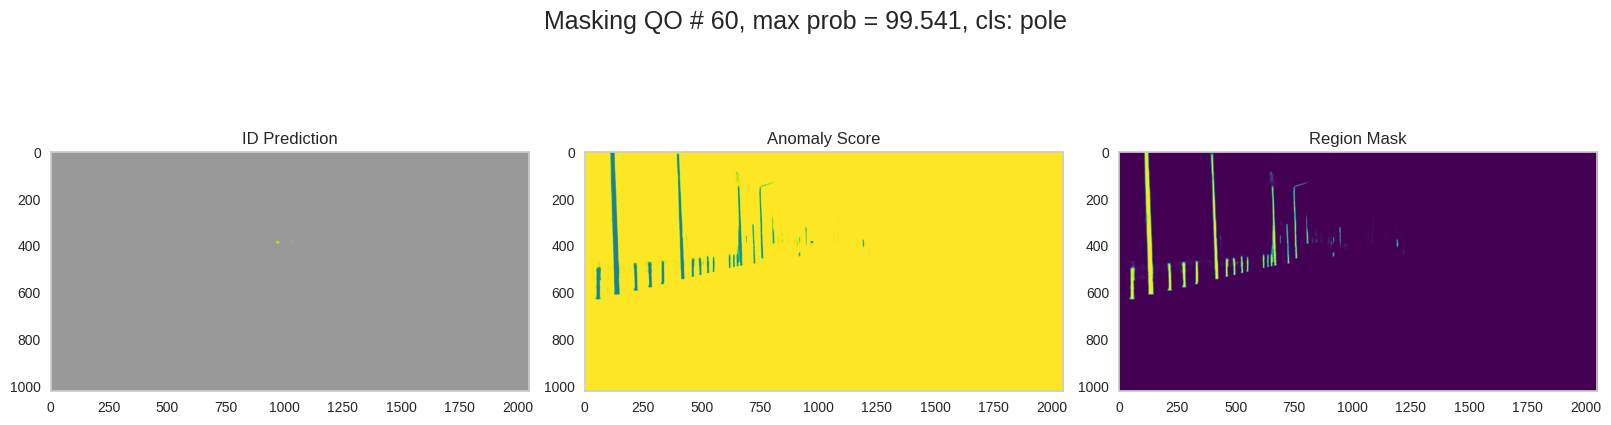

Road Prob tensor(0.0284, device='cuda:0')


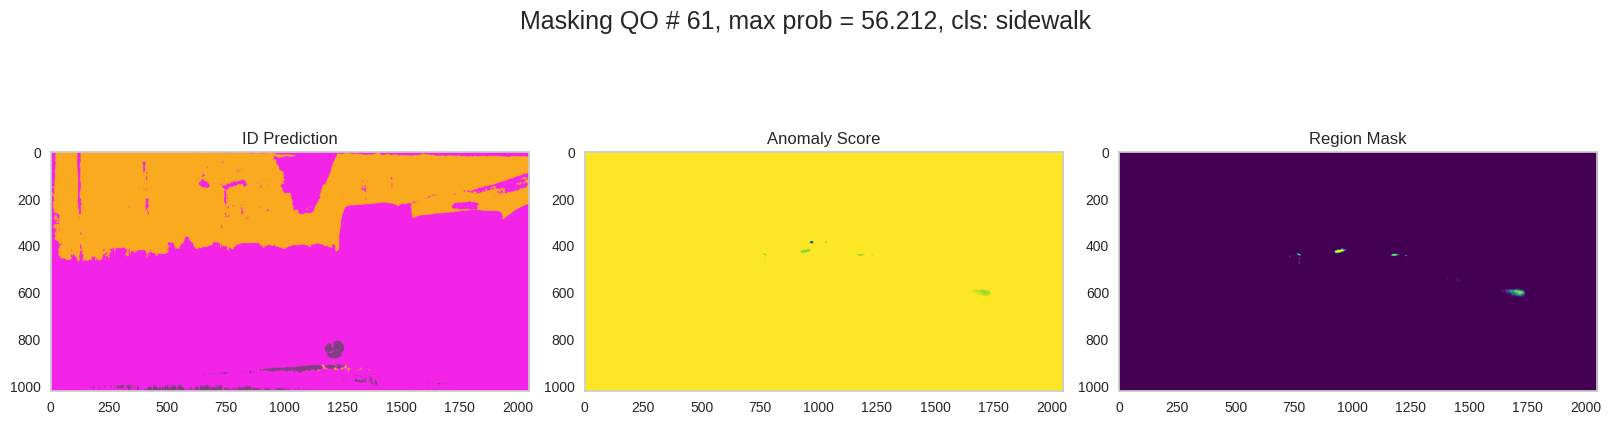

Road Prob tensor(0.0002, device='cuda:0')


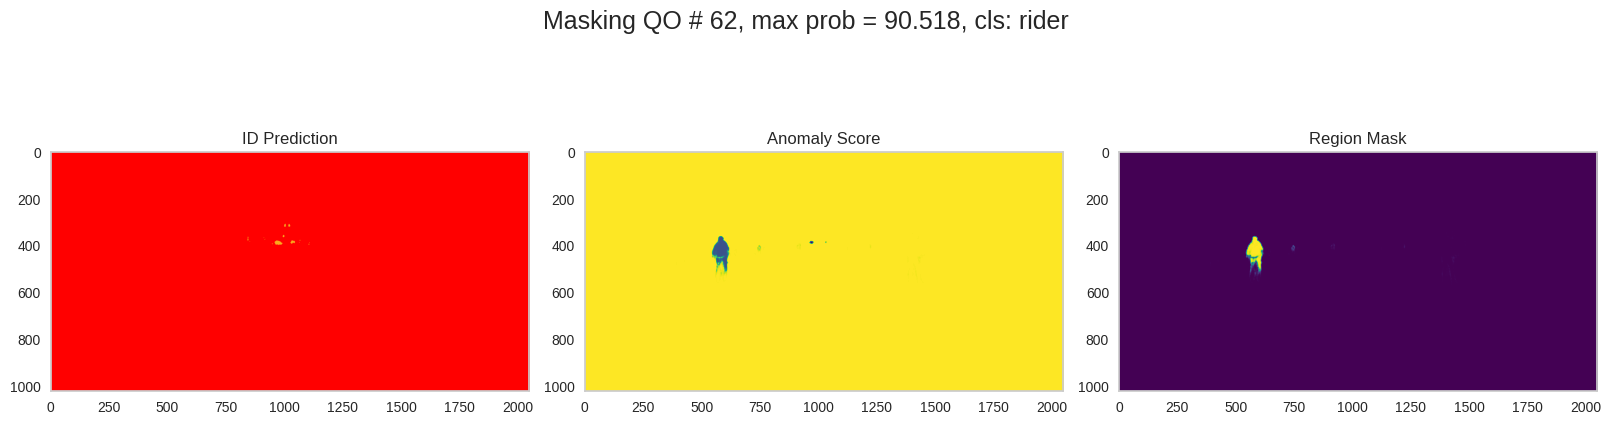

Road Prob tensor(0.0020, device='cuda:0')


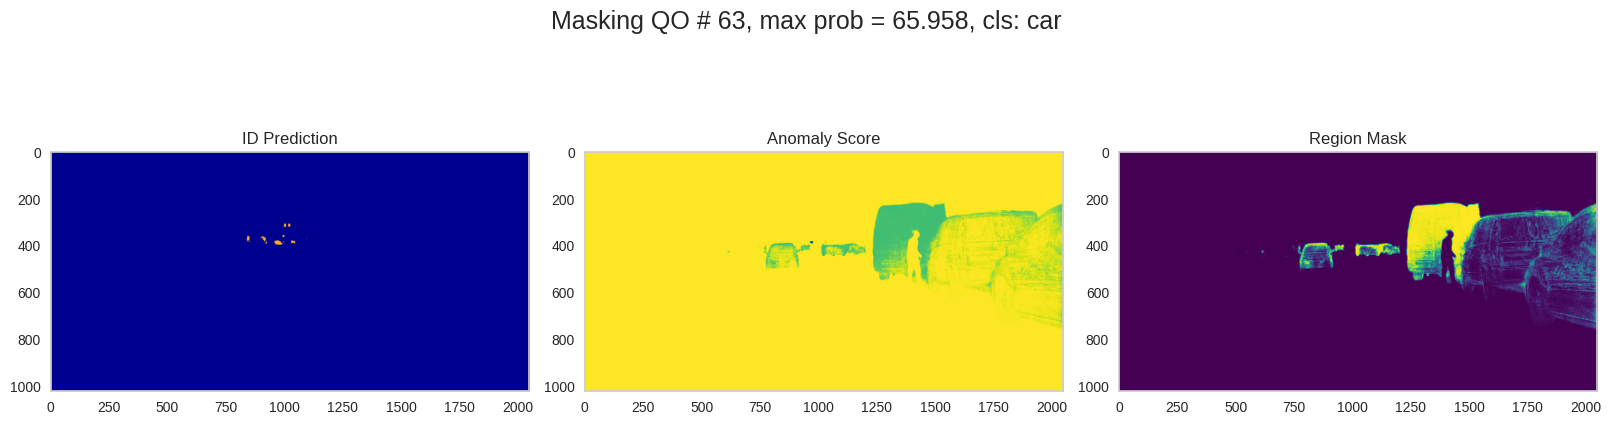

Road Prob tensor(8.8018e-05, device='cuda:0')


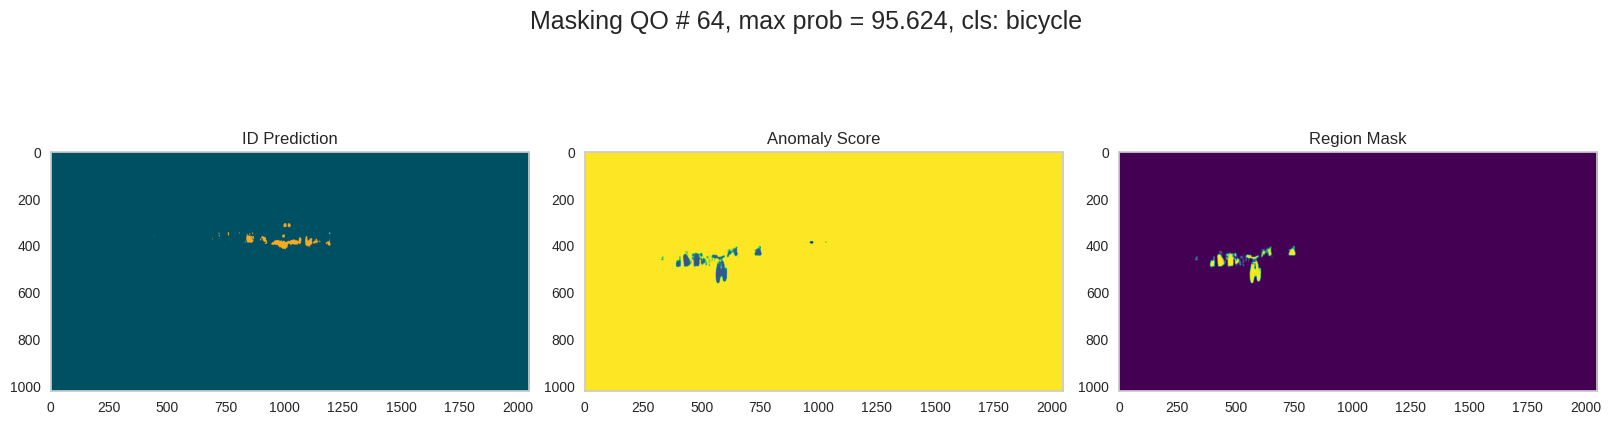

Road Prob tensor(0.0042, device='cuda:0')


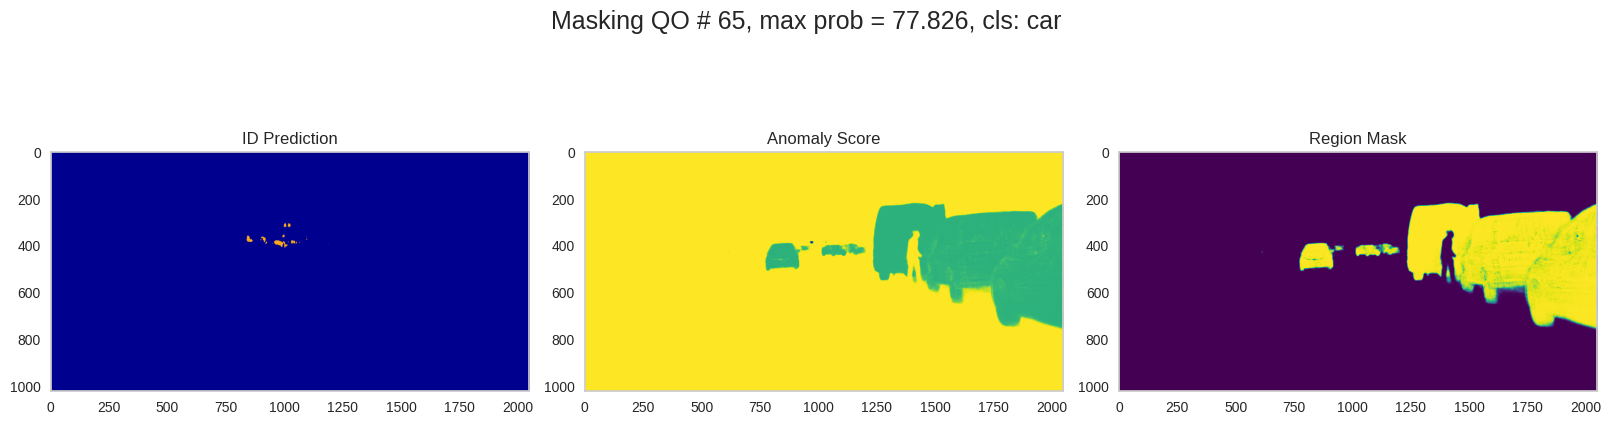

Road Prob tensor(0.0002, device='cuda:0')


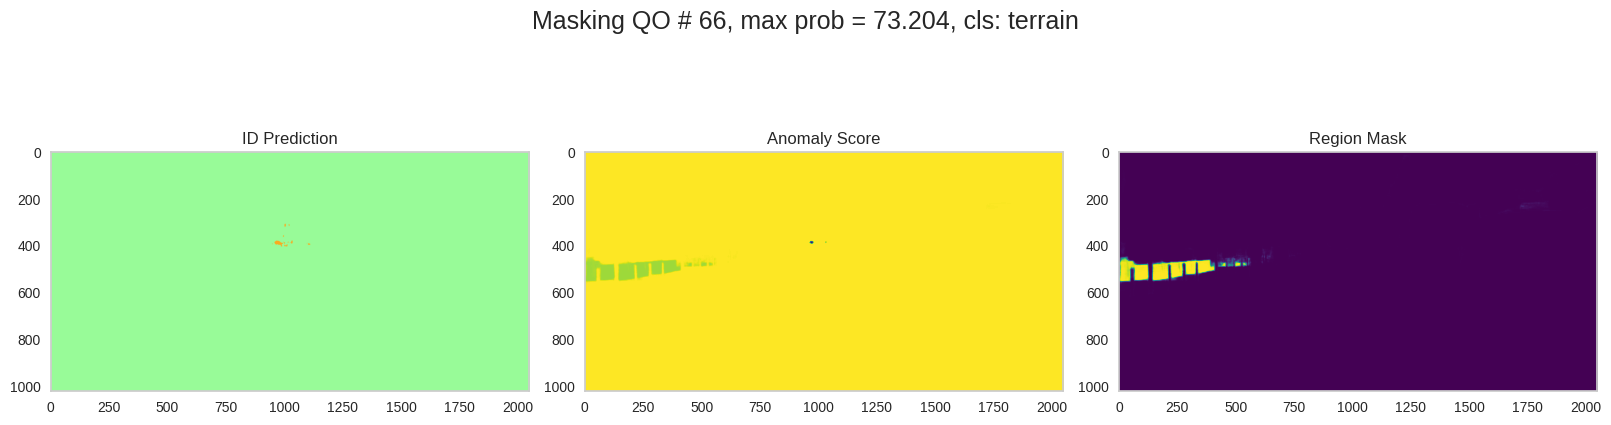

Road Prob tensor(0.0020, device='cuda:0')


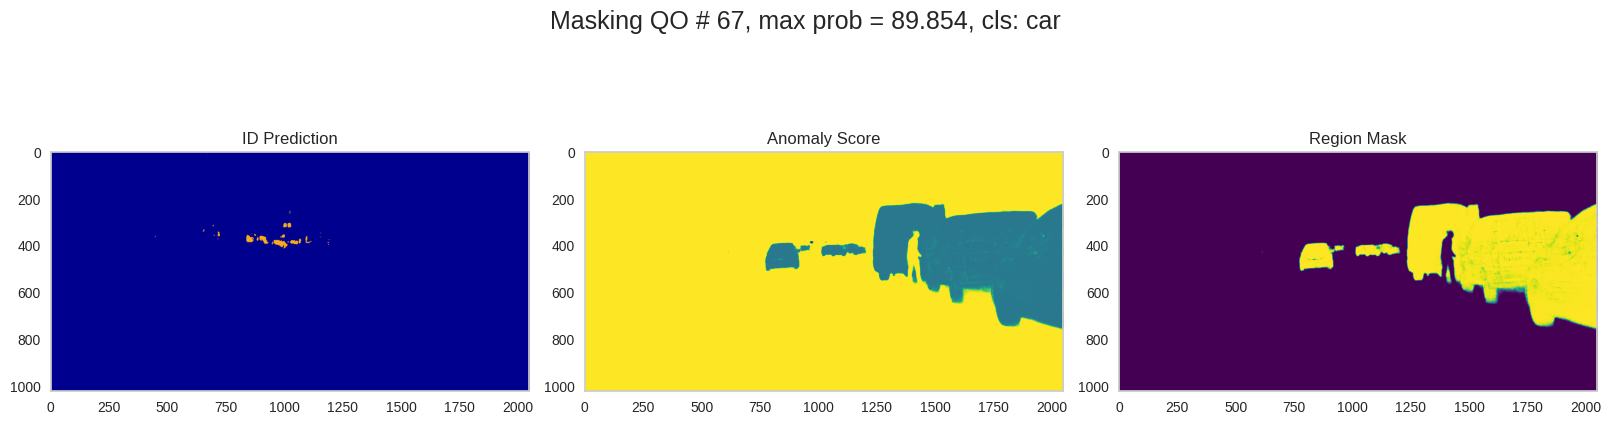

Road Prob tensor(0.0140, device='cuda:0')


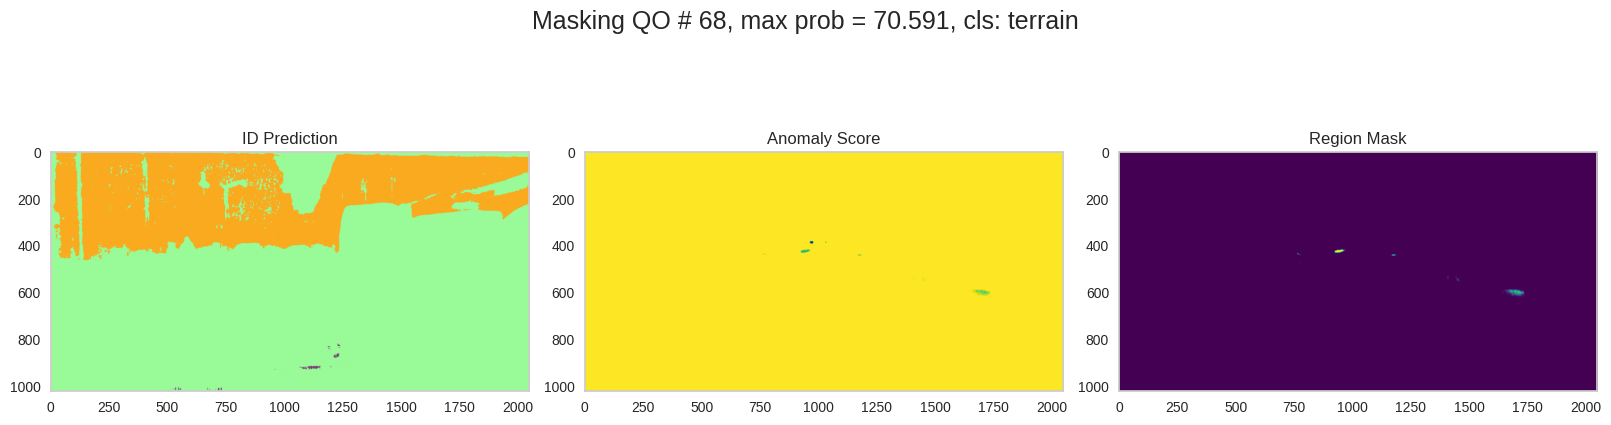

Road Prob tensor(0.0007, device='cuda:0')


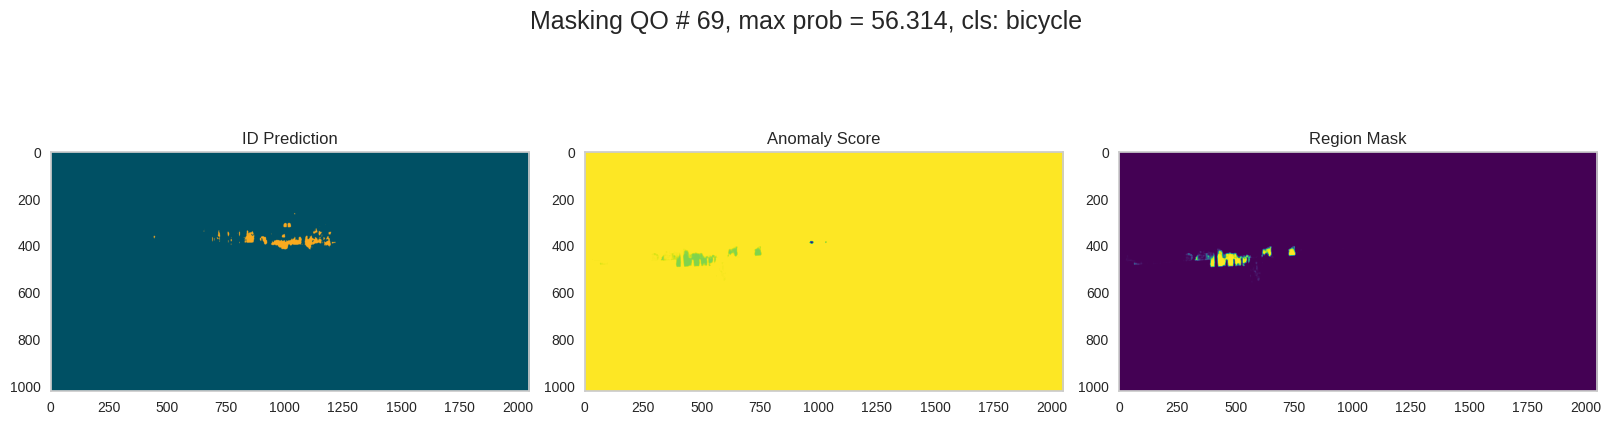

Road Prob tensor(0.0001, device='cuda:0')


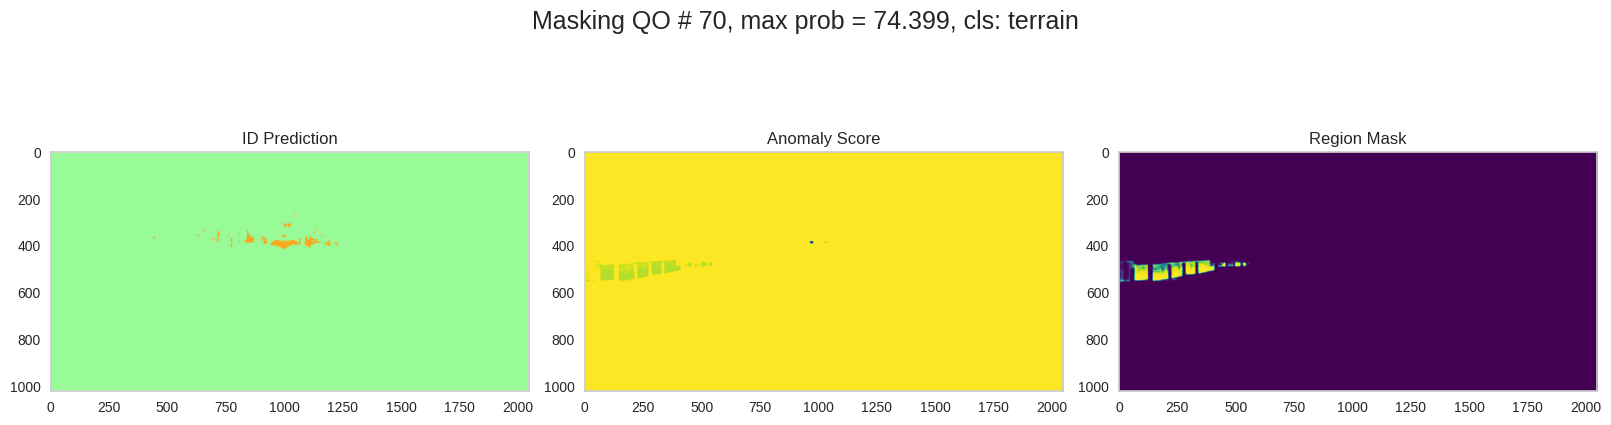

Road Prob tensor(0.0016, device='cuda:0')


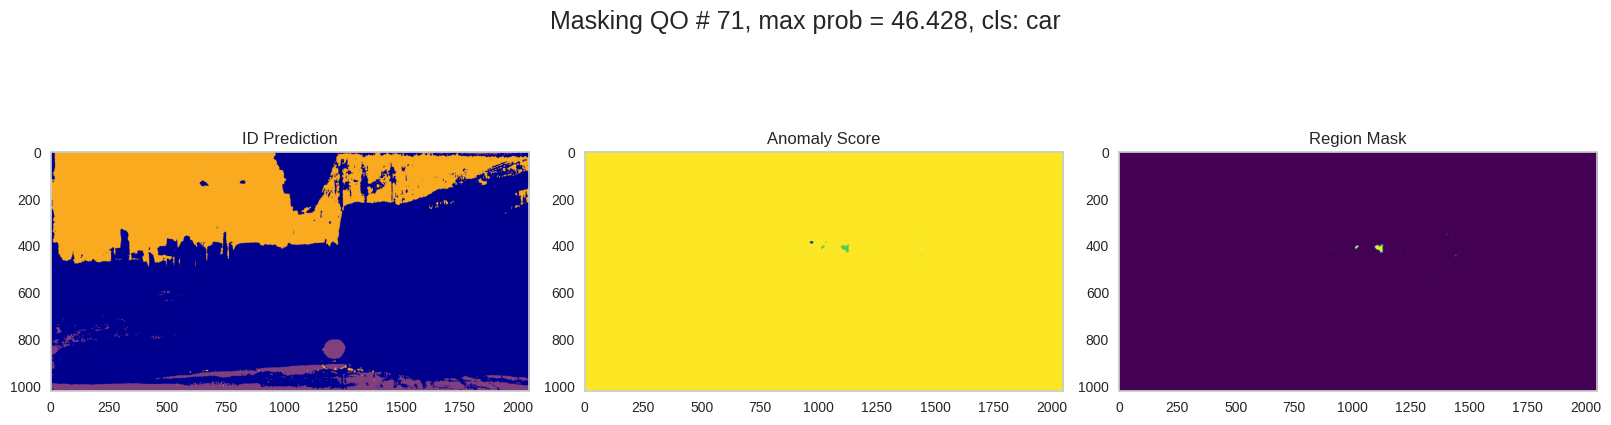

Road Prob tensor(0.0006, device='cuda:0')


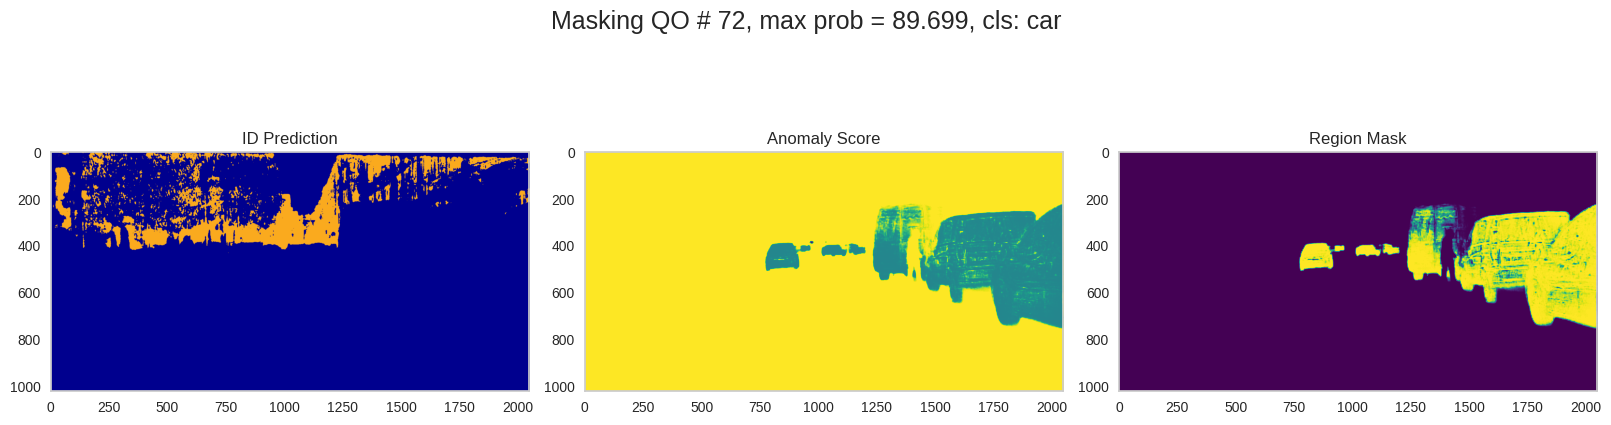

Road Prob tensor(0.0122, device='cuda:0')


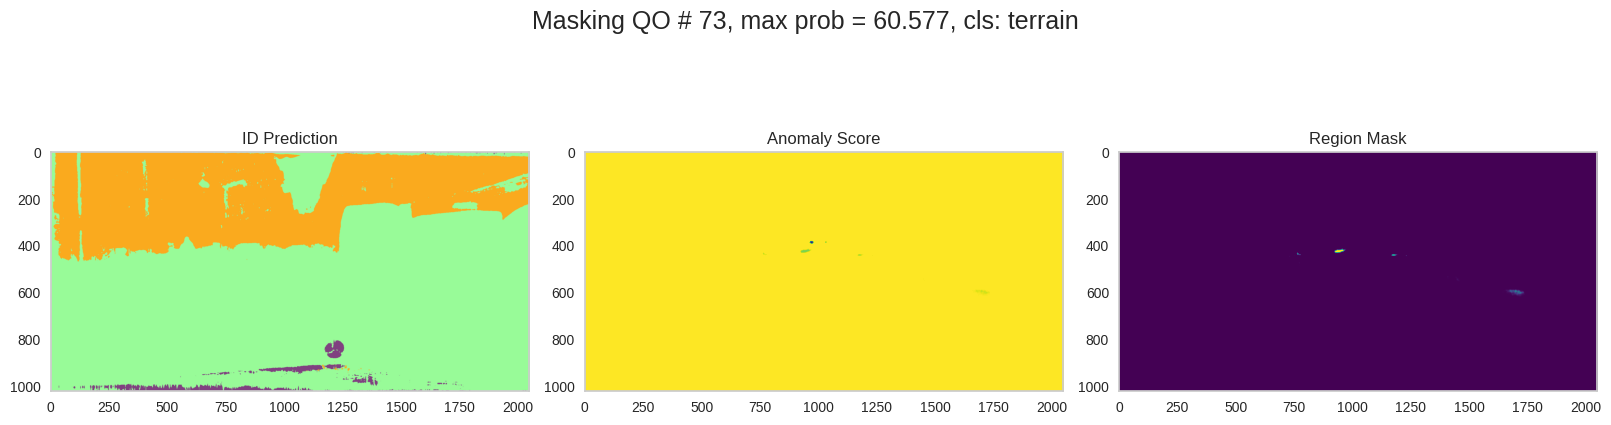

Road Prob tensor(0.0057, device='cuda:0')


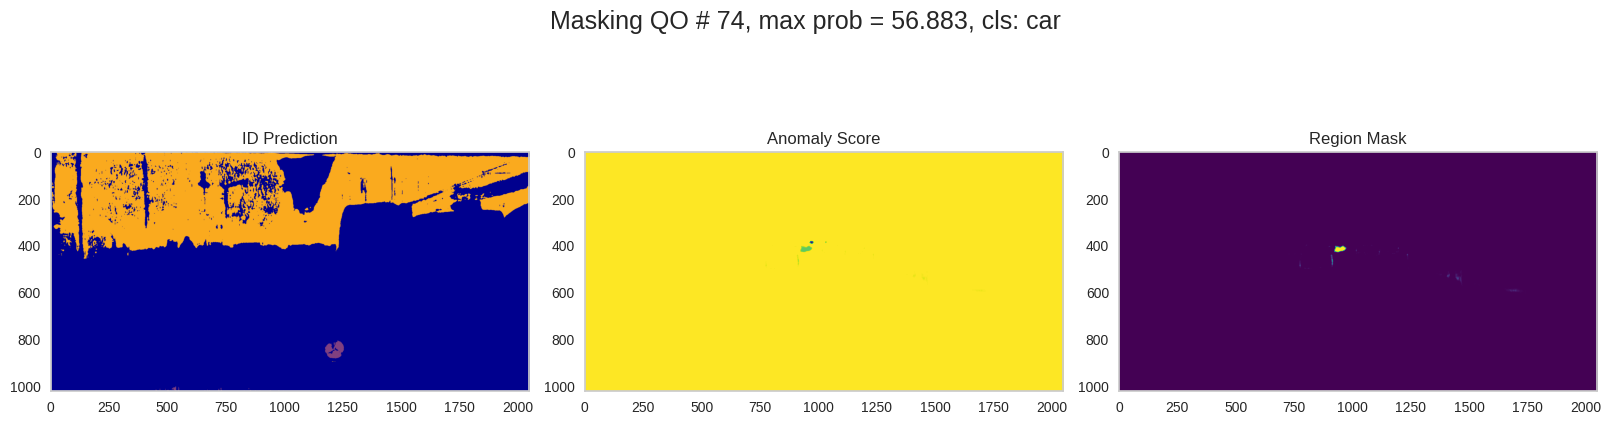

Road Prob tensor(0.0001, device='cuda:0')


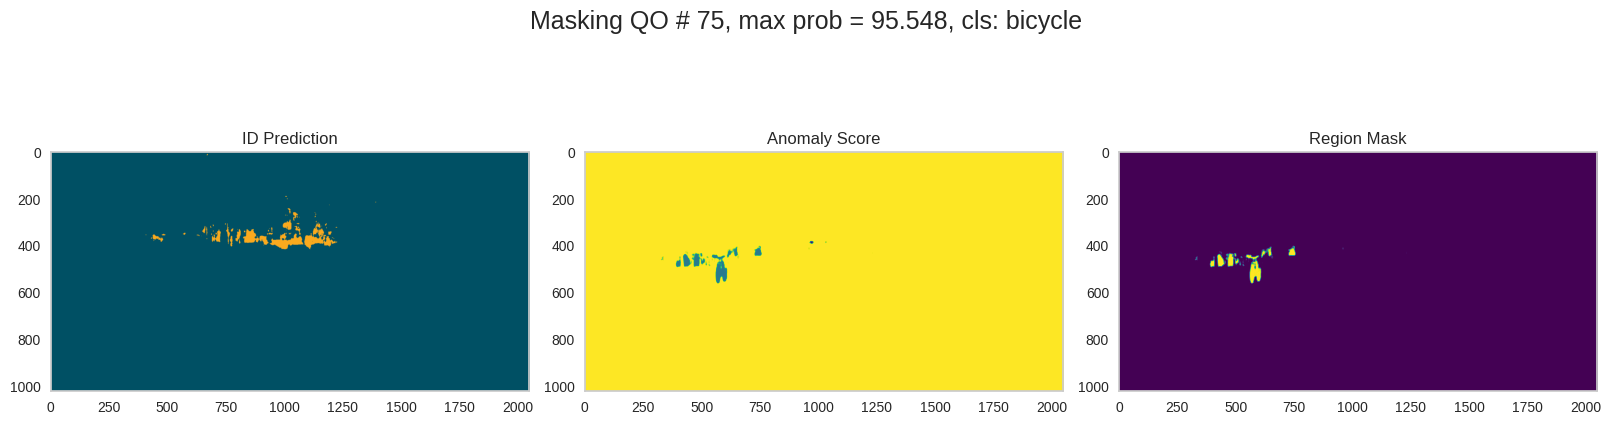

Road Prob tensor(0.0005, device='cuda:0')


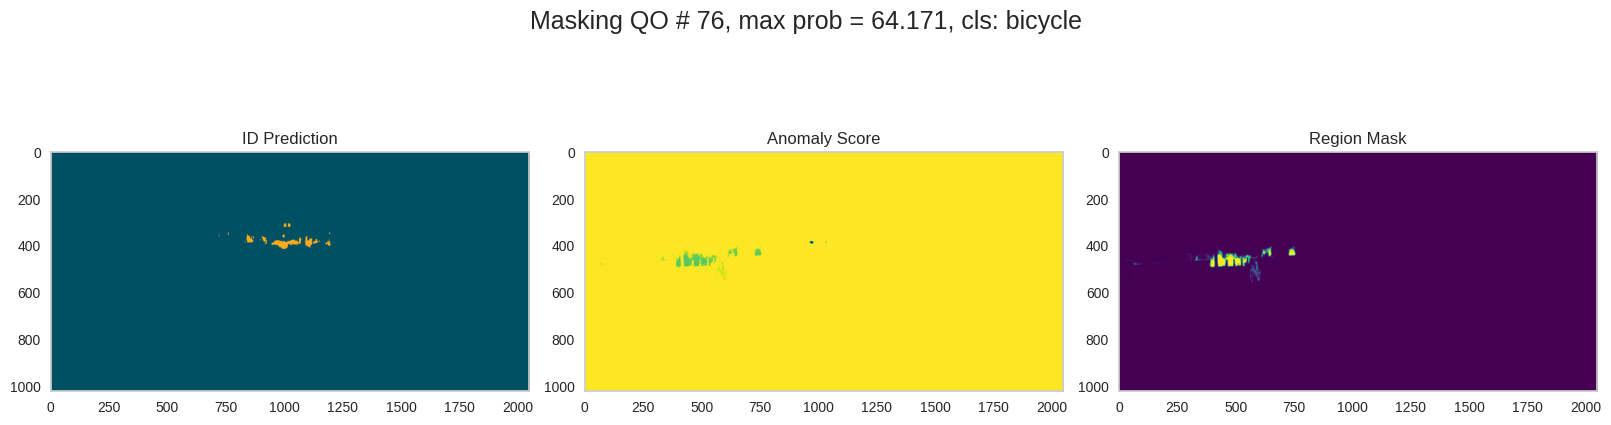

Road Prob tensor(0.0002, device='cuda:0')


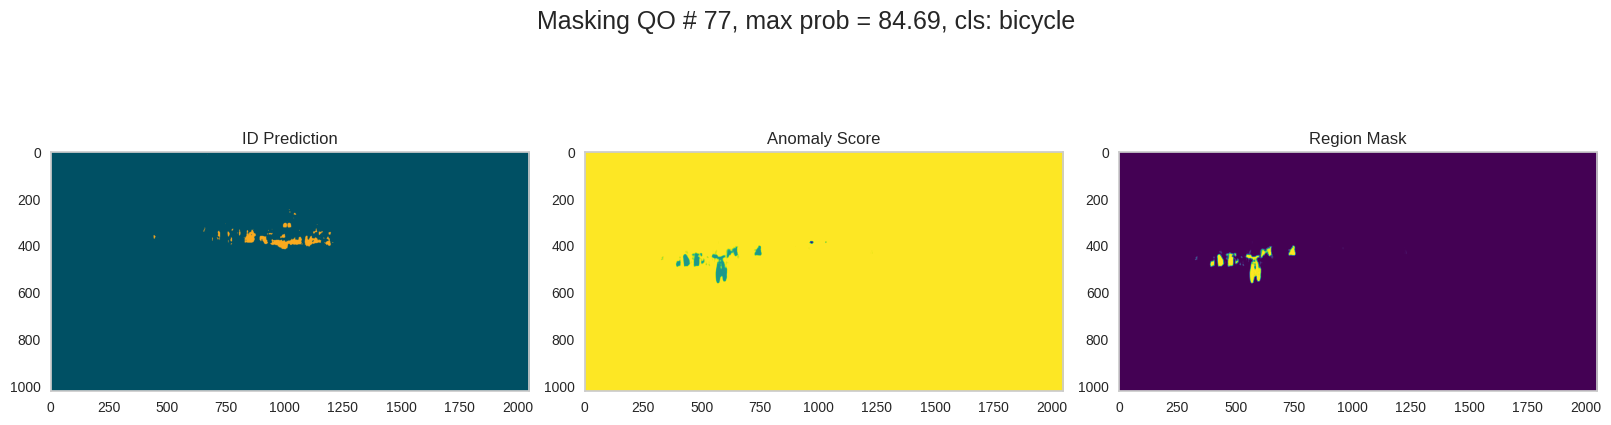

Road Prob tensor(1.8010e-05, device='cuda:0')


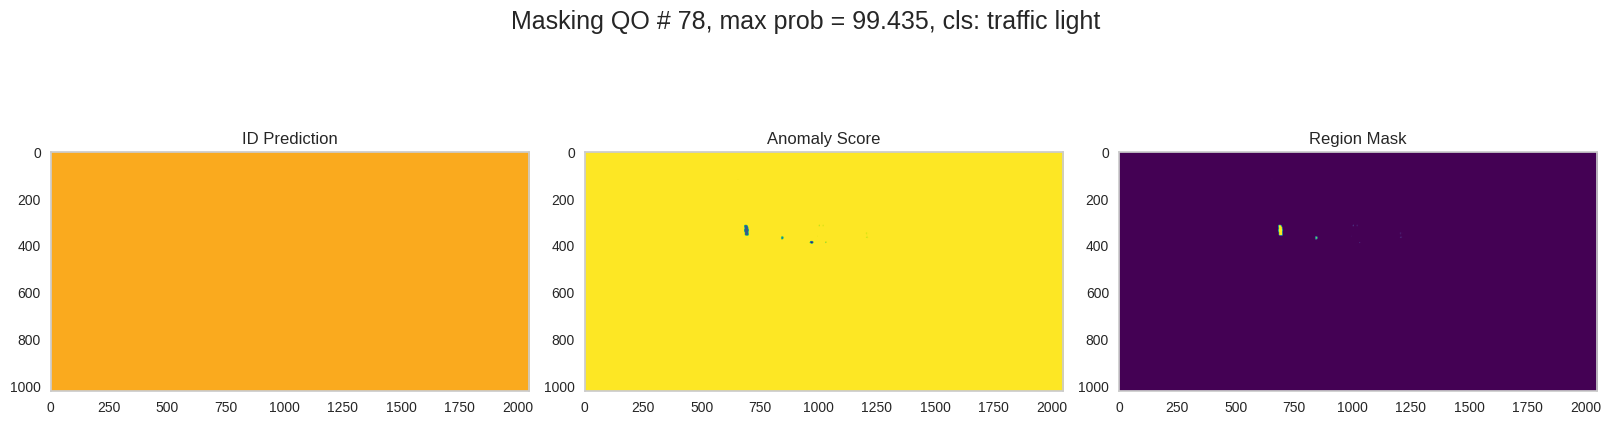

Road Prob tensor(0.0001, device='cuda:0')


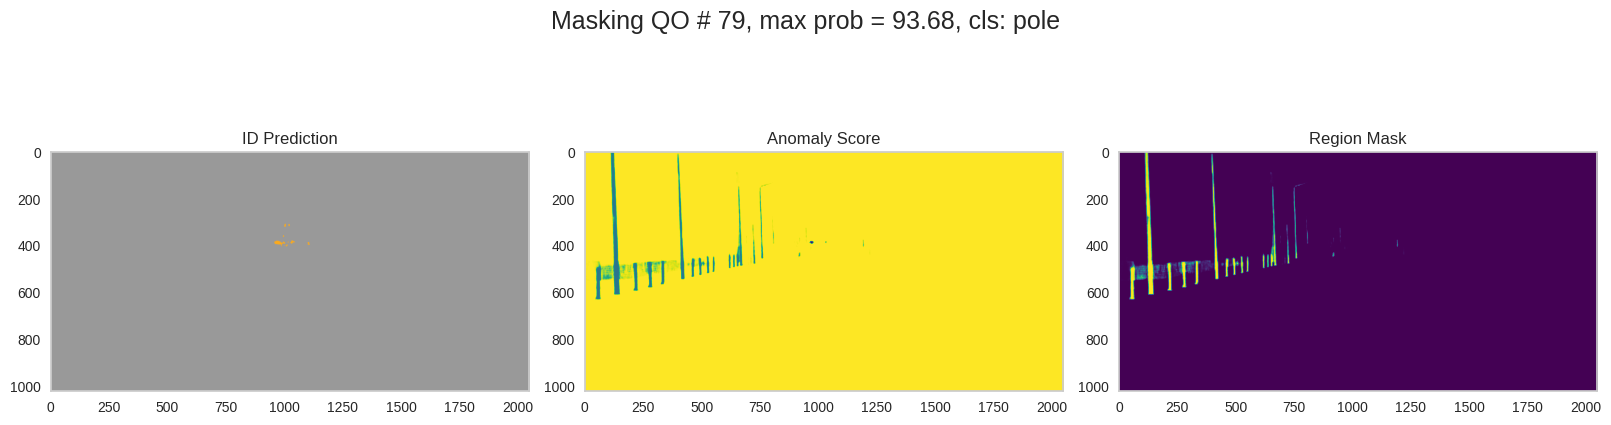

Road Prob tensor(0.0078, device='cuda:0')


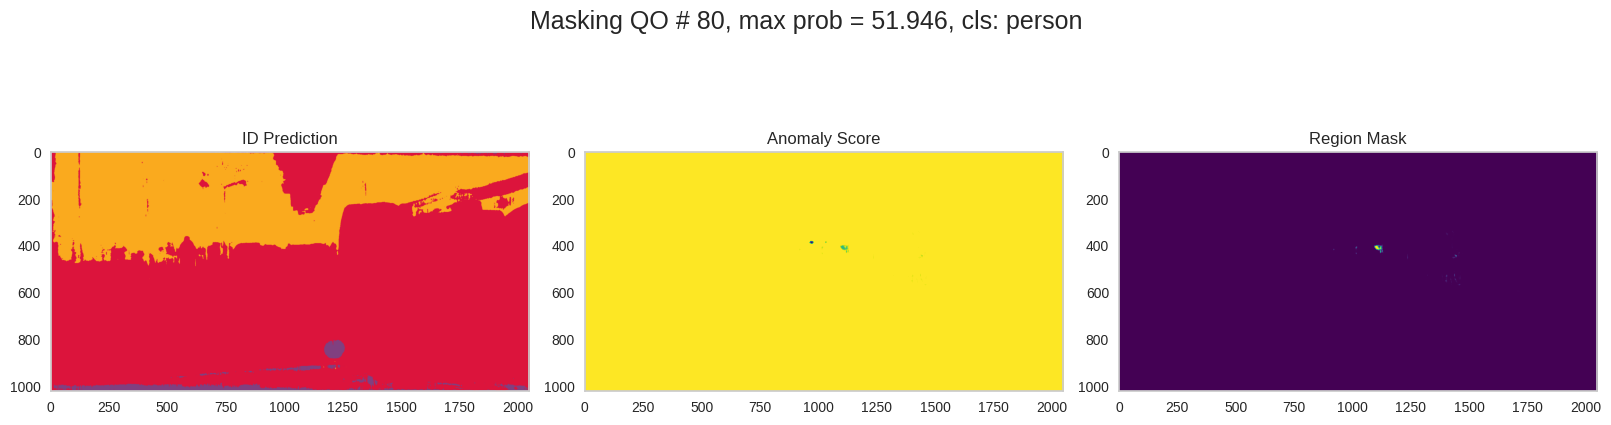

Road Prob tensor(2.6980e-05, device='cuda:0')


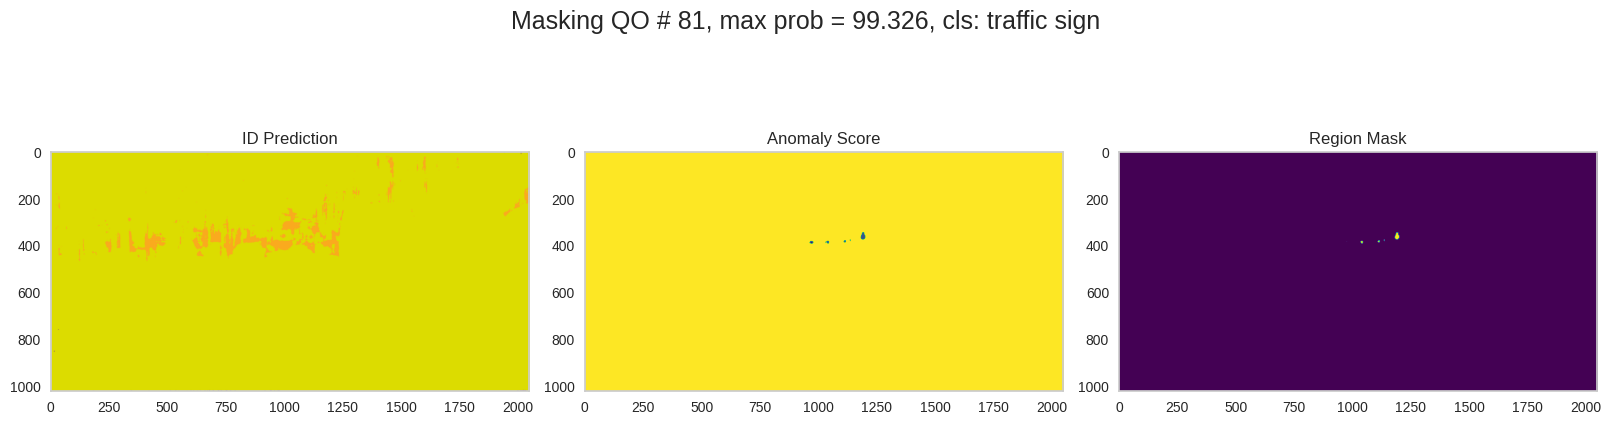

Road Prob tensor(0.0003, device='cuda:0')


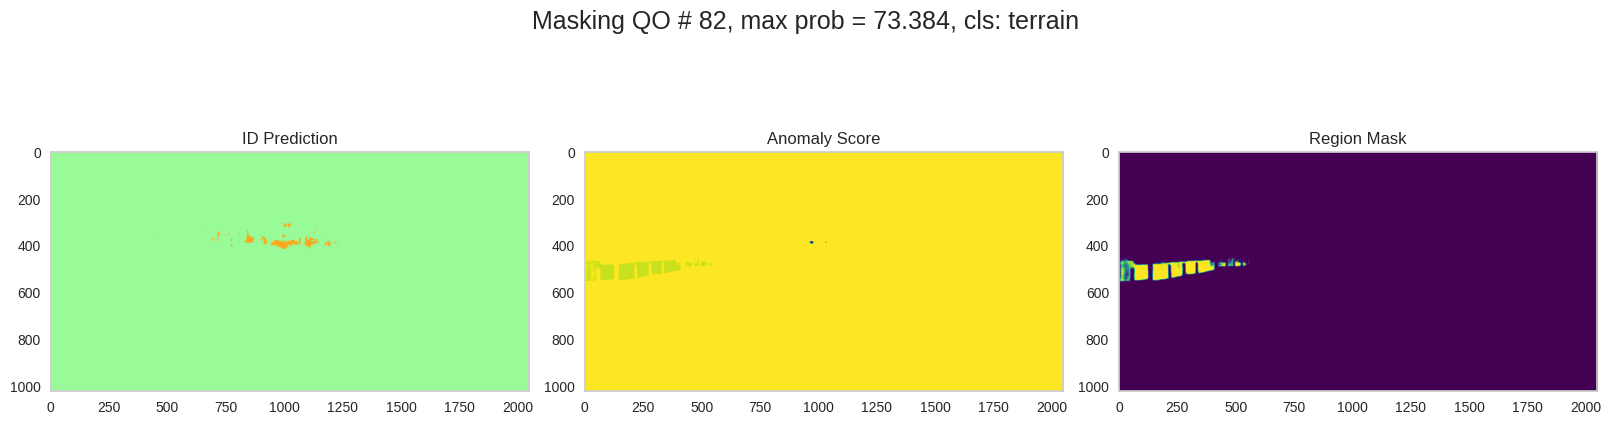

Road Prob tensor(0.0034, device='cuda:0')


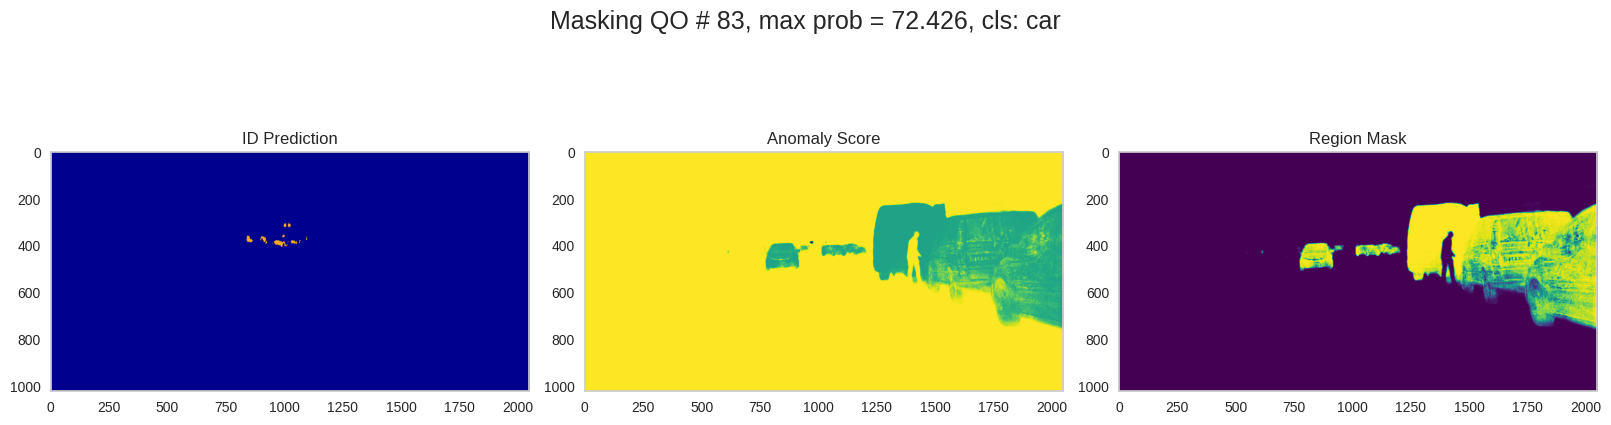

Road Prob tensor(0.0355, device='cuda:0')


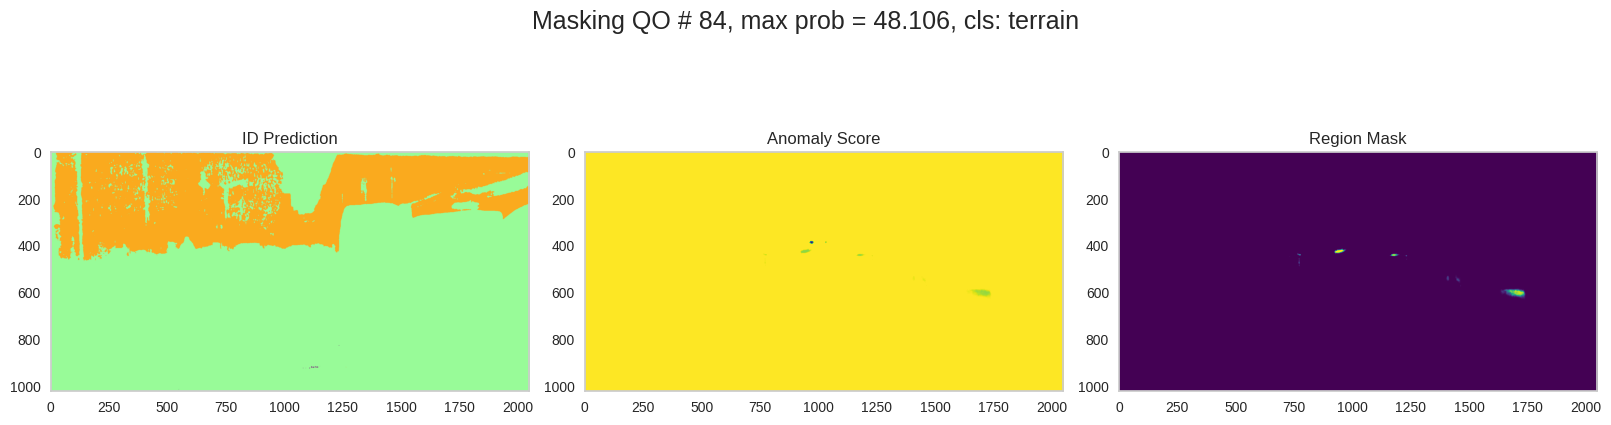

Road Prob tensor(0.0003, device='cuda:0')


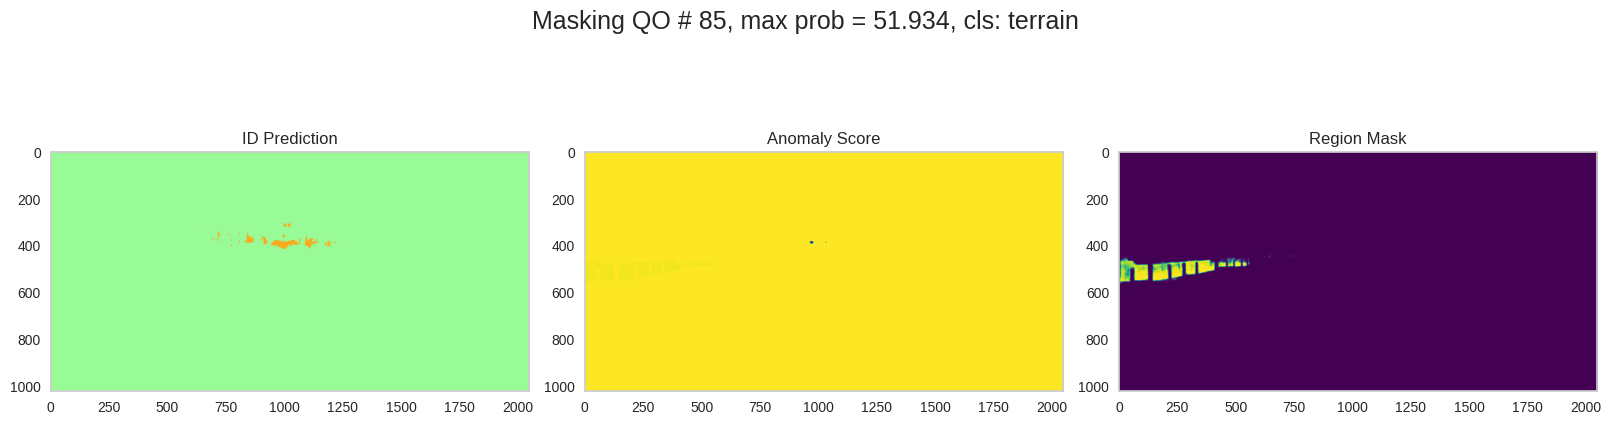

Road Prob tensor(0.0011, device='cuda:0')


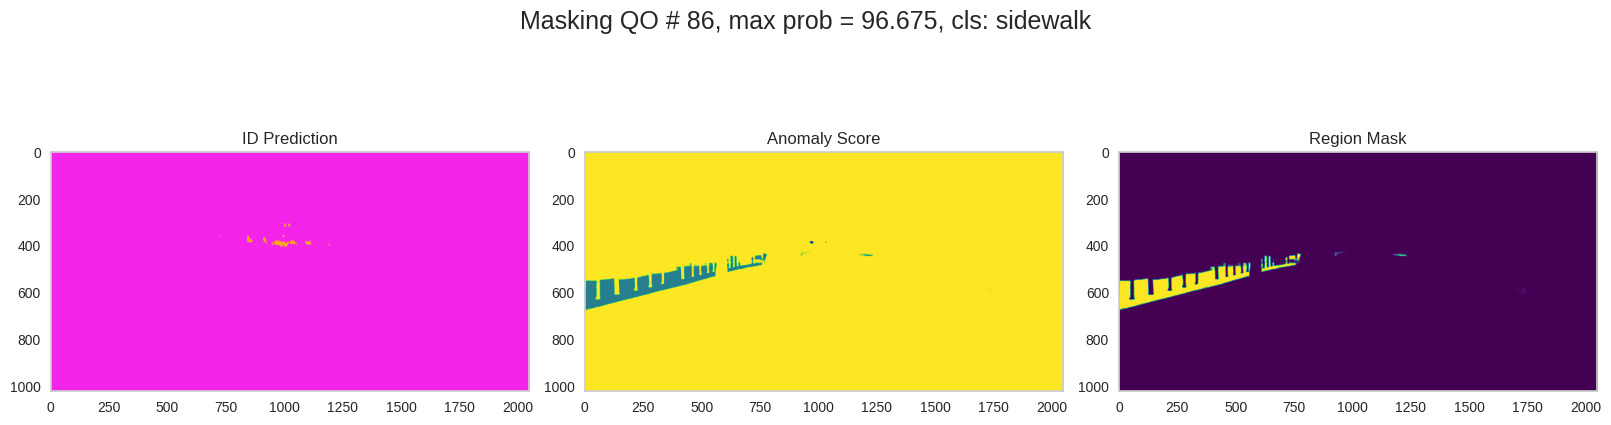

Road Prob tensor(1.4170e-05, device='cuda:0')


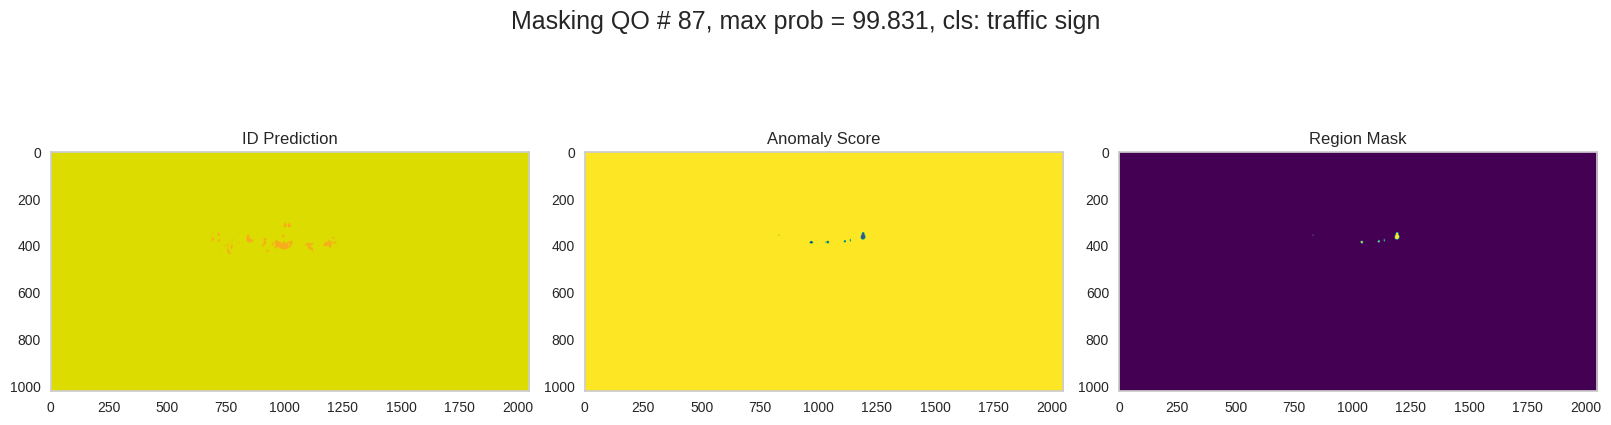

Road Prob tensor(0.0005, device='cuda:0')


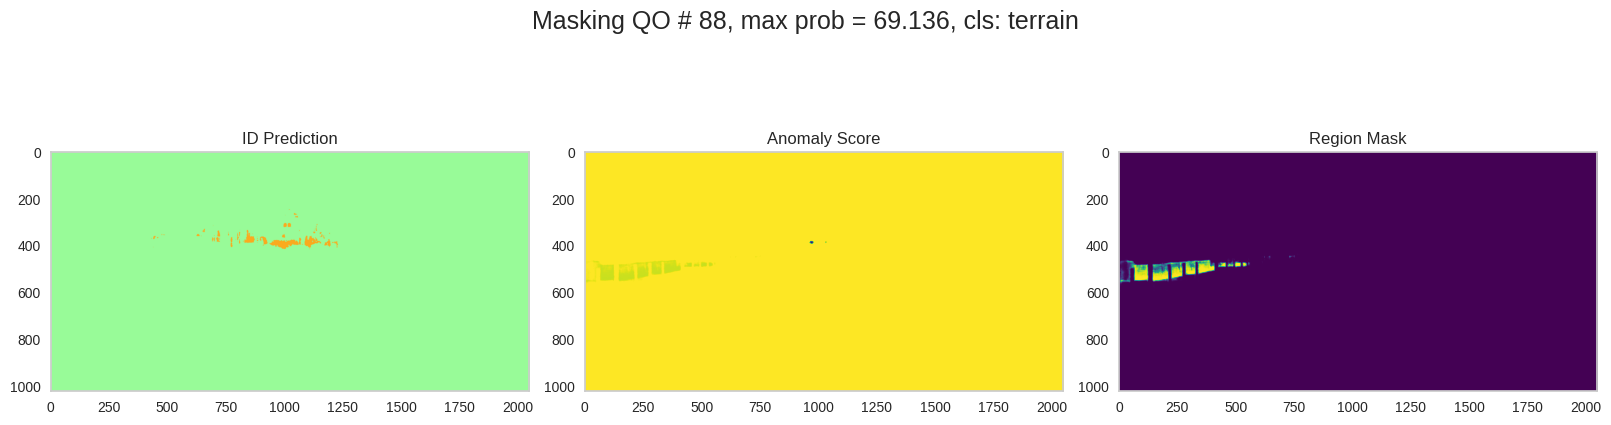

Road Prob tensor(0.0002, device='cuda:0')


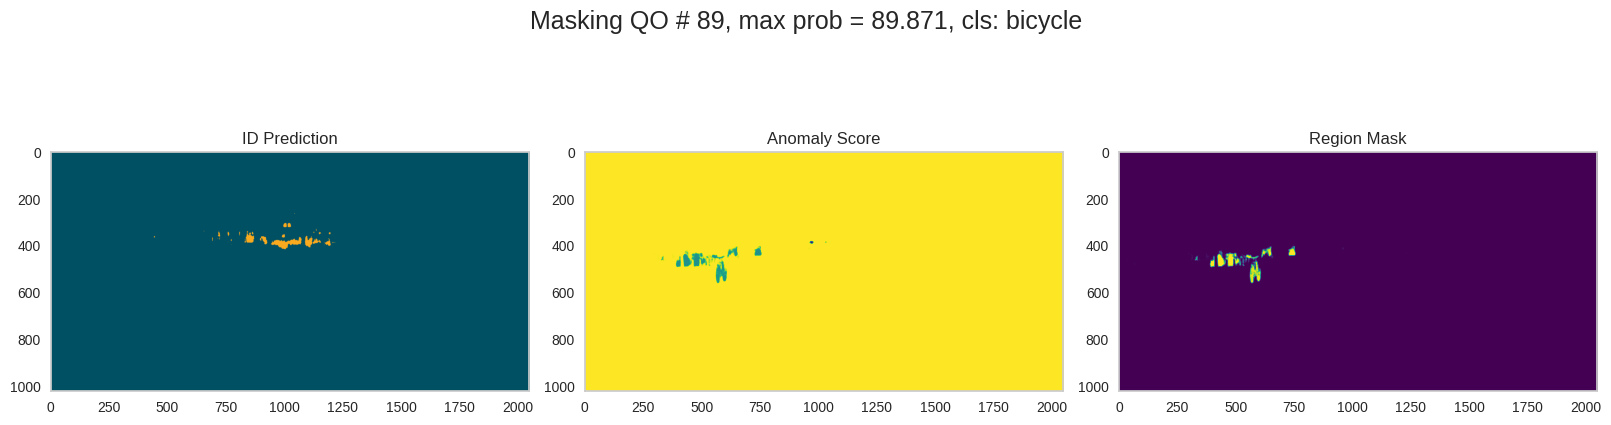

Road Prob tensor(0.0041, device='cuda:0')


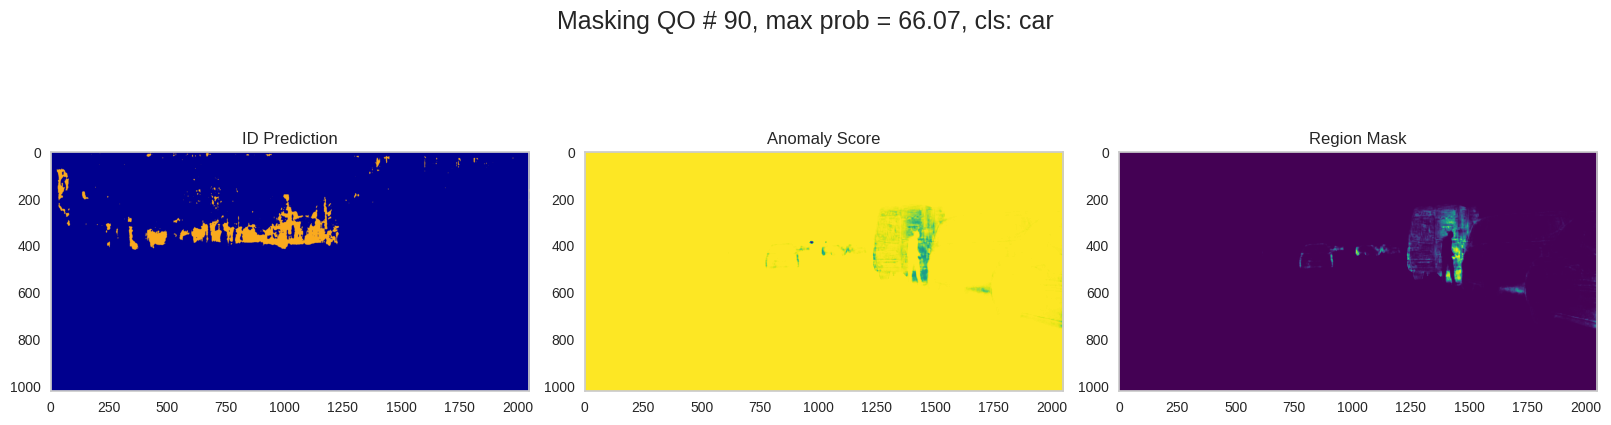

Road Prob tensor(0.0030, device='cuda:0')


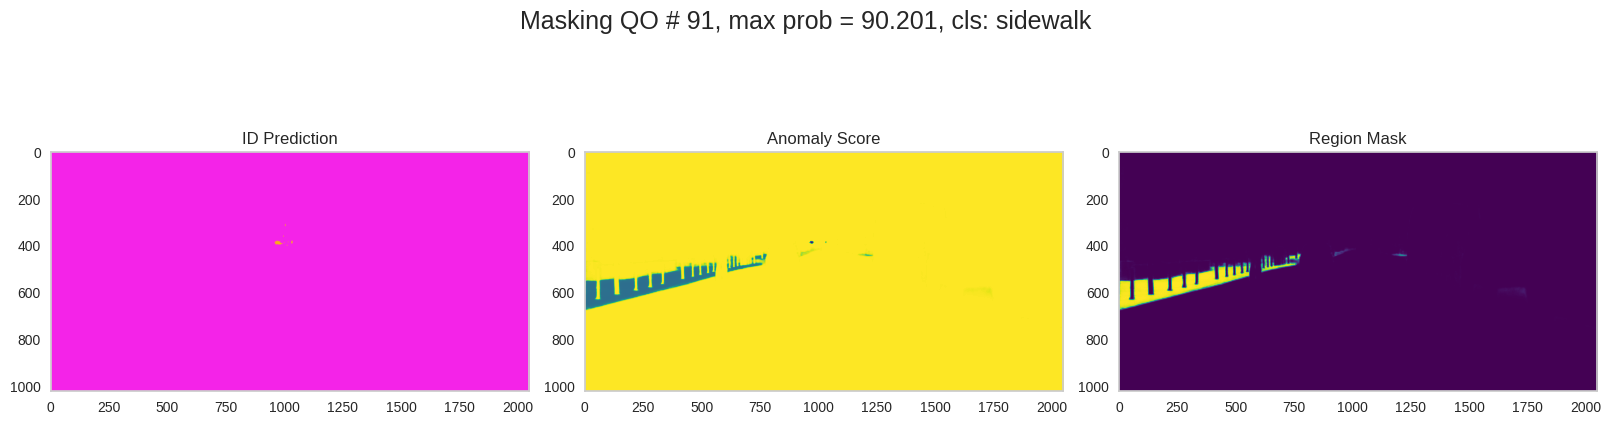

Road Prob tensor(0.0002, device='cuda:0')


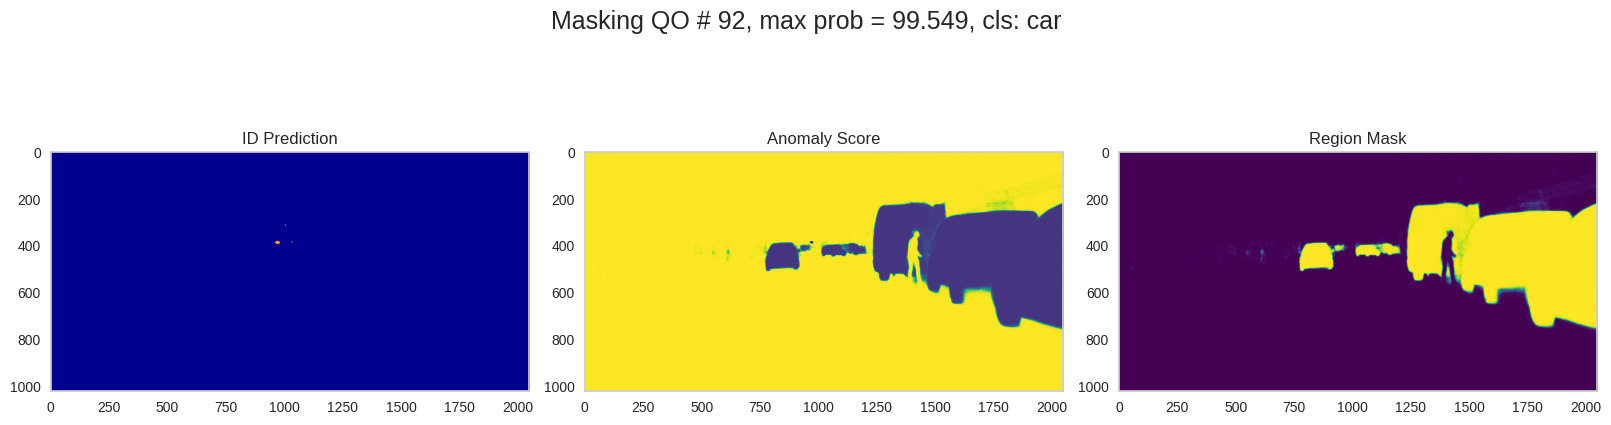

Road Prob tensor(0.0007, device='cuda:0')


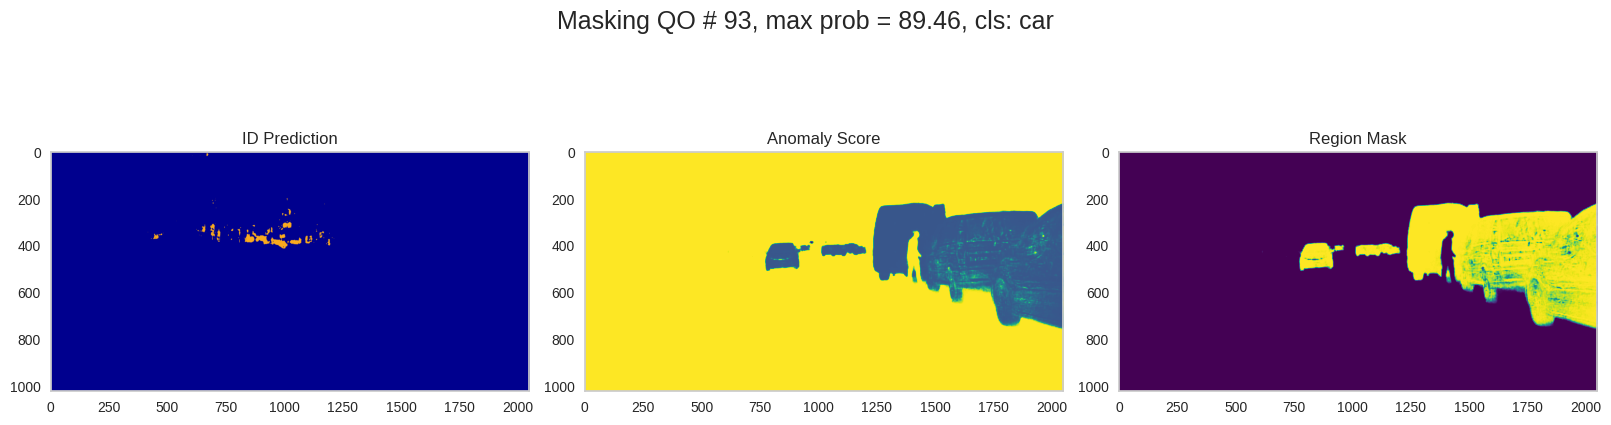

Road Prob tensor(0.0003, device='cuda:0')


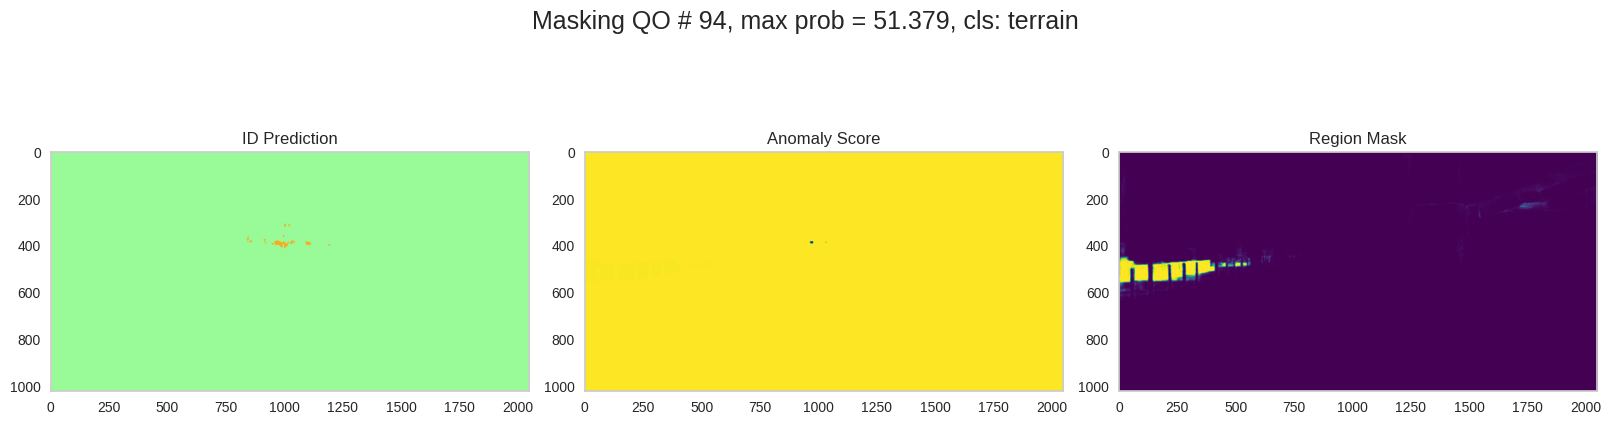

Road Prob tensor(0.0003, device='cuda:0')


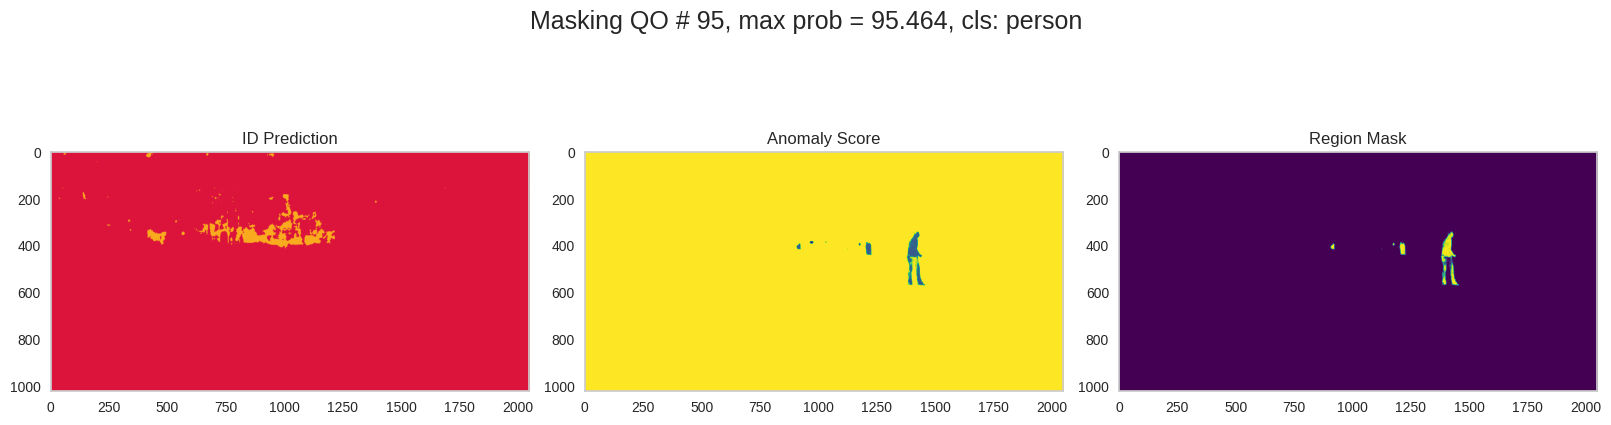

Road Prob tensor(0.0008, device='cuda:0')


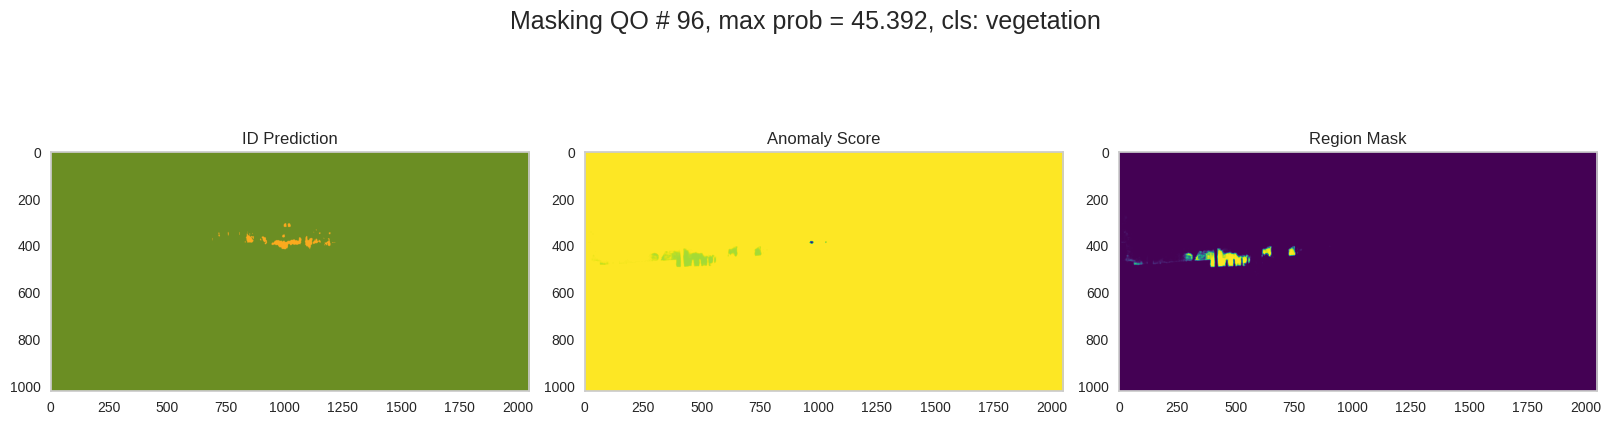

Road Prob tensor(5.4513e-05, device='cuda:0')


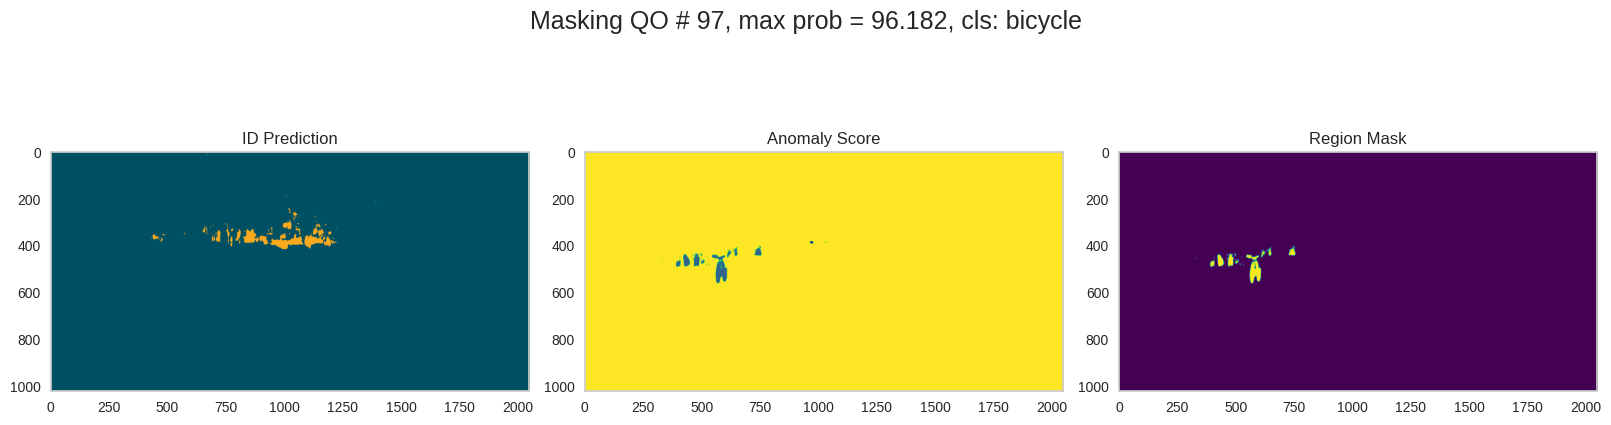

Road Prob tensor(0.0108, device='cuda:0')


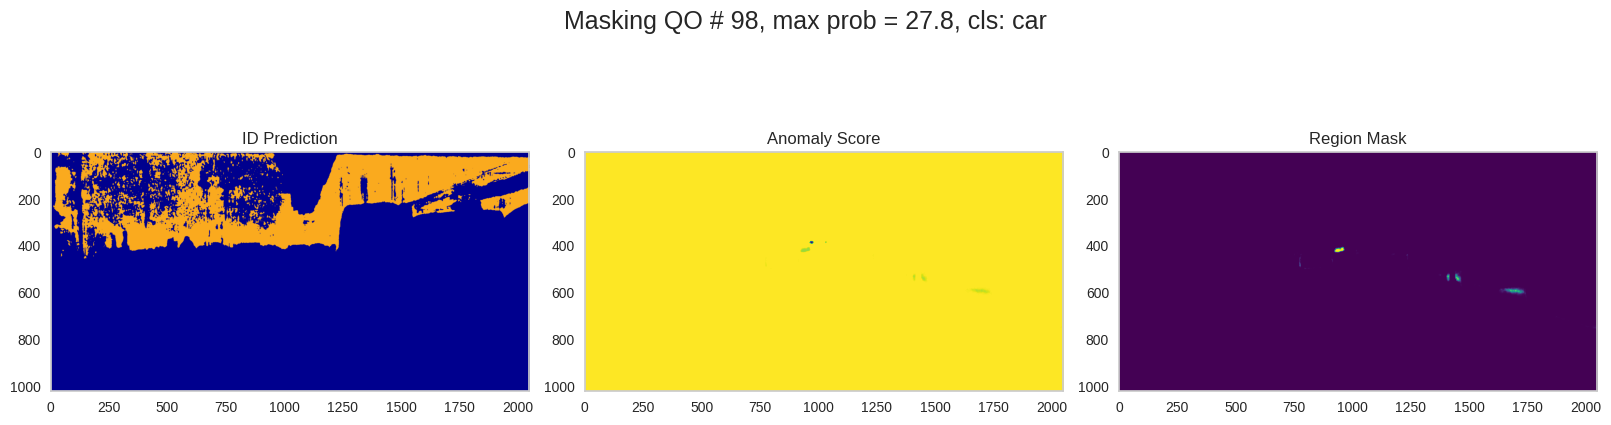

Road Prob tensor(0.0004, device='cuda:0')


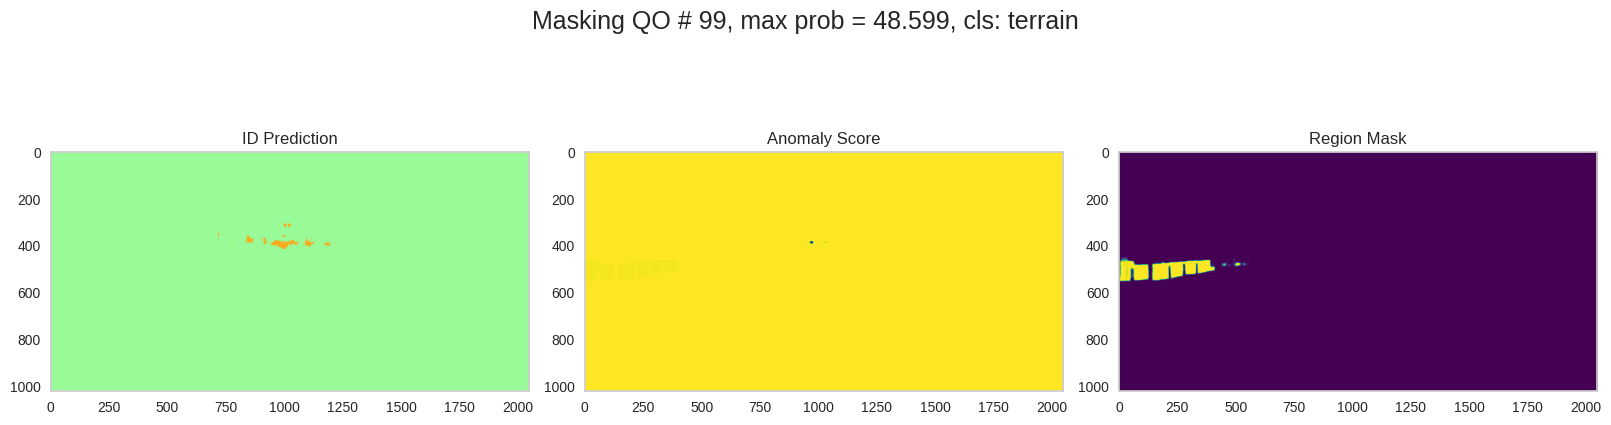

In [205]:
show_anomaly_maps_by_masking_all_except_1_qo(model_swin_b, img)

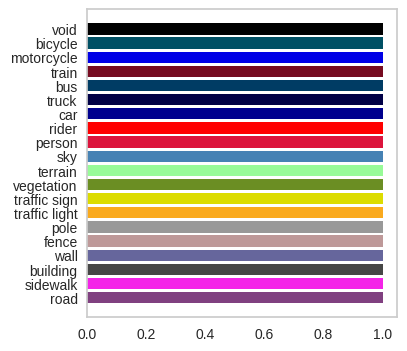

In [88]:
show_colormap_key()

### Find Samples of a particular class

In [18]:
def find_samples_with_class(dataset, class_id):
    
    samples = []
    for i in tqdm(range(len(dataset))):
        _, lbl = dataset[i]
        if (lbl == class_id).sum() > 0:
            samples.extend([i])
    return samples

In [33]:
rider_idx = find_samples_with_class(bdd100k_dataset, 12)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
rider_idx

[17,
 23,
 63,
 78,
 79,
 105,
 126,
 146,
 211,
 250,
 270,
 271,
 300,
 301,
 320,
 341,
 353,
 366,
 421,
 431,
 432,
 489,
 514,
 516,
 526,
 591,
 621,
 669,
 685,
 696,
 715,
 770,
 825,
 832,
 860,
 875,
 879,
 894,
 931]

### Find object queries that specialize in classes.

For every class which is predicted by some mask with confidence >0.98 count how many such query objects are there for each class. It is expected that for each class one query object would take the majority.

In [12]:
def find_specialized_qo(dataset, model):
    
    results = np.zeros((19, 100))
    
    for i in tqdm(range(len(dataset))):
        
        img, lbl = dataset[i]
        logits, prob_logits, mask_logits = get_logits(model, img.unsqueeze(0), include_void=True, 
                                              return_separately=True)
        probs = torch.softmax(prob_logits.squeeze()[:,:19], dim=1)
        for j in range(probs.shape[0]):
            cls = torch.argmax(probs[j])
            if probs[j, cls] < 0.98:
                continue
            results[cls][j] += 1
            
    return results
            
def find_specialized_qo_masks(dataset, model, threshold=0):
    
    stats = find_specialized_qo(dataset, model)
    qo_masks = {}
    for i in range(stats.shape[0]):
        qo_masks[i] = np.where(stats[i] > threshold)[0]
    
    return qo_masks

In [365]:
stats = find_specialized_qo(bdd100k_dataset, model_swin_b)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor

In [371]:
idx = 3
mx = stats[idx].argmax()
print(mx)

print(stats[idx])
print(stats[idx, mx])

66
[  0.   0.   0.   1.   0.   0.   4.   0.   0.   0.   0.   0.   0.   0.
   0.   2.   0.   0.   0.   0.   1.   0.   0.   0.   3.   0.   0.   0.
   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   9.
   0.   0.   0.   0.   0.   0.   0.   1.   0.  66.   0.   0.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0. 412.   0.   0.   0.
   1.   1.   0.   0.   0.   0.   0.   0.   0.   1.  22.   0.   3.   0.
   1.   6.   0.   0.   0.   0.   0.   0.   0.   0.   3.   0.   1.   0.
   1.   0.]
412.0


## Evaluate Query objects as one-class classifiers

In [99]:
class_to_qo = np.array([
    16, # road 0
    91, # sidewalk 1
    56, # building 2
    66, # wall 3
    14, # fence 4
    60, # pole 5
    25, # traffic light 6
    10, # traffic sign 7
    9,  # vegetation 8
    68, # terrain 9
    23, # sky 10
    54, # person 11
    62, # rider 12
    92, # car 13
    83, # truck 14
    37, # bus 15
    29, # train 16
    40, # motorcycle 17
    44, # bicycle 18
])

In [13]:
class_to_qo_masks = find_specialized_qo_masks(bdd100k_dataset, model_swin_b)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor

In [41]:
class_to_qo_masks[18]

array([39, 44, 64, 75])

In [57]:
model_swin_b = get_model('swin_b')

WARNING [08/11 15:19:15 fvcore.common.config]: Loading config ./configs/cityscapes/semantic-segmentation/swin/../Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
[08/11 15:19:15 detectron2]: Rank of current process: 0. World size: 1
[08/11 15:19:16 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
numpy                   1.19.0
detectron2              0.6 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.3
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0+cu113 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-pa

[08/11 15:19:16 detectron2]: Full config saved to ./output/config.yaml
[08/11 15:19:16 d2.utils.env]: Using a generated random seed 16945893
[08/11 15:19:17 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
         

[08/11 15:19:17 fvcore.common.checkpoint]: [Checkpointer] Loading from ./pretrained/swin_b_in21k_model_final_1c6b65.pkl ...
[08/11 15:19:17 fvcore.common.checkpoint]: Reading a file from 'MaskFormer Model Zoo'
WARNING [08/11 15:19:17 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [58]:
def evaluate_per_class_mIoU(dataset, model):
    
    mIoU_per_class = JaccardIndex(num_classes=20, average='none', ignore_index=19)
    mIoU = JaccardIndex(num_classes=20, ignore_index=19)
    for i in tqdm(range(len(dataset))):
        
        img, lbl = dataset[i]
        
        logits, prob_logits, mask_logits = get_logits(model, img.unsqueeze(0), include_void=False, 
                                          return_separately=True)
        
        dummy_extension = torch.zeros(logits.shape[0], 1, logits.shape[2], logits.shape[3]).to(logits.device)
        logits = torch.cat([logits, dummy_extension], dim=1)
        
        mIoU_per_class.update(logits.cpu(), lbl.unsqueeze(0))
        mIoU.update(logits.cpu(), lbl.unsqueeze(0))
        
    return mIoU_per_class.compute(), mIoU.compute()

def evaluate_one_class_with_masking(dataset, model, class_to_qo_map, use_membership=False):
    
    query_objects = model.sem_seg_head.predictor.query_feat.weight.cpu().detach().clone()
    query_pe = model.sem_seg_head.predictor.query_embed.weight.cpu().detach().clone()
    
    zero_masks = nn.parameter.Parameter(torch.zeros_like(query_objects).to(model.device))
    zero_masks_pe = nn.parameter.Parameter(torch.zeros_like(query_objects).to(model.device))
    
    with torch.no_grad():
        model.sem_seg_head.predictor.query_feat.weight = zero_masks
        model.sem_seg_head.predictor.query_embed.weight = zero_masks_pe
    
    if isinstance(class_to_qo_map, dict):
        lst = []
        for k, v in class_to_qo_map.items():
            lst.append(v)
        class_to_qo_mapping = lst
    else:
        class_to_qo_mapping = class_to_qo_map
    
    IoU_class = []
    
    for cls, qo in enumerate(tqdm(class_to_qo_mapping, desc='Class Loop')):
        
        with torch.no_grad():
            model.sem_seg_head.predictor.query_feat.weight[qo] = query_objects[qo].to(model.device)
            model.sem_seg_head.predictor.query_embed.weight[qo] = query_pe[qo].to(model.device)
        
        IoU_metric = JaccardIndex(num_classes=2, average=None)
        
        for i in tqdm(range(len(dataset)), desc='Dataset Loop'):
            
            img, lbl = dataset[i]
            
            logits, prob_logits, mask_logits = get_logits(model, img.unsqueeze(0), include_void=False, 
                                              return_separately=True)
            
            probs = torch.softmax(logits.squeeze(), dim=0)
            
            
            pred = torch.ones((probs.shape[1], probs.shape[2]))    
            if use_membership:
                membership_score = mask_logits.squeeze()[qo].sigmoid()
                pred[membership_score > 0.5] = 0
            else:
                cls_prob = probs[cls]
                cls_prob = (cls_prob - cls_prob.min()) / (cls_prob.max() - cls_prob.min())
                pred[cls_prob > 0.5] = 0
                
            gt = torch.ones_like(lbl)
            gt[lbl == cls] = 0
            
            IoU_metric(pred.cpu(), gt.cpu())
            
        IoU_class.extend([IoU_metric.compute()])
        
        print(f"Class {cls}:")
        print(IoU_class)
        print("------------------")
        
        with torch.no_grad():
            model.sem_seg_head.predictor.query_feat.weight[qo] = nn.parameter.Parameter(
                torch.zeros_like(query_objects[qo]).to(model.device)
            )
            model.sem_seg_head.predictor.query_embed.weight[qo] = nn.parameter.Parameter(
                torch.zeros_like(query_pe[qo]).to(model.device)
            )
    
    with torch.no_grad():
        model.sem_seg_head.predictor.query_feat.weight = nn.Parameter(query_objects.to(model.device))
        model.sem_seg_head.predictor.query_embed.weight = nn.Parameter(query_pe.to(model.device))
        
    return IoU_class

def evaluate_one_class(dataset, model, class_to_qo_mapping):
    
    
    num_classes = len(class_to_qo_mapping)
    
    IoU_metrics = [JaccardIndex(num_classes=2, average=None) for _ in range(num_classes)]
    
    
    for i in tqdm(range(len(dataset)), desc='Dataset Loop'):
            
        img, lbl = dataset[i]

        logits, prob_logits, mask_logits = get_logits(model, img.unsqueeze(0), include_void=False, 
                                          return_separately=True)
        probs = torch.softmax(logits.squeeze(), dim=0)
                      
        for cls, qo in enumerate(class_to_qo_mapping):
        
            cls_prob = probs[cls]
            membership_score = mask_logits.squeeze()[qo].sigmoid()
            
            gt = torch.ones_like(lbl)
            gt[lbl == cls] = 0
            
            pred = torch.ones((probs.shape[1], probs.shape[2]))
            pred[membership_score > 0.5] = 0
            
            IoU_metrics[cls](pred.cpu(), gt.cpu())
        
    results = [IoU.compute() for IoU in IoU_metrics]
                      
    return results

In [52]:
results_hard = evaluate_one_class_with_masking(cityscapes_dataset, model_swin_b, class_to_qo)

NameError: name 'class_to_qo' is not defined

In [349]:
for i, re in enumerate(results_hard):
    print("%15s %s %.2f"%(bdd100k_dataset.class_names[i], ":", np.round(re[0].item() * 100, 2)))

           road : 72.24
       sidewalk : 72.50
       building : 89.66
           wall : 11.31
          fence : 23.53
           pole : 67.03
  traffic light : 30.90
   traffic sign : 66.64
     vegetation : 91.24
        terrain : 32.19
            sky : 89.99
         person : 72.65
          rider : 14.69
            car : 89.84
          truck : 5.20
            bus : 12.58
          train : 3.65
     motorcycle : 5.74
        bicycle : 57.40


In [339]:
results_soft = evaluate_one_class(cityscapes_dataset, model_swin_b, class_to_qo)

Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

In [341]:
results_soft

[tensor([0.9438, 0.9712]),
 tensor([0.7582, 0.9854]),
 tensor([0.9098, 0.9776]),
 tensor([0.4971, 0.9948]),
 tensor([0.6234, 0.9963]),
 tensor([0.6806, 0.9951]),
 tensor([0.6767, 0.9993]),
 tensor([0.7718, 0.9985]),
 tensor([0.9178, 0.9847]),
 tensor([0.6192, 0.9964]),
 tensor([0.9216, 0.9975]),
 tensor([0.8418, 0.9980]),
 tensor([0.6373, 0.9991]),
 tensor([0.9506, 0.9969]),
 tensor([0.2078, 0.9905]),
 tensor([0.4287, 0.9956]),
 tensor([0.4331, 0.9990]),
 tensor([0.4265, 0.9992]),
 tensor([0.7747, 0.9984])]

In [346]:
IoU_per_class, mIoU = evaluate_per_class_mIoU(cityscapes_dataset, model_swin_b)

  0%|          | 0/500 [00:00<?, ?it/s]

In [356]:
mIoU_soft = 0
mIoU_hard = 0
print("%15s %s %10s %10s %10s"%("class", ":", "QO-Before", "QO-After", "Official"))
for i in range(len(results_soft)):
    IoU_qo_masked = np.round(results_hard[i][0].item() * 100, 2)
    IoU_qo = np.round(results_soft[i][0].item() * 100, 2)
    IoU_of = np.round(IoU_per_class[i].item() * 100, 2)
    print("%15s %s %10.2f %10.2f %10.2f"%(bdd100k_dataset.class_names[i], ":", IoU_qo_masked, IoU_qo, IoU_of))
    mIoU_soft += IoU_qo
    mIoU_hard += IoU_qo_masked
mIoU_soft /= len(results_soft)
mIoU_hard /= len(results_hard)

print("%15s %s %10.2f %10.2f %10.2f"%("mIoU", ":", mIoU_hard, mIoU_soft, mIoU.item() * 100))

          class :  QO-Before   QO-After   Official
           road :      72.24      94.38      98.64
       sidewalk :      72.50      75.82      88.75
       building :      89.66      90.98      94.01
           wall :      11.31      49.71      66.73
          fence :      23.53      62.34      69.59
           pole :      67.03      68.06      71.65
  traffic light :      30.90      67.67      76.20
   traffic sign :      66.64      77.18      84.27
     vegetation :      91.24      91.78      93.35
        terrain :      32.19      61.92      68.40
            sky :      89.99      92.16      95.65
         person :      72.65      84.18      86.06
          rider :      14.69      63.73      70.69
            car :      89.84      95.06      96.16
          truck :       5.20      20.78      89.70
            bus :      12.58      42.87      92.73
          train :       3.65      43.31      84.51
     motorcycle :       5.74      42.65      74.60
        bicycle :      57.40   

In [59]:
results_masking_multi_qo = evaluate_one_class_with_masking(
    cityscapes_dataset, model_swin_b, class_to_qo_masks, use_membership=False
)

Class Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 0:
[tensor([0.7985, 0.8830])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 1:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 2:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 3:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 4:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 5:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 6:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 7:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 8:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 9:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 10:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 11:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158]), tensor([0.0894, 0.8926])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 12:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158]), tensor([0.0894, 0.8926]), tensor([0.0036, 0.5630])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 13:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158]), tensor([0.0894, 0.8926]), tensor([0.0036, 0.5630]), tensor([0.7304, 0.9783])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 14:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158]), tensor([0.0894, 0.8926]), tensor([0.0036, 0.5630]), tensor([0.7304, 0.9783]), tensor([0.0033, 0.2245])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 15:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158]), tensor([0.0894, 0.8926]), tensor([0.0036, 0.5630]), tensor([0.7304, 0.9783]), tensor([0.0033, 0.2245]), tensor([0.0040, 0.1620])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 16:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158]), tensor([0.0894, 0.8926]), tensor([0.0036, 0.5630]), tensor([0.7304, 0.9783]), tensor([0.0033, 0.2245]), tensor([0.0040, 0.1620]), tensor([0.0011, 0.1687])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 17:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158]), tensor([0.0894, 0.8926]), tensor([0.0036, 0.5630]), tensor([0.7304, 0.9783]), tensor([0.0033, 0.2245]), tensor([0.0040, 0.1620]), tensor([0.0011, 0.1687]), tensor([0.0009, 0.2919])]
------------------


Dataset Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Class 18:
[tensor([0.7985, 0.8830]), tensor([0.6374, 0.9746]), tensor([0.8761, 0.9685]), tensor([0.0121, 0.5605]), tensor([0.0182, 0.6710]), tensor([0.5439, 0.9913]), tensor([0.0046, 0.6757]), tensor([0.2258, 0.9824]), tensor([0.8365, 0.9667]), tensor([0.0205, 0.7221]), tensor([0.2603, 0.9158]), tensor([0.0894, 0.8926]), tensor([0.0036, 0.5630]), tensor([0.7304, 0.9783]), tensor([0.0033, 0.2245]), tensor([0.0040, 0.1620]), tensor([0.0011, 0.1687]), tensor([0.0009, 0.2919]), tensor([0.0226, 0.7585])]
------------------


# Examining Query Objects

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import normalize
from hdbscan import HDBSCAN

def apply_kmeans(data, n_clusters, max_iter=300):

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=max_iter)
    clusters = kmeans.fit_predict(data)

    return clusters


In [518]:
query_objects = model_swin_b.sem_seg_head.predictor.query_feat.weight.cpu().detach().numpy()

In [524]:
query_objects.shape

(100, 256)

In [540]:
qo_df = pd.DataFrame()

/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


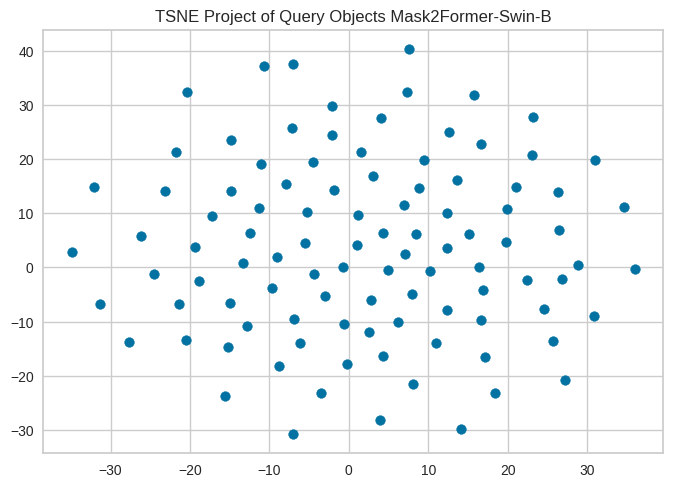

In [541]:
qo_tsne = vis.get_tsne(query_objects, n_components=2)
plt.scatter(qo_tsne[:,0], qo_tsne[:,1])
plt.title('TSNE Project of Query Objects Mask2Former-Swin-B')
plt.show()

qo_df['x_tsne'] = qo_tsne[:, 0]
qo_df['y_tsne'] = qo_tsne[:, 1]

In [542]:
qo_clusters_2 = vis.apply_kmeans(query_objects, n_clusters=2)

In [564]:
qo_clusters[83]

0

In [543]:
qo_df['clusters_2'] = qo_clusters_2

In [547]:
 fig = px.scatter(
    qo_df,
    x='x_tsne',
    y='y_tsne',
    color=qo_clusters_2,
    hover_data=['clusters_2'],
    #color_continuous_scale=px.colors.qualitative.G10,
)
fig.update_layout(
    title_text=f'KMeans Clustering of Query Objects'
)

In [350]:
a = torch.randn(3, 3)
a

tensor([[-0.5442, -0.3656,  1.0714],
        [ 0.8150, -0.5239,  0.5772],
        [-1.2652, -0.1100, -0.4631]])

In [354]:
a.softmax(dim=1)

tensor([[0.1384, 0.1654, 0.6962],
        [0.4877, 0.1278, 0.3845],
        [0.1561, 0.4957, 0.3482]])